In [940]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler  #  MinMaxScaler,
from numpy.linalg import inv

from scipy.optimize import minimize

In [941]:
# sk바이오팜, 하이브 자산 선정에서 오류 있었음. -> 이는 일단 삼성전자로 모두 보냄.

In [942]:
class Make_data():
    
    def __init__(self):
        
        # 시장 가격
        self.mkt = pd.read_csv('index.csv', index_col = 0, thousands= ',')  # KOSPI/KOSDAQ
        self.mkt.index = pd.to_datetime(self.mkt.index)            
            
        
        self.marketequity = pd.read_csv('market_equity_kospi.csv', thousands = ',', index_col = 0)
        self.marketequity.index = pd.to_datetime(self.marketequity.index)
        
        
        # Daily
        self.adj_close = pd.read_csv('close.csv', thousands = ',', index_col = 0)
        self.adj_close.index = pd.to_datetime(self.adj_close.index)
        self.adj_open = pd.read_csv('open.csv', thousands = ',', index_col = 0)
        self.adj_open.index = pd.to_datetime(self.adj_open.index)
        self.adj_high = pd.read_csv('high.csv', thousands = ',', index_col = 0)
        self.adj_high.index = pd.to_datetime(self.adj_high.index)
        self.adj_low = pd.read_csv('low.csv', thousands = ',', index_col = 0)
        self.adj_low.index = pd.to_datetime(self.adj_low.index)
        self.adj_volume = pd.read_csv('volume.csv', thousands = ',', index_col = 0)
        self.adj_volume.index = pd.to_datetime(self.adj_volume.index)

        # 일별 로그리턴 (주식,시장)
        self.stock_log_return = np.log(self.adj_close).diff(1)
        self.market_log_return = np.log(self.mkt).diff(1)


    def market_stock(self, dataframe, market):
        dataframe = dataframe[dataframe==market].dropna()
        return dataframe
    
    def data_split(self, dataframe, from_date, to_date):

        data = dataframe[to_date >= dataframe.index]
        data = data[from_date <= data.index]
        
        return data

In [943]:
datas = Make_data()

In [944]:
whole_open = datas.adj_open
whole_high = datas.adj_high
whole_low = datas.adj_low
whole_close = datas.adj_close
whole_volume = datas.adj_volume


open_temp = whole_open.loc[:'2022-11-11'] # 인덱싱 맞춰주기
whole_market_equity = datas.marketequity.loc[open_temp.index]
whole_return = datas.stock_log_return

In [945]:
whole_market_equity.drop(['A000830', 'A003600', 'A000030'], axis=1, inplace=True)

In [946]:
# import torch
# import torch.nn as nn

# class BiLSTM(nn.Module):
#     def __init__(self, input_dim, latent_dim, num_layers, output_dim):
#         super(BiLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_dim, latent_dim, num_layers=num_layers, bidirectional=True, batch_first=True, dropout = 0.2)
#         self.fc = nn.Linear(2*latent_dim, output_dim)  # 2*latent_dim because of bidirectionality

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         # Take the output from the last time step
#         final_output = lstm_out[:, -1, :]
#         return self.fc(final_output)

# input_dim = 5
# latent_dim = 50
# num_layers = 4
# output_dim = 1

# bi_lstm_model = BiLSTM(input_dim, latent_dim, num_layers, output_dim)
# bi_lstm_model.load_state_dict(torch.load('bilstm_120_lr_0.0001_final.pt'))

In [947]:
def calculate_mape(actual, predicted):
    return (1 / len(actual)) * sum(abs((actual - predicted) / actual)) * 100

In [948]:
# 무위험수익률, 수익률,공분산으로 효율적 프런티어 계산
def solveFrontier(R, C, rf, initial_weights, delta):

    # 파이썬은 함수안에 함수를 정의할 수 있다
    # 최적비중계산을 위해 다음과 같이 목적함수를 정의한다
    def obj(W, R, C, r):
        # 주어진 수익률에서 분산을 최소로 하는 비중 계산
        mean = sum(np.dot(np.transpose(R), W)) # sum(R * W)
        var = np.dot(np.dot(W, C), W)
        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r) #    주어진 수익률을 달성하기 위한 constraint 조건          
        return penalty + (1/2)*var  # delta*  var + penalty 

    # 효율적 프론티어를 구성하는 평균-분산을 돌려줄
    # 리스트를 미리 준비한다
    frontier_mean, frontier_var = [], []

    n = len(R)  # 투자자산 갯수
    frontier_weights = []
    # 수익률 최저~최대 사이를 반복한다
    for r in np.linspace(min(R), max(R), num=20):
        # 최적화 함수에 전달할 초기값으로 초기 시총기준 weight로 시작한다.
        W =  initial_weights # np.ones([n]) / n 
        # 최적화 함수에 전달할 범위조건과 제약조건을 미리 준비한다
        # 범위조건: 각 구성자산의 투자비중은 0~100% 사이이며
        # 제약조건: 전체 투자비중은 100%이다.
        bnds = [(0, 1) for i in range(n)]
        cons = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        # 최적화 함수 minimize()은 최적화할 obj함수와 
        # 최적화를 시작할 초깃값을 인수로 받는다.         
        res = minimize(obj, W, (R, C, r), method='SLSQP', constraints=cons, bounds=bnds)
        # 분산, 즉 risk를 최소화하는 방향으로 weight를 찾는다.
        frontier_weights.append(res.x)

        frontier_mean.append(r)
        frontier_var.append(np.dot(np.dot(res.x, C), res.x))
    return np.array(frontier_mean), np.array(frontier_var), frontier_weights

In [949]:
# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf, initial_weights, delta):
    # 효율적 포트폴리오 계산
    eff_mean, eff_var, frontier_weights = solveFrontier(R, C, rf, initial_weights, delta)

    tangent = []
    for i in range(len(frontier_weights)):
        tangent.append(np.dot(np.transpose(R),frontier_weights[i]) / np.dot(np.dot(frontier_weights[i], C), frontier_weights[i])**.5)
    tangent_maximize = np.argmax(tangent)


    optimized_W_1  = frontier_weights[tangent_maximize]
    tan_mean = np.dot(np.transpose(R),optimized_W_1)
    tan_var = np.dot(np.dot(optimized_W_1, C), optimized_W_1)
    

    #optimized_W_2 -> Initial Weights Strategy
    #optimized_W_2 = optimized_W_1
    #optimized_W_3 -> Minimum Variance Strategy
    #optimized_W_3 = optimized_W_1


    ## 두번째 전략
    #if tan_mean/tan_var < 0:
    #    optimized_W_2 = initial_weights
    #    optimized_W_3 = frontier_weights[np.argmin(eff_var)]

        #optimized_W_3 -> 각 시점에서 가장 작은 분산을 가진 애들로 optimize
        
    # 비중, 접점포트폴리오의 평균/분산, 효율적 포트폴리오의 평균/분산을
    # 딕셔너리 데이터형으로 돌려준다    
    return {'weights_1':optimized_W_1,'tan_mean':tan_mean, 'tan_var':tan_var, 'eff_mean':eff_mean, 'eff_var':eff_var,}  #  'R':R, 'C':C

In [950]:
# 표 만드는 함수

def plotAssets(tickers, R, C, color='black'):
    # 포트폴리오 구성자산 출력
    for i in range(10):
        plt.scatter([C[i, i] ** .5 ], [R[i]], marker='x', color=color)  
    for i in range(10): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % tickers[i], verticalalignment='center', color=color) 

def plotFrontier(result, label=None, color='black'):
    # 최적화된 효율적 프런티어 출력

    plt.plot(result['eff_var'] ** .5, result['eff_mean'], label=label, color=color, linewidth=2, marker='D', markersize=5) 

    plt.text(result['tan_var'] ** .5, result['tan_mean'], 'Tangent portfolio', size = 20,verticalalignment='center', color='blue')
    plt.scatter(result['tan_var'] ** .5, result['tan_mean'], linewidth=3, marker='D', color='blue')

    plt.plot([0, result['tan_var'] ** .5], [0, result['tan_mean'][0]], color='blue', linewidth=3, linestyle='--')

In [951]:
def mdd(series):
    series = series.values
    cumseries = np.cumsum(series)
    mdd = 0
    for i, s in enumerate(cumseries):
        mdd_s = s - np.min(cumseries[i:])
        if mdd_s > mdd:
            mdd = mdd_s

    return mdd


def annual_yield_indicator(yield_):
    print('Annualized return : ', np.round(np.mean(yield_)*252, 2))
    print('Annualized std : ', np.round(np.std(yield_)*(252**0.5),2))
    print('Sharpe ratio : ', np.round(np.mean(yield_)*252
                                    /(np.std(yield_)*(252**0.5)),2))
    print('Downside deviation : ', np.round(np.std(yield_[yield_<0])[0]*(252**0.5),2))
    # print('Sortino ratio : ', np.round(np.mean(yield_)[0]*252
    #                                 /(np.std(yield_[yield_<0])*(252**0.5)),2))
    print('Maximum drawdown(MDD) : ', np.round(mdd(yield_),2))
    print('Calmar ratio : ', np.round(np.mean(yield_)[0]*252/mdd(yield_),2))



# 시작: 2019년 1월 16일, 엔딩: 2022년 11월 08일

In [952]:
start_idx = whole_return.index.get_loc('2019-01-16')
end_idx = whole_return.index.get_loc('2022-11-08')


In [953]:
(end_idx-start_idx)/20

47.0

# 모델 불러오는 코드

In [954]:
import numpy as np
import torch
import torch.nn as nn

# 파라미터 (수정 X)
context_length = 120 # 모델이 참조할 데이터 길이 (original: 512)
forecast_horizon = 20 # 모델이 예측할 데이터 길이 (original: 96)
patch_length = 15 # 모델의 patch 길이. context_length의 약수여야 한다. (original: 16)
num_workers = 1 # dataloader worker 개수

from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# PatchTSMixer Model
config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=forecast_horizon,
    patch_length=patch_length,
    num_input_channels=6, # close, high, low, open, volume, stock_log_return
    patch_stride=patch_length,
    d_model=16,
    num_layers=8,
    expansion_factor=2,
    dropout=0.2,
    head_dropout=0.2,
    mode="common_channel",
    scaling="std",
    prediction_channel_indices=[5] # 'stock_log_return'만을 예측하도록 하자.
)

ts_model = PatchTSMixerForPrediction(config)
ts_model.to(device)

# Custom Model
class CustomModel(nn.Module):
    def __init__(self, ts_model=ts_model):
        super().__init__()
        self.ts_model = ts_model
        self.fc = nn.Linear(forecast_horizon, 1)

    def forward(self, past_values):
        prediction = self.ts_model(past_values=past_values)
        x = prediction.prediction_outputs.squeeze()
        x = self.fc(x)
        return x

model = CustomModel()
model.to(device)

CustomModel(
  (ts_model): PatchTSMixerForPrediction(
    (model): PatchTSMixerModel(
      (encoder): PatchTSMixerEncoder(
        (patcher): Linear(in_features=15, out_features=16, bias=True)
        (mlp_mixer_encoder): PatchTSMixerBlock(
          (mixers): ModuleList(
            (0-7): 8 x PatchTSMixerLayer(
              (patch_mixer): PatchMixerBlock(
                (norm): PatchTSMixerNormLayer(
                  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
                )
                (mlp): PatchTSMixerMLP(
                  (fc1): Linear(in_features=8, out_features=16, bias=True)
                  (dropout1): Dropout(p=0.2, inplace=False)
                  (fc2): Linear(in_features=16, out_features=8, bias=True)
                  (dropout2): Dropout(p=0.2, inplace=False)
                )
                (gating_block): PatchTSMixerGatedAttention(
                  (attn_layer): Linear(in_features=8, out_features=8, bias=True)
                  (attn_s

In [955]:
check_point = "ckpt_TS/ckpt-28.pt" # 불러오고자 하는 모델을 여기에!

ckpt = torch.load(check_point)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [956]:
eta_term_df = pd.read_csv('eta_term_df.csv', index_col = 0)
eta_term_df.index = pd.to_datetime(eta_term_df.index)

In [957]:
selected_10 = pd.read_csv('selected_10.csv')

selected_10 = selected_10.T
#rename rows, excluding the X string in the row name
selected_10.index = selected_10.index.str.replace('X', '')
selected_10.index = selected_10.index.str.replace('.','-')
selected_10.index = pd.to_datetime(selected_10.index)
selected_10.index = selected_10.index-pd.DateOffset(days=1)
selected_10
final_selected_10 = selected_10.loc['2019-01-16':'2022-11-08']

In [958]:
#rename the rows of the finnal_selected_10 to the rows of eta_term_df
final_selected_10.index = eta_term_df.index

In [959]:
sector_df = pd.read_csv('WICS_122.csv')
final_sector_stock_mapped = final_selected_10.copy()
sector_dict = dict(zip(sector_df['CMP_CD'], sector_df['SEC_NM_KOR']))
for days in range(len(final_sector_stock_mapped)):
    final_sector_stock_mapped.iloc[days,:] = final_sector_stock_mapped.iloc[days,:].map(sector_dict)
#final_sector_stock_mapped

In [960]:
rebal_idx = start_idx
whole_close[['A005930','A000660']].iloc[start_idx-120+20]

A005930    44100
A000660    74500
Name: 2018-08-17 00:00:00, dtype: int64

In [961]:
import ast
sector_bull_bear = pd.read_csv('eta_term_df.csv', index_col=0)

# 'sector' 열을 딕셔너리로 변환하여 업데이트합니다.
for rebal__ in range(len(sector_bull_bear)):
    string_data = sector_bull_bear.iloc[rebal__, 0]
    list_data = ast.literal_eval(string_data)
    # 리스트를 딕셔너리로 변환
    result_dict = dict(list_data)
    # 'sector' 열 업데이트
    sector_bull_bear.at[sector_bull_bear.index[rebal__], 'sector'] = result_dict

0


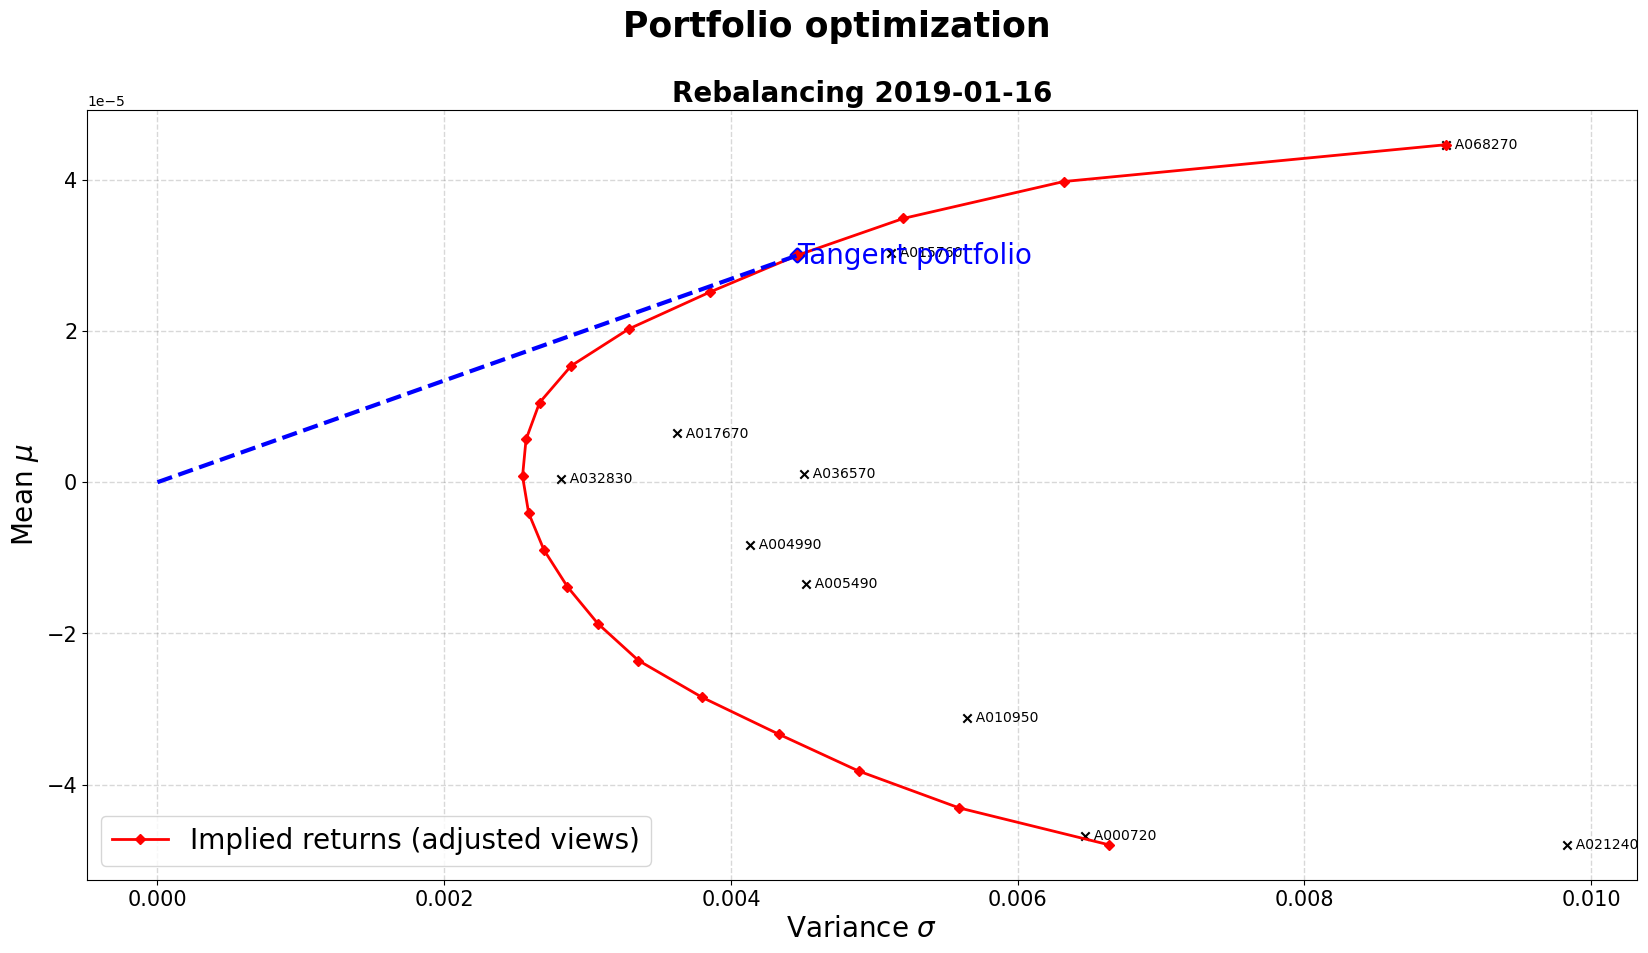

100%|██████████| 60/60 [00:02<00:00, 21.32it/s, Epoch=5/5, mse_loss=0.012]  


1


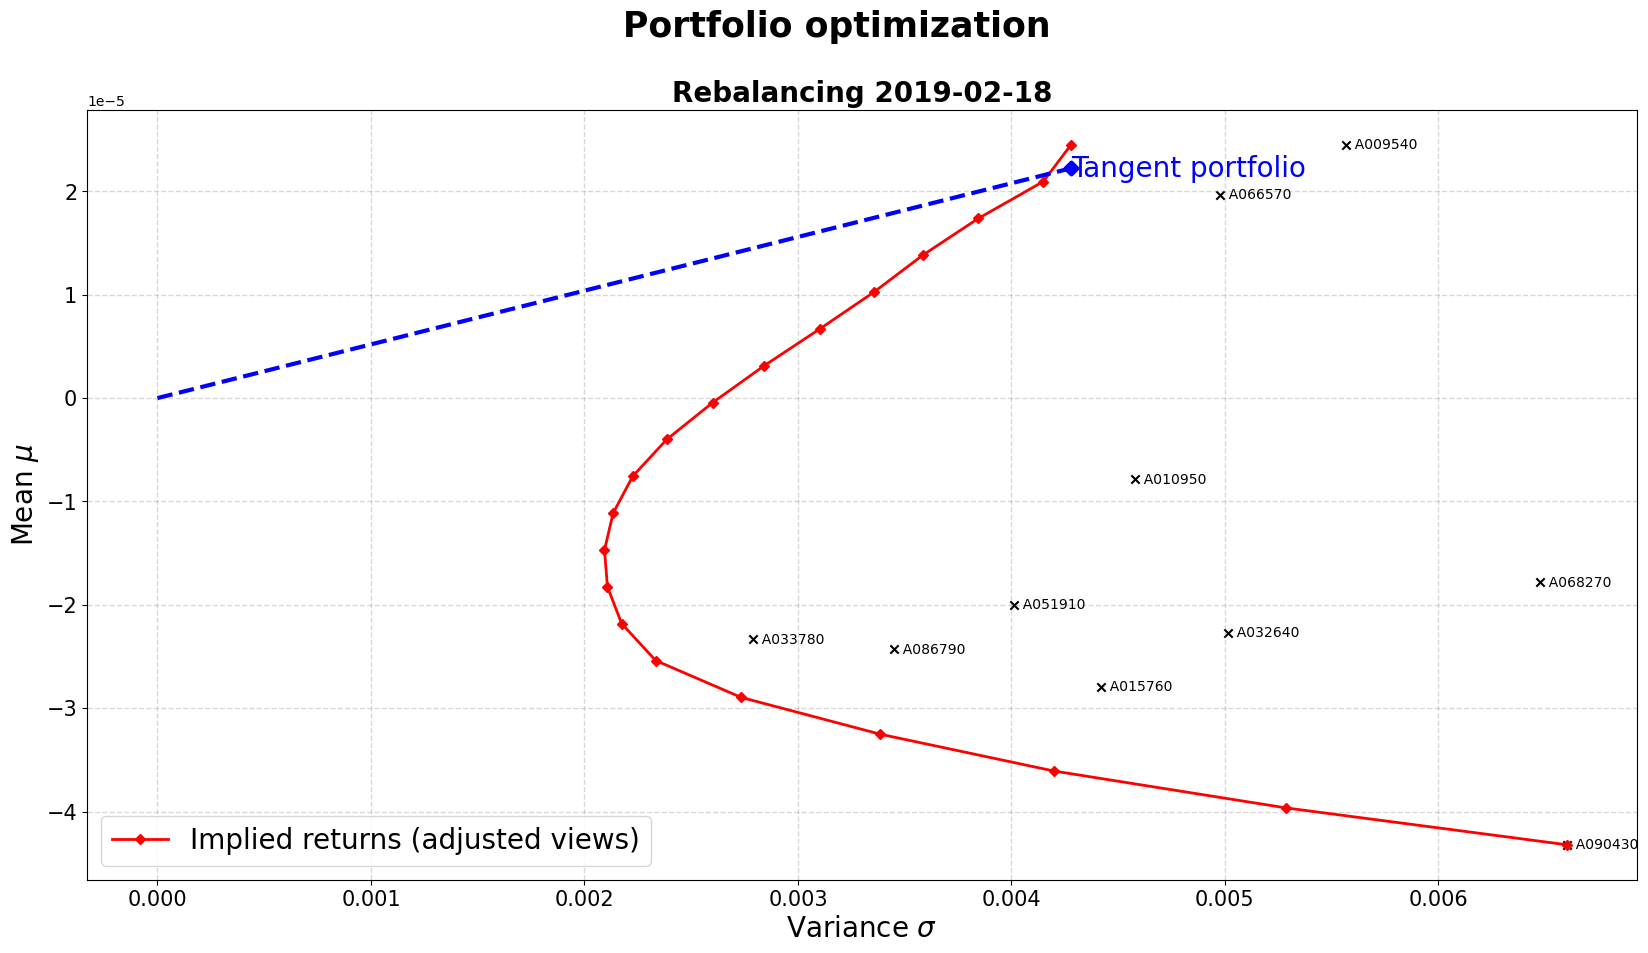

100%|██████████| 60/60 [00:02<00:00, 21.18it/s, Epoch=5/5, mse_loss=0.00585]


2


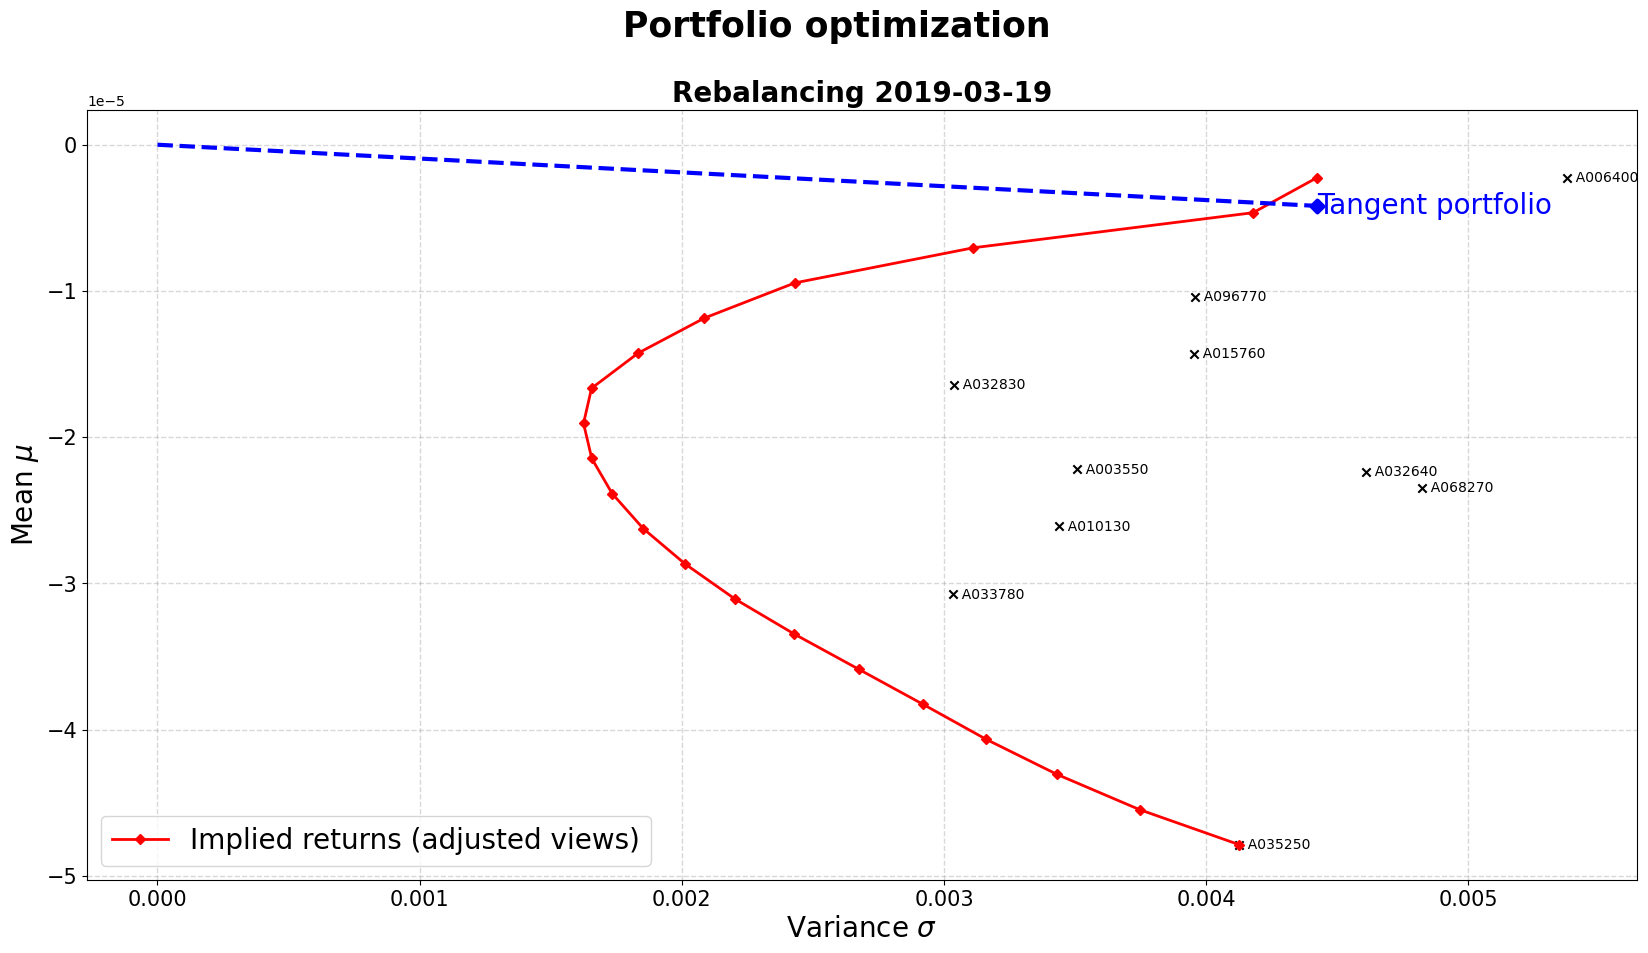

100%|██████████| 60/60 [00:02<00:00, 21.27it/s, Epoch=5/5, mse_loss=0.00345]


3


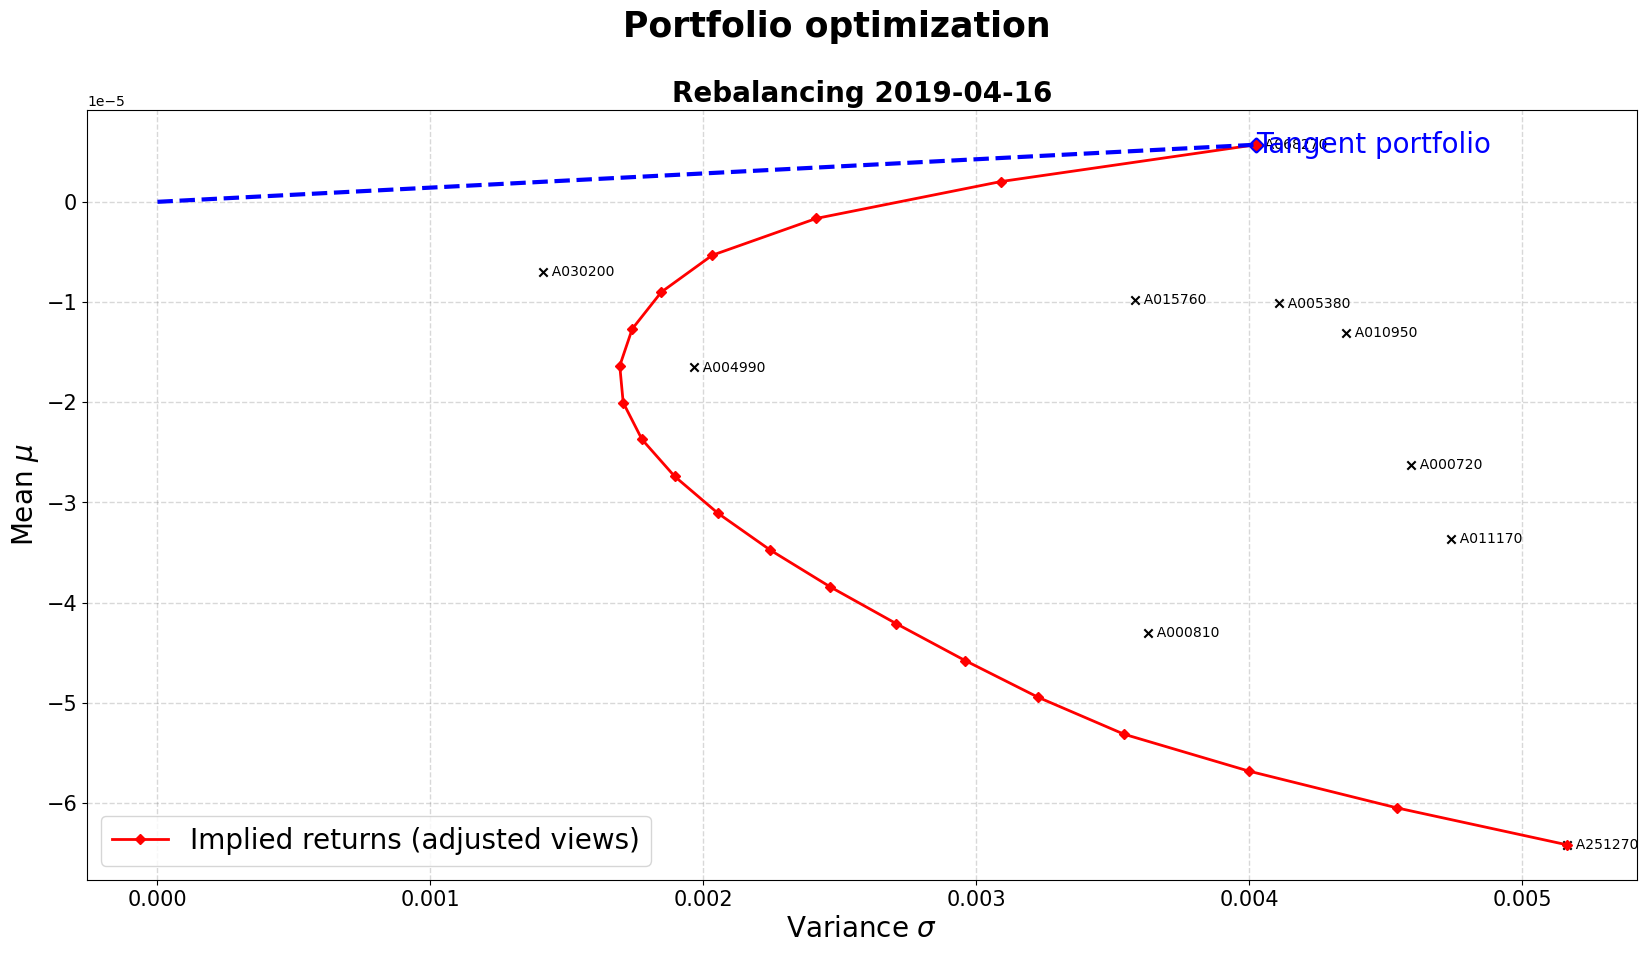

100%|██████████| 60/60 [00:02<00:00, 21.11it/s, Epoch=5/5, mse_loss=0.00298]


4


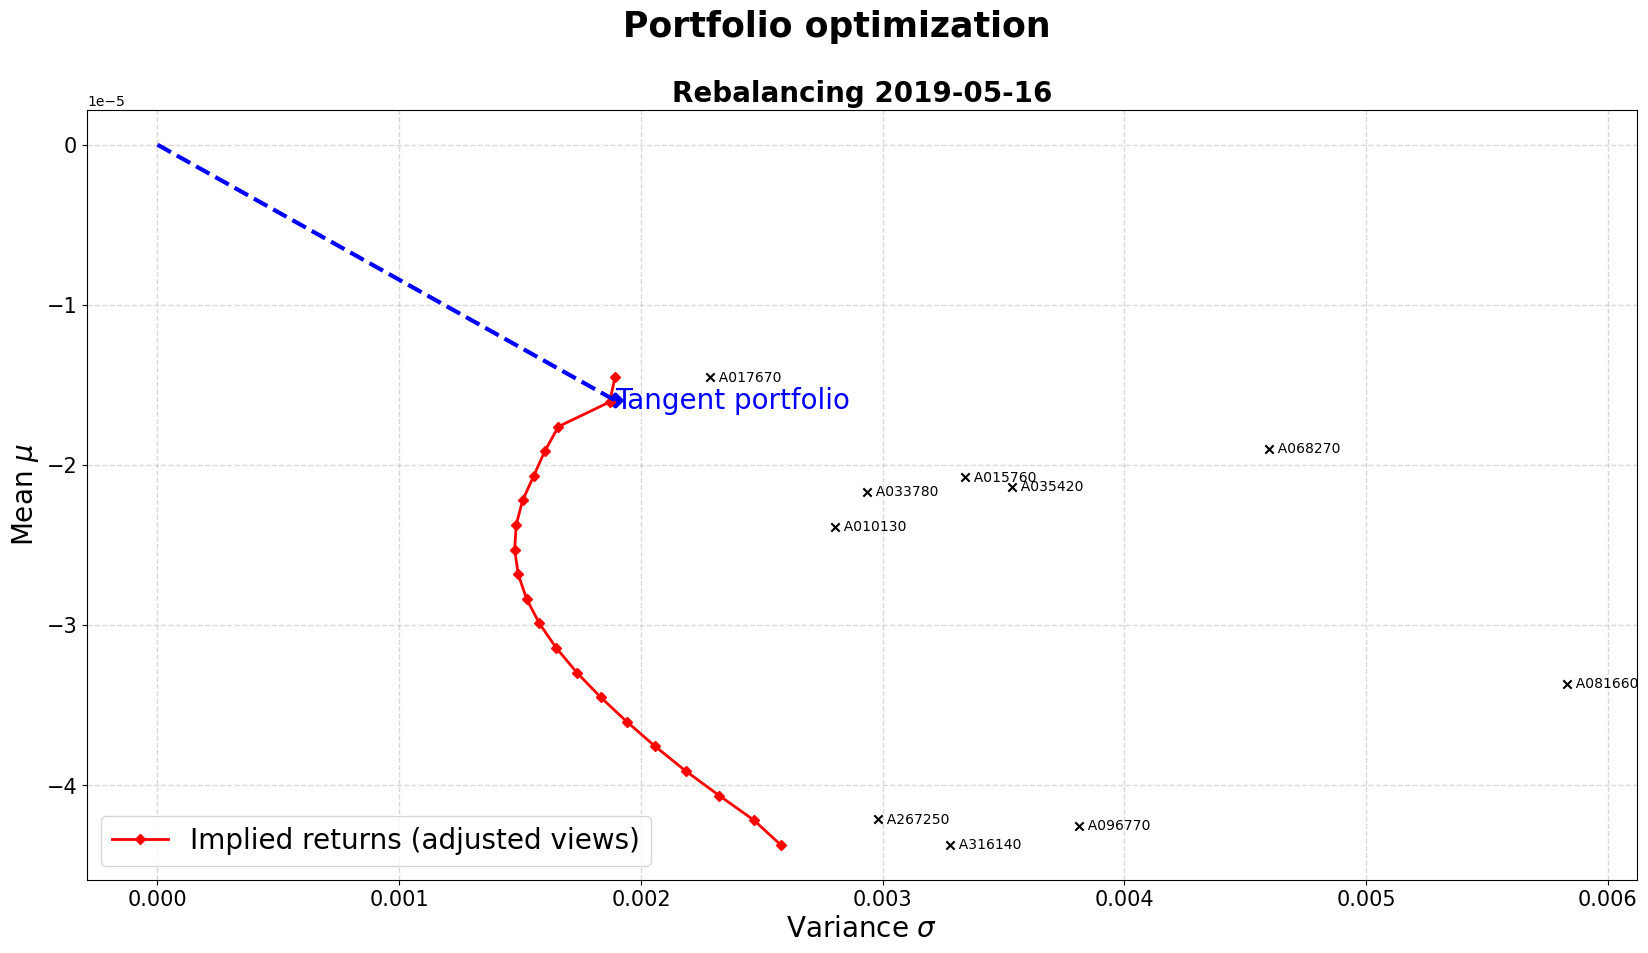

100%|██████████| 60/60 [00:02<00:00, 21.23it/s, Epoch=5/5, mse_loss=0.00433]


5


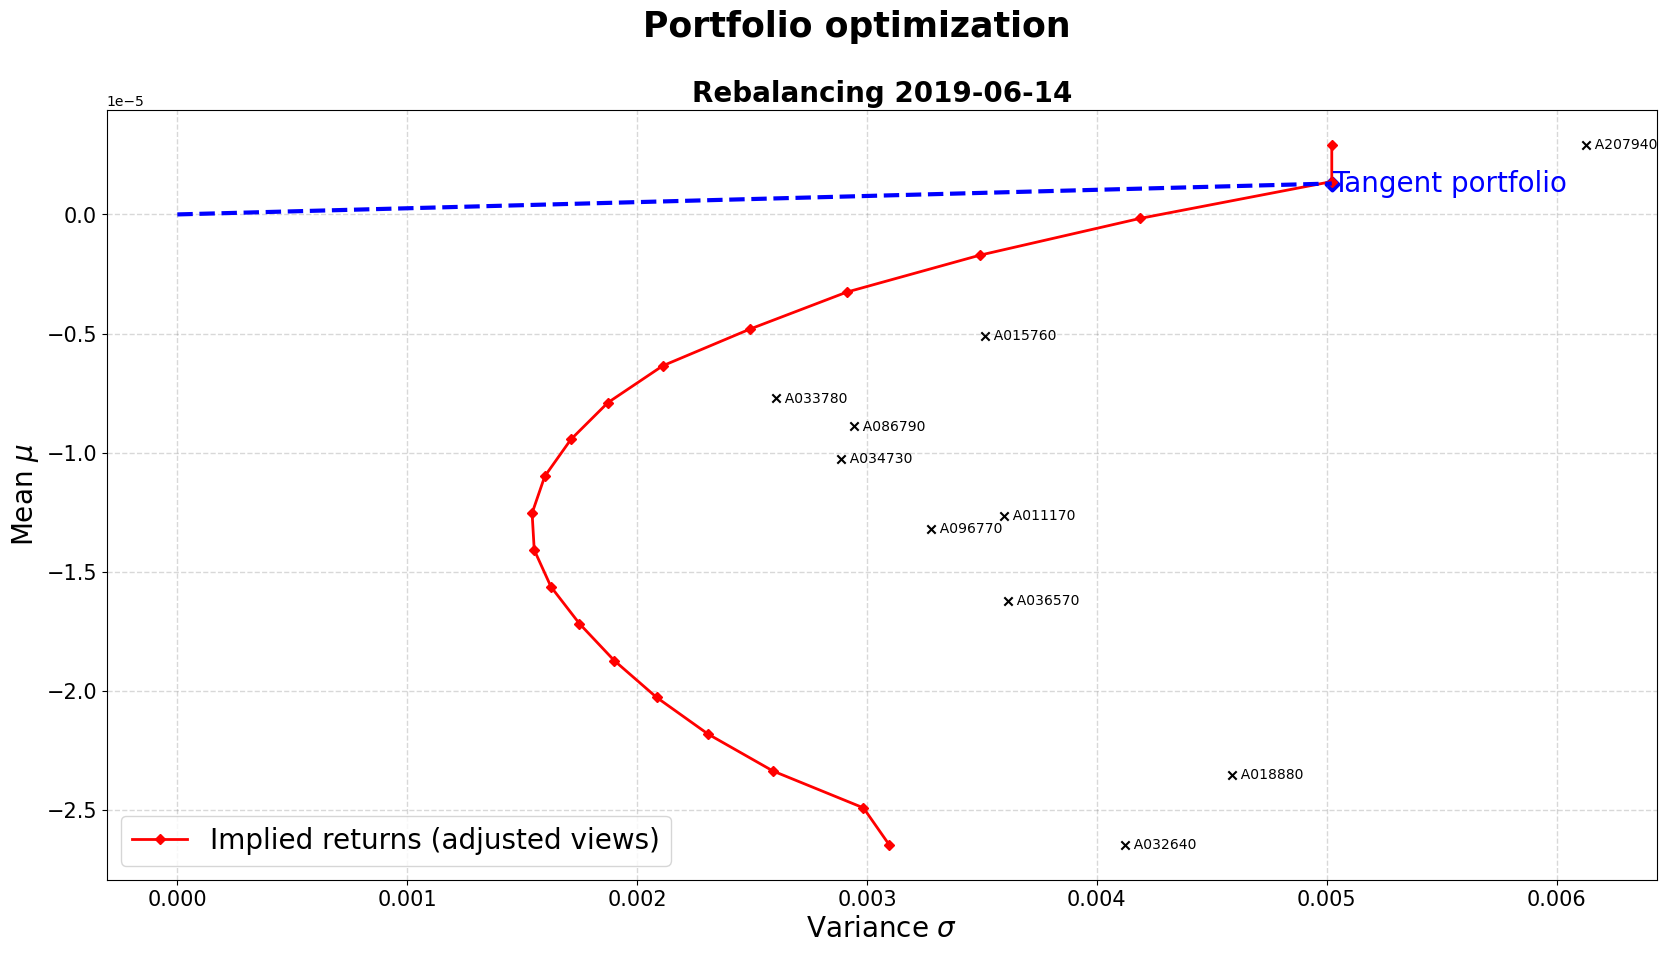

100%|██████████| 60/60 [00:02<00:00, 21.23it/s, Epoch=5/5, mse_loss=0.00156]


6


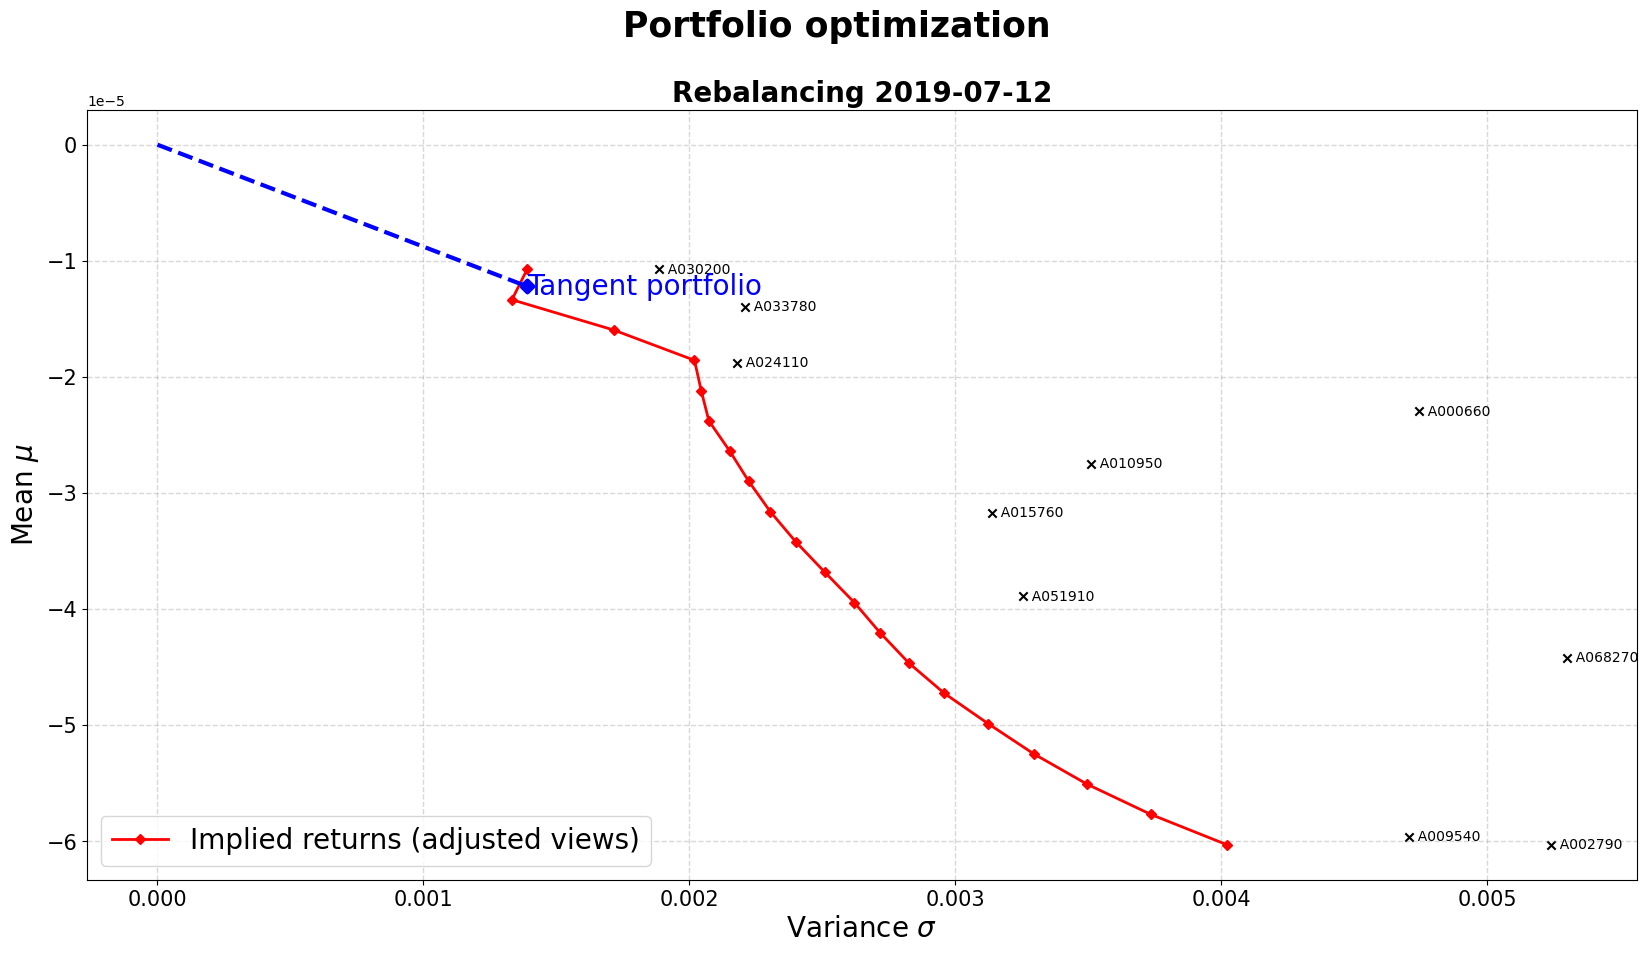

100%|██████████| 60/60 [00:02<00:00, 20.95it/s, Epoch=5/5, mse_loss=0.00368]


7


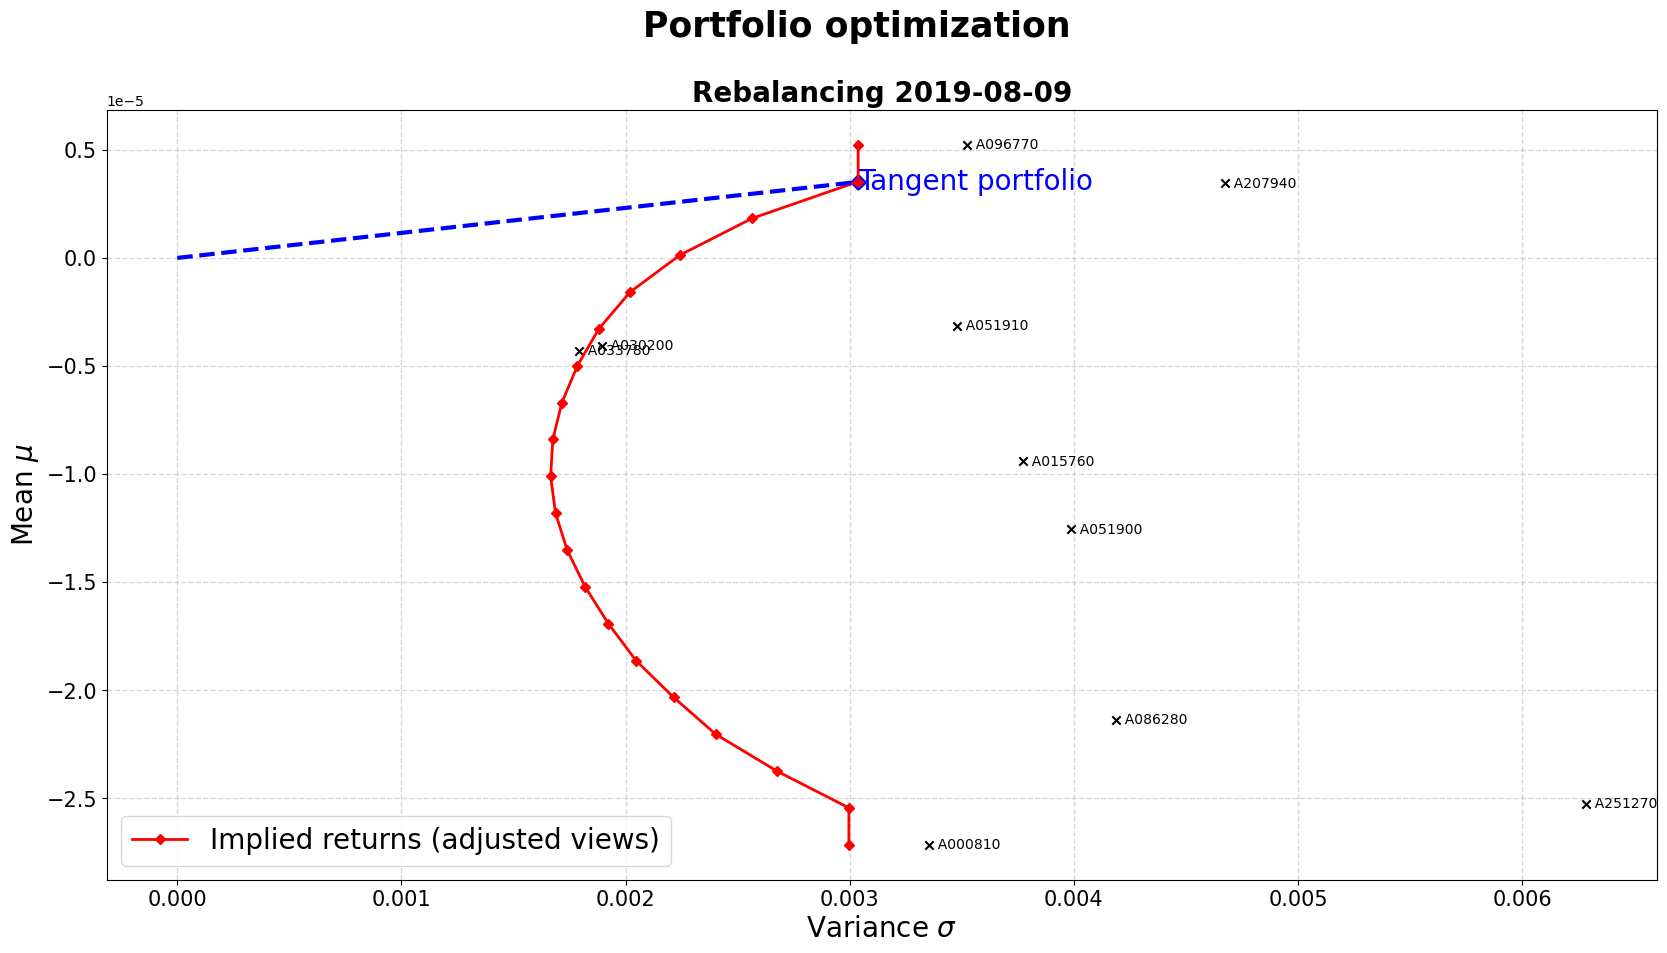

100%|██████████| 60/60 [00:02<00:00, 21.76it/s, Epoch=5/5, mse_loss=0.00642]


8


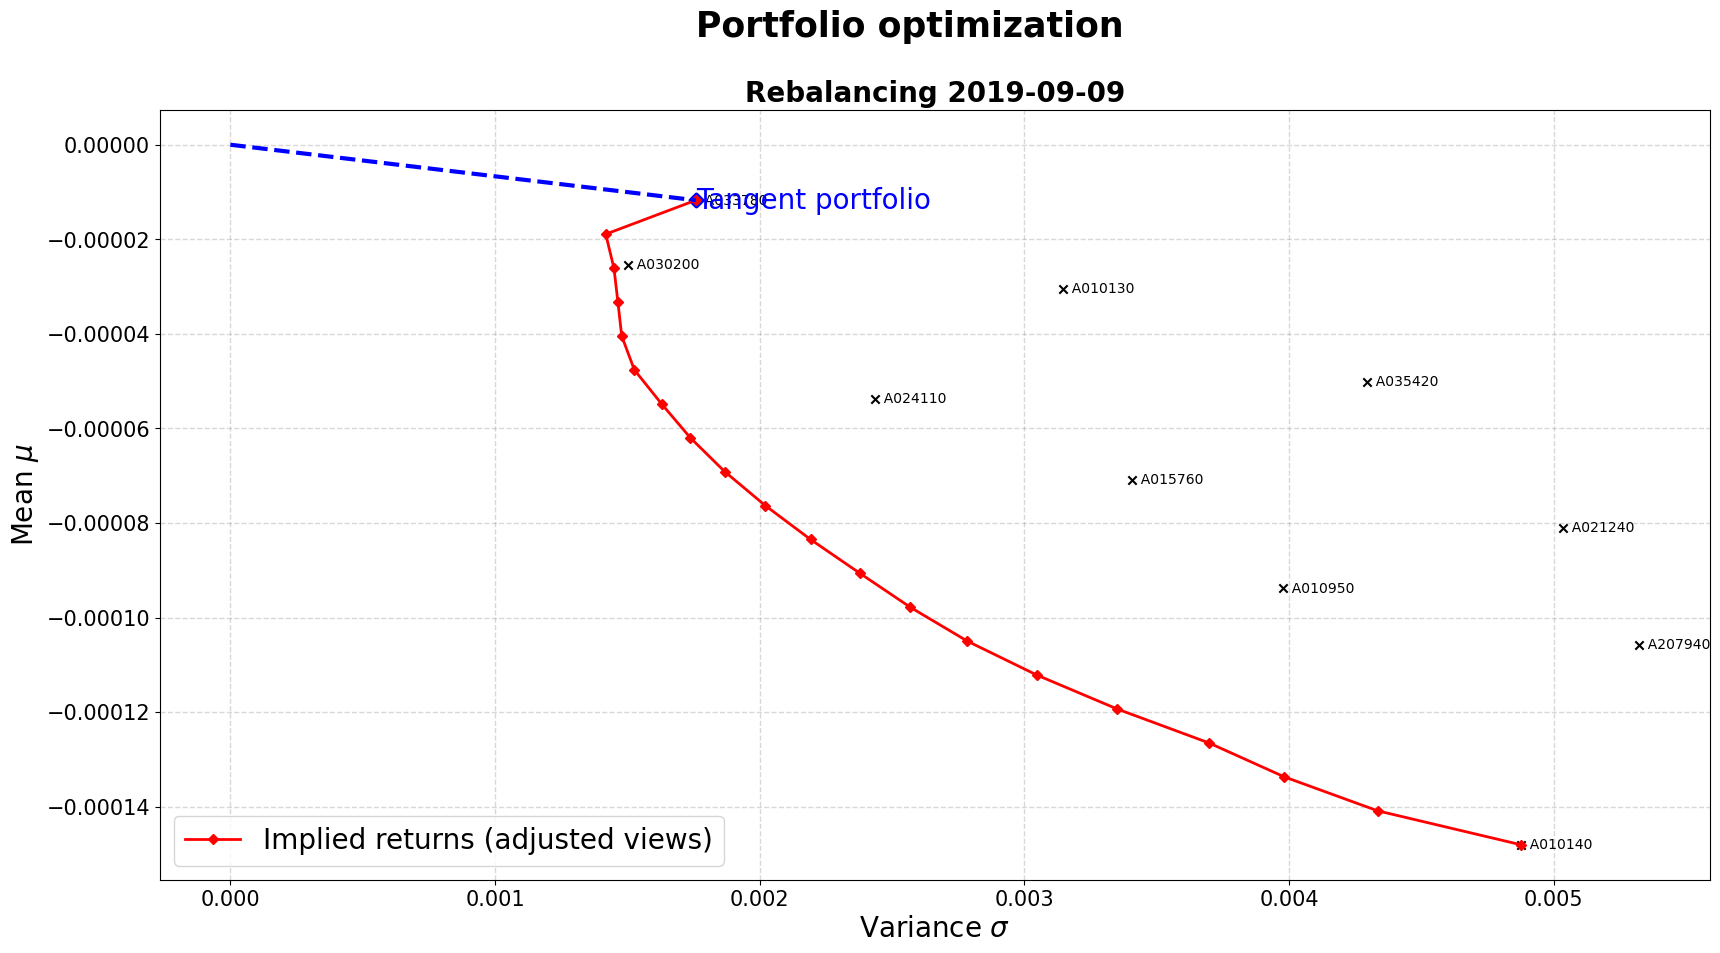

100%|██████████| 60/60 [00:02<00:00, 21.59it/s, Epoch=5/5, mse_loss=0.00555]


9


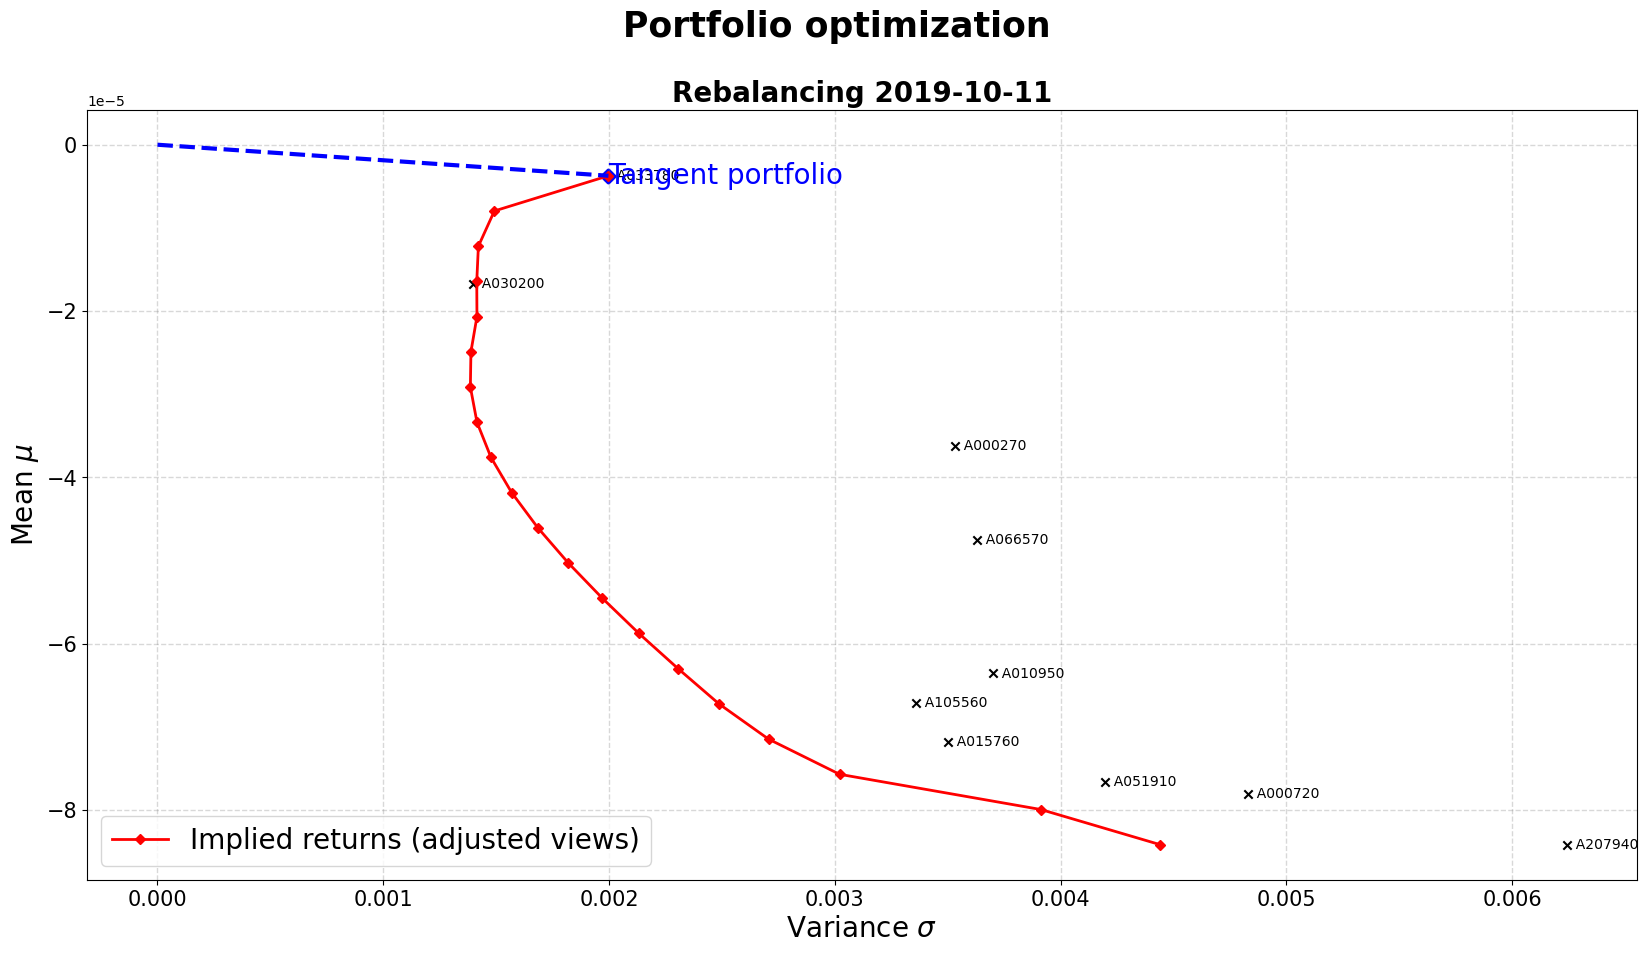

100%|██████████| 60/60 [00:02<00:00, 21.64it/s, Epoch=5/5, mse_loss=0.0071] 


10


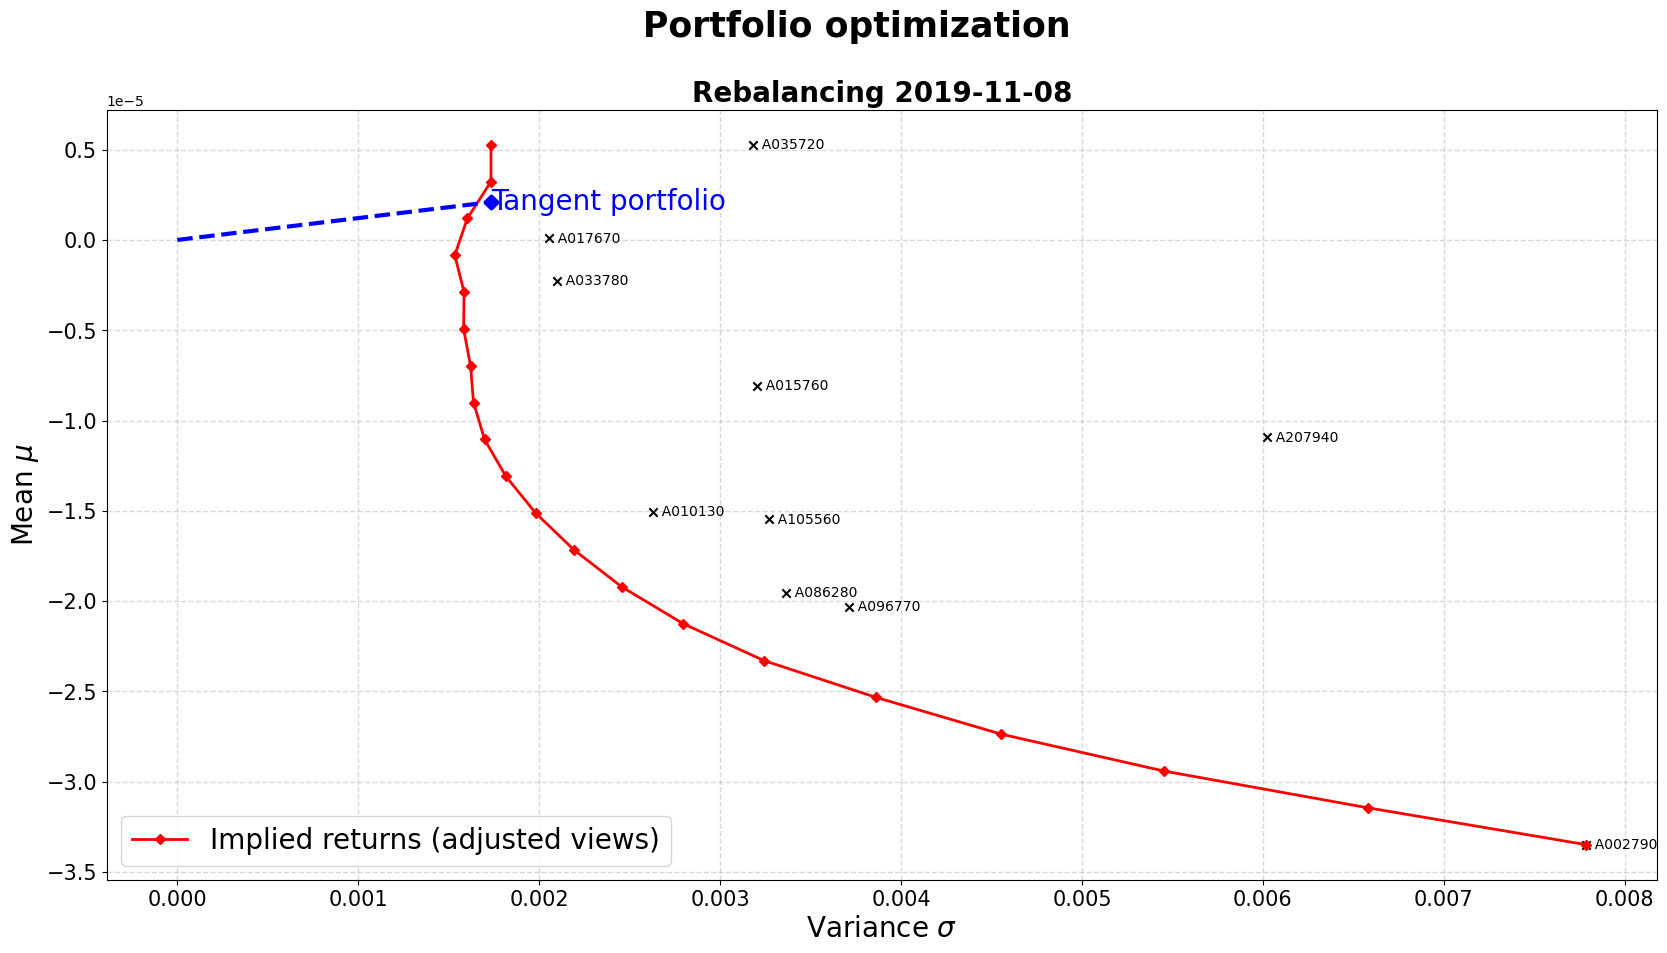

100%|██████████| 60/60 [00:02<00:00, 21.95it/s, Epoch=5/5, mse_loss=0.00558]


11


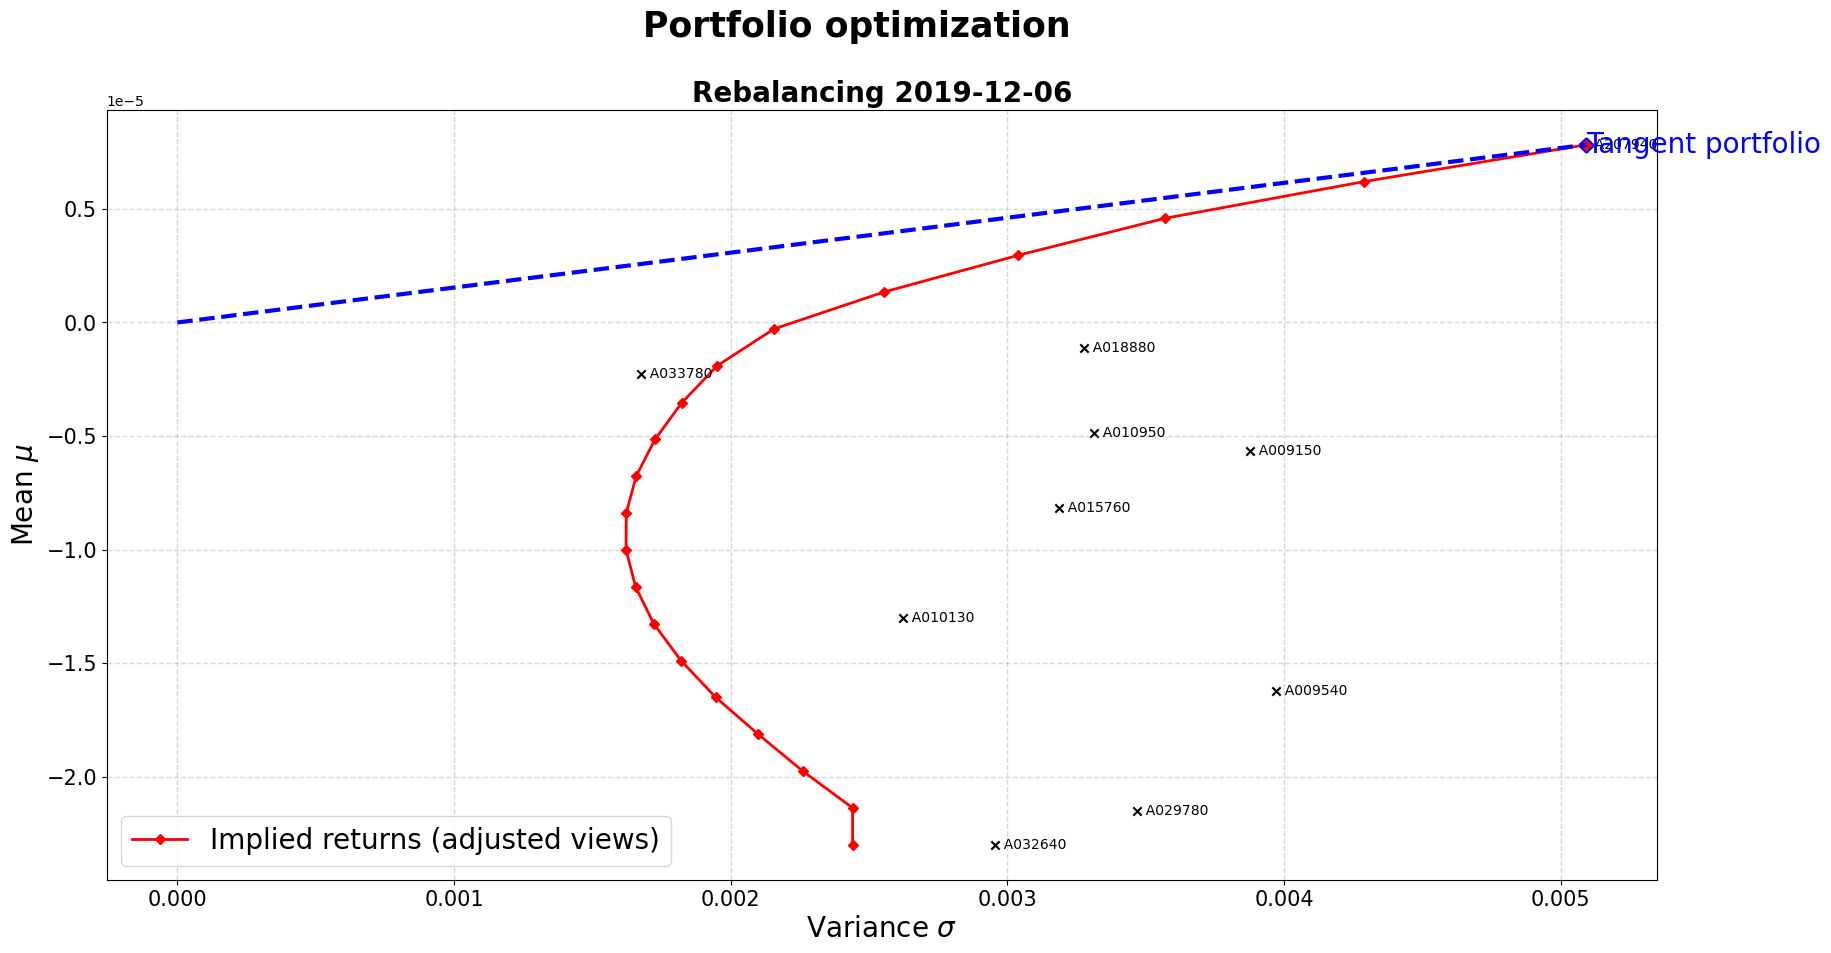

100%|██████████| 60/60 [00:02<00:00, 21.09it/s, Epoch=5/5, mse_loss=0.00654]


12


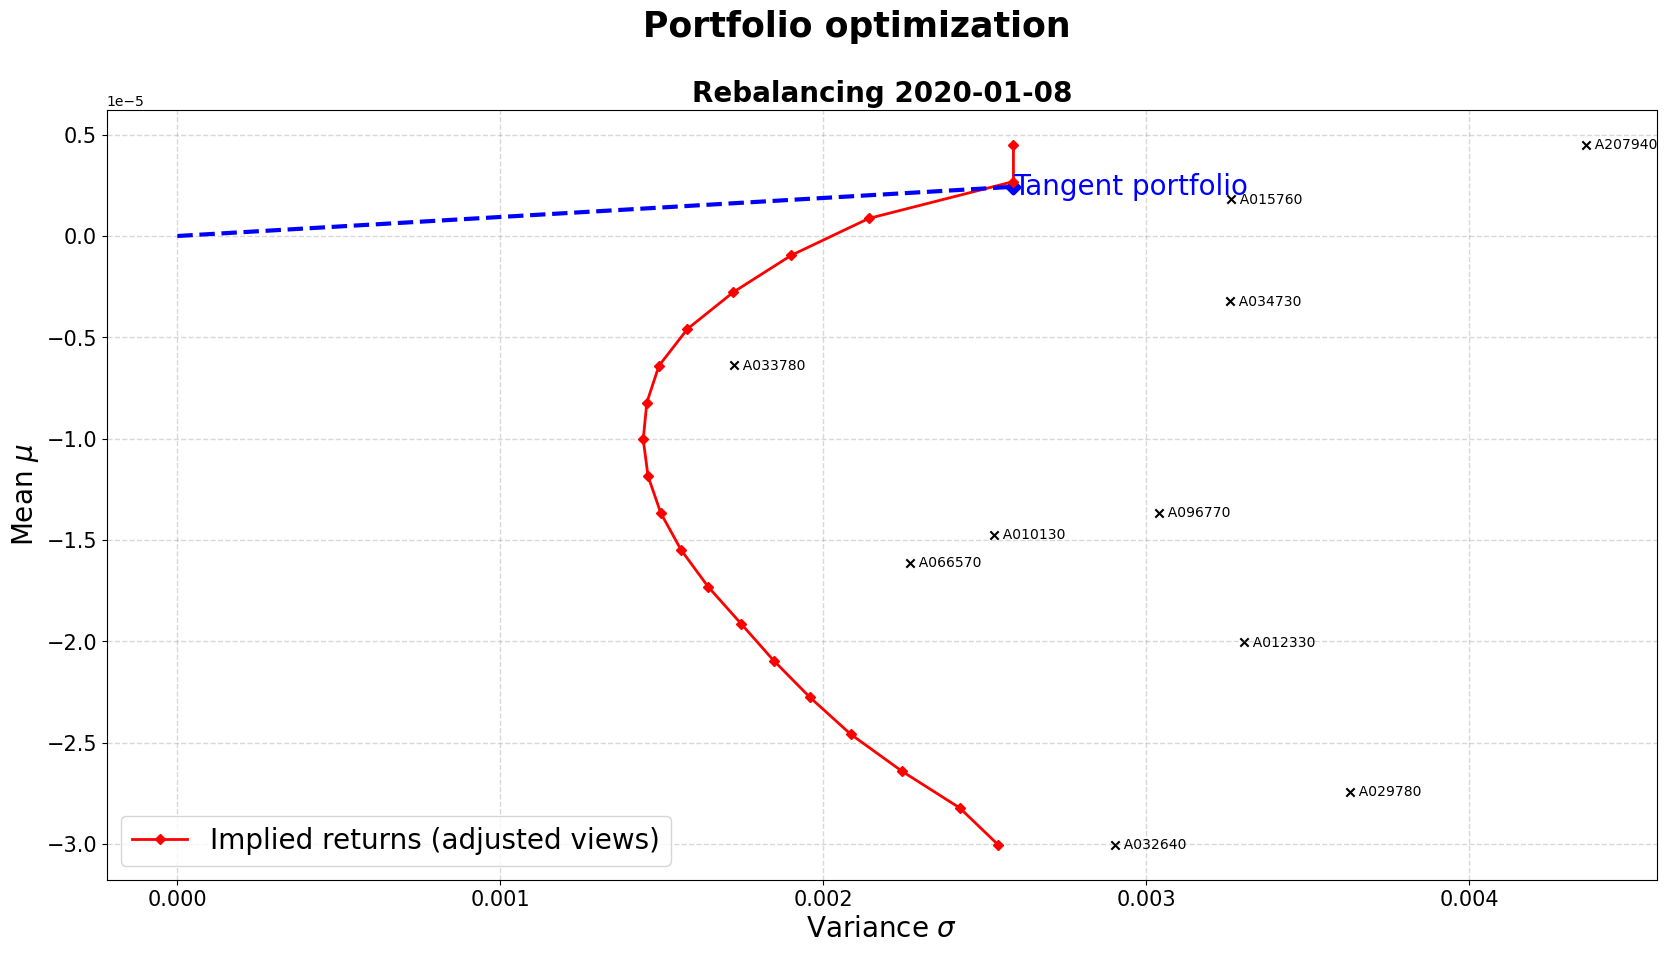

100%|██████████| 60/60 [00:02<00:00, 21.24it/s, Epoch=5/5, mse_loss=0.00257]


13


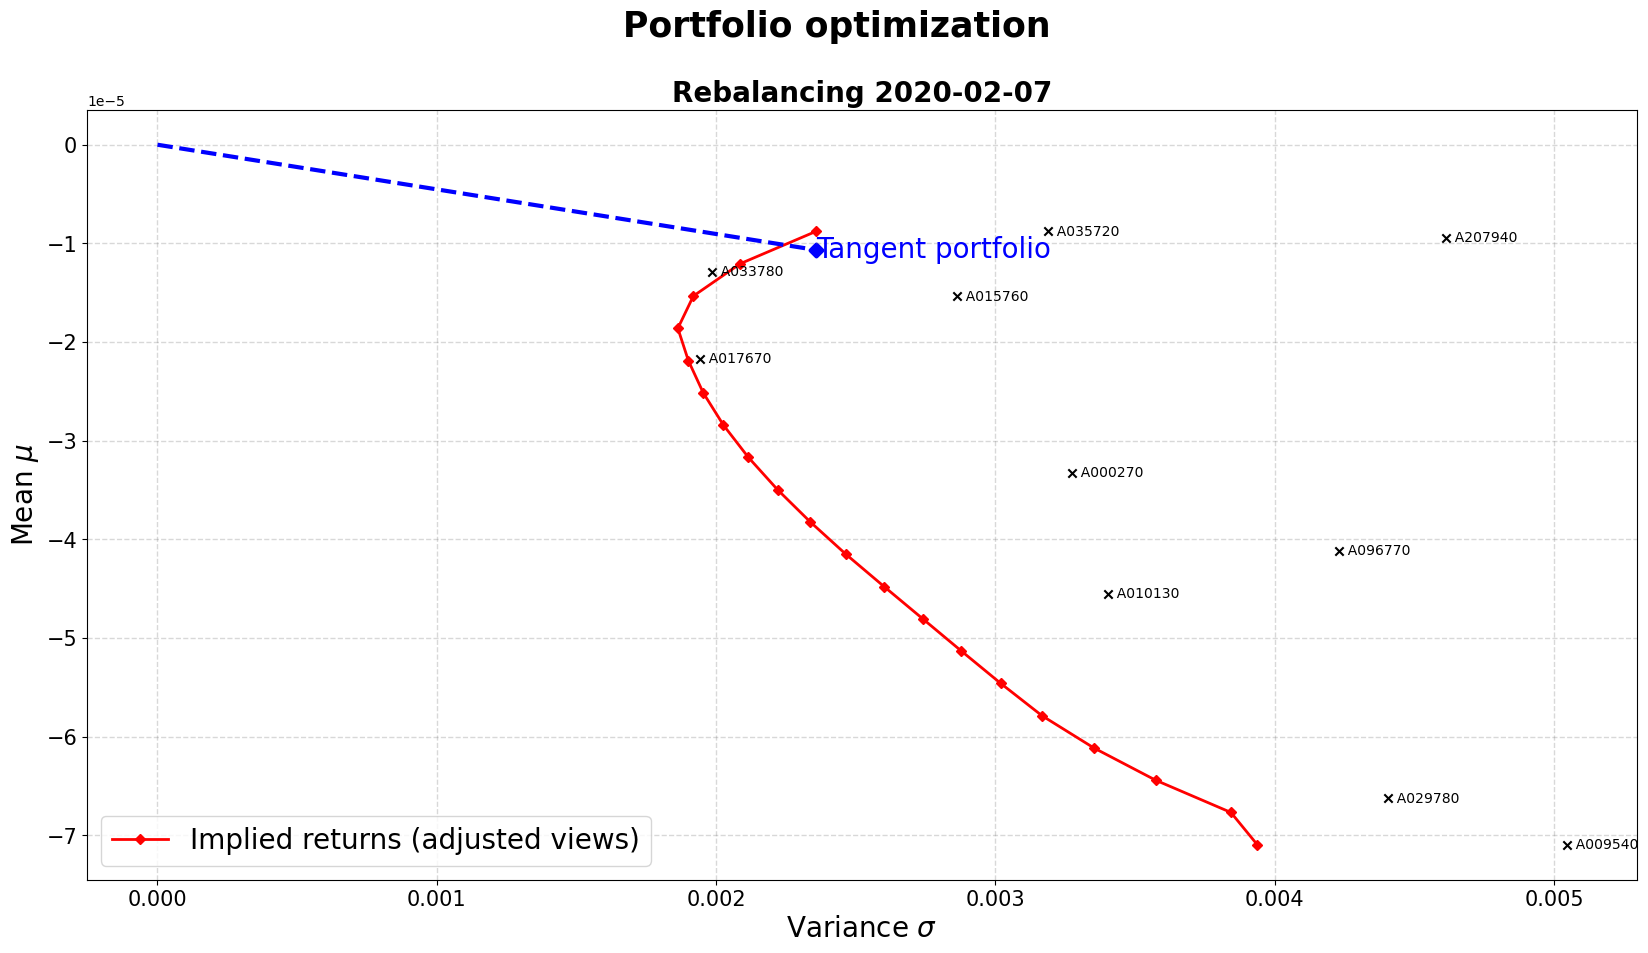

100%|██████████| 60/60 [00:02<00:00, 21.23it/s, Epoch=5/5, mse_loss=0.00599]


14


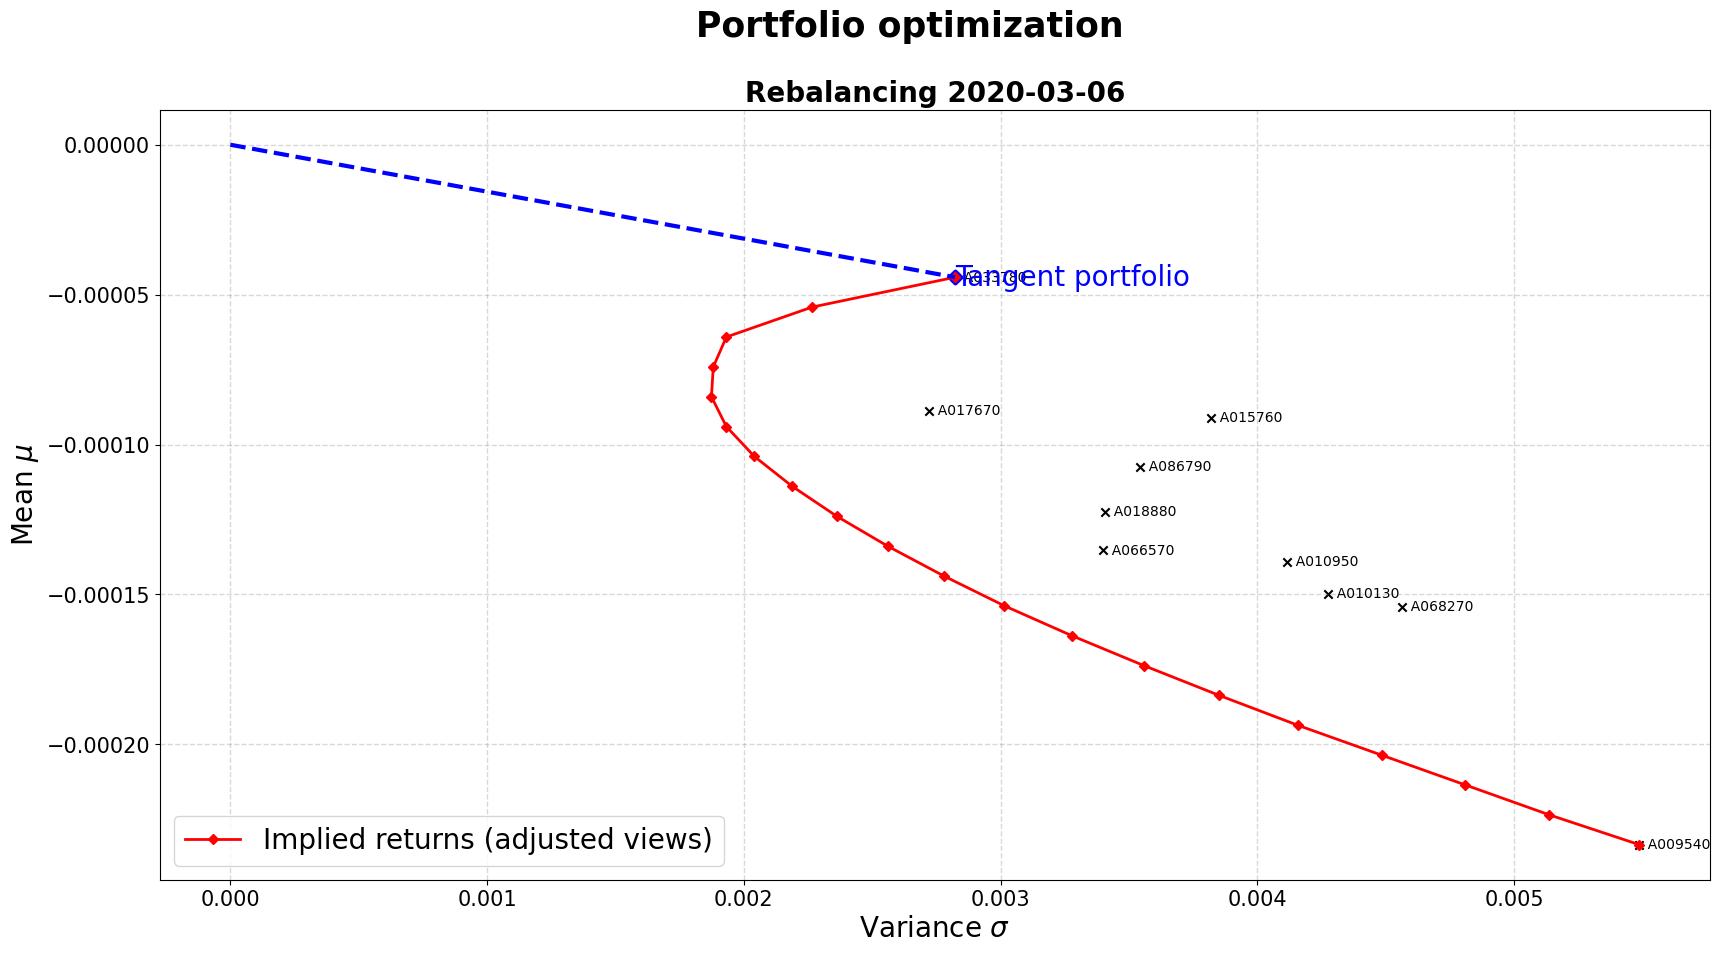

100%|██████████| 60/60 [00:02<00:00, 20.83it/s, Epoch=5/5, mse_loss=0.00467]


15


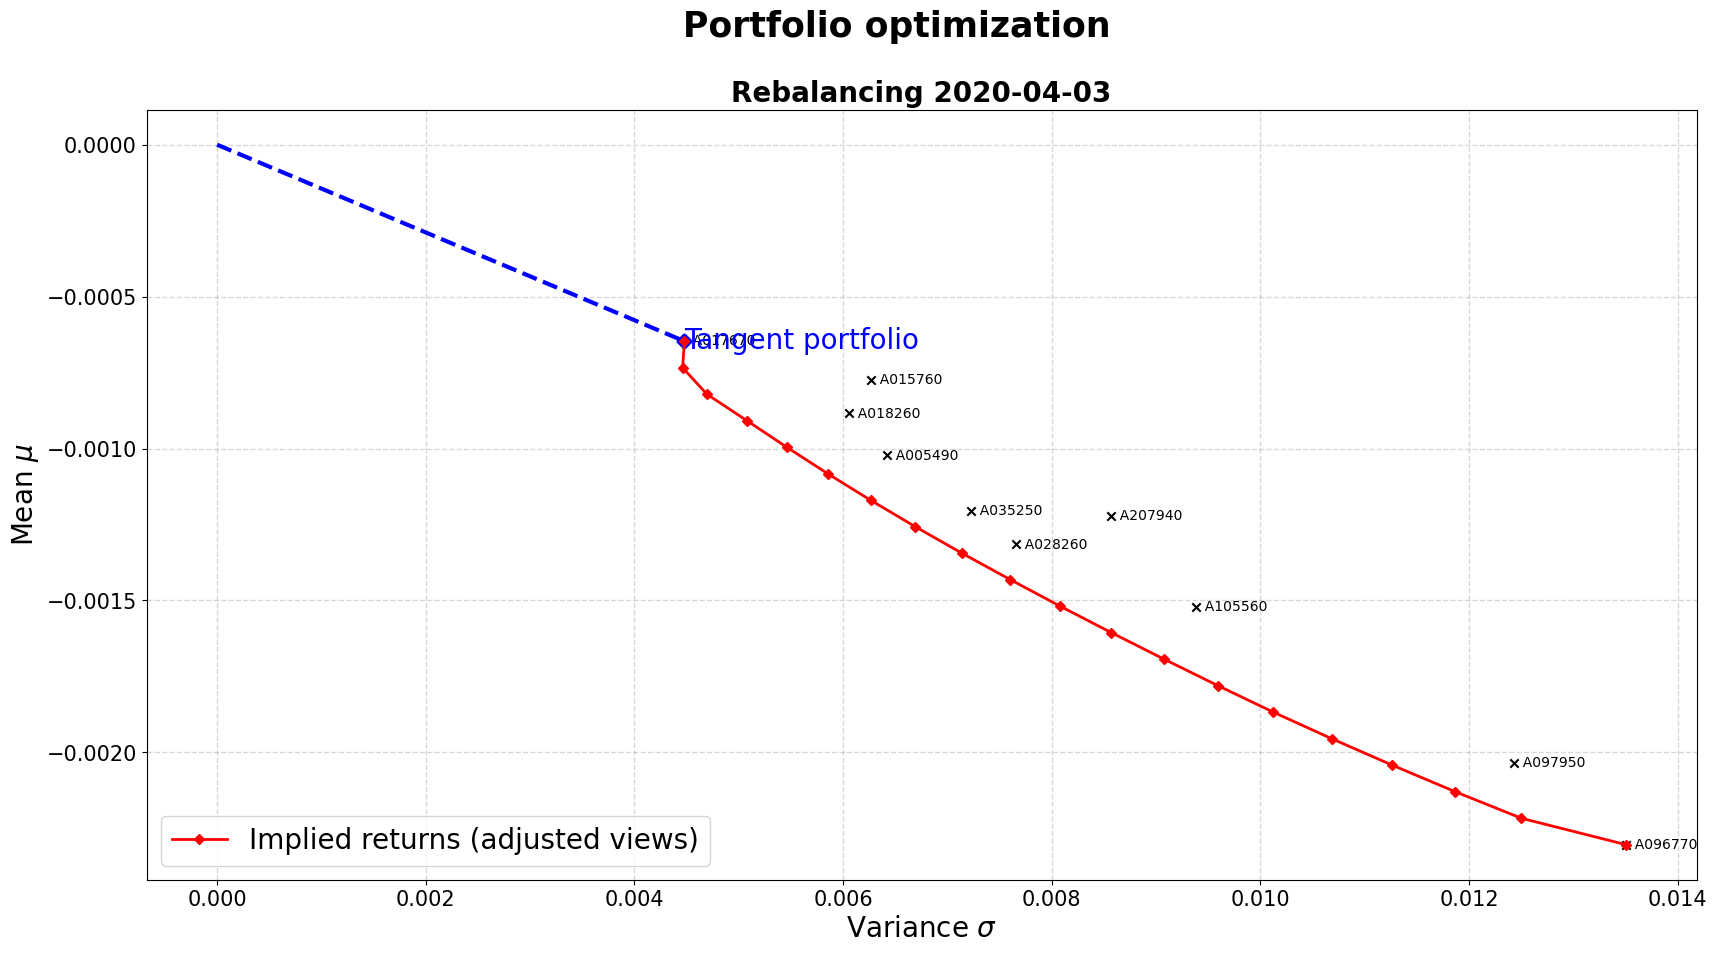

100%|██████████| 60/60 [00:02<00:00, 21.07it/s, Epoch=5/5, mse_loss=0.0138] 


16


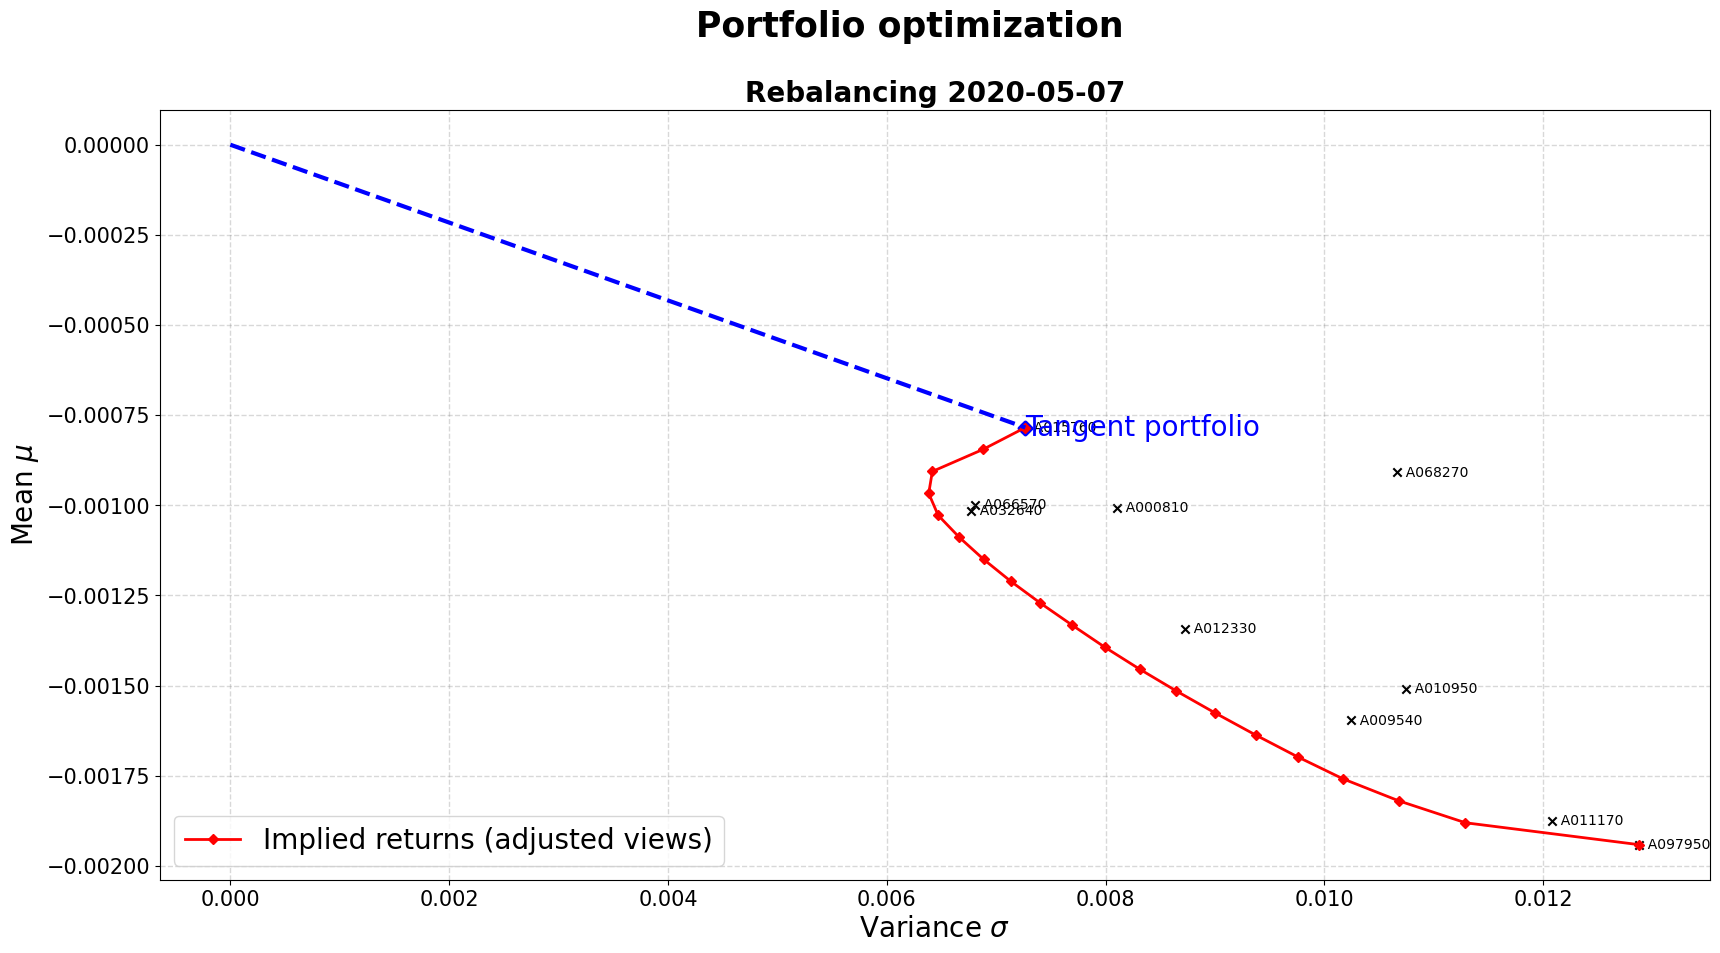

100%|██████████| 60/60 [00:02<00:00, 21.57it/s, Epoch=5/5, mse_loss=0.0234] 


17


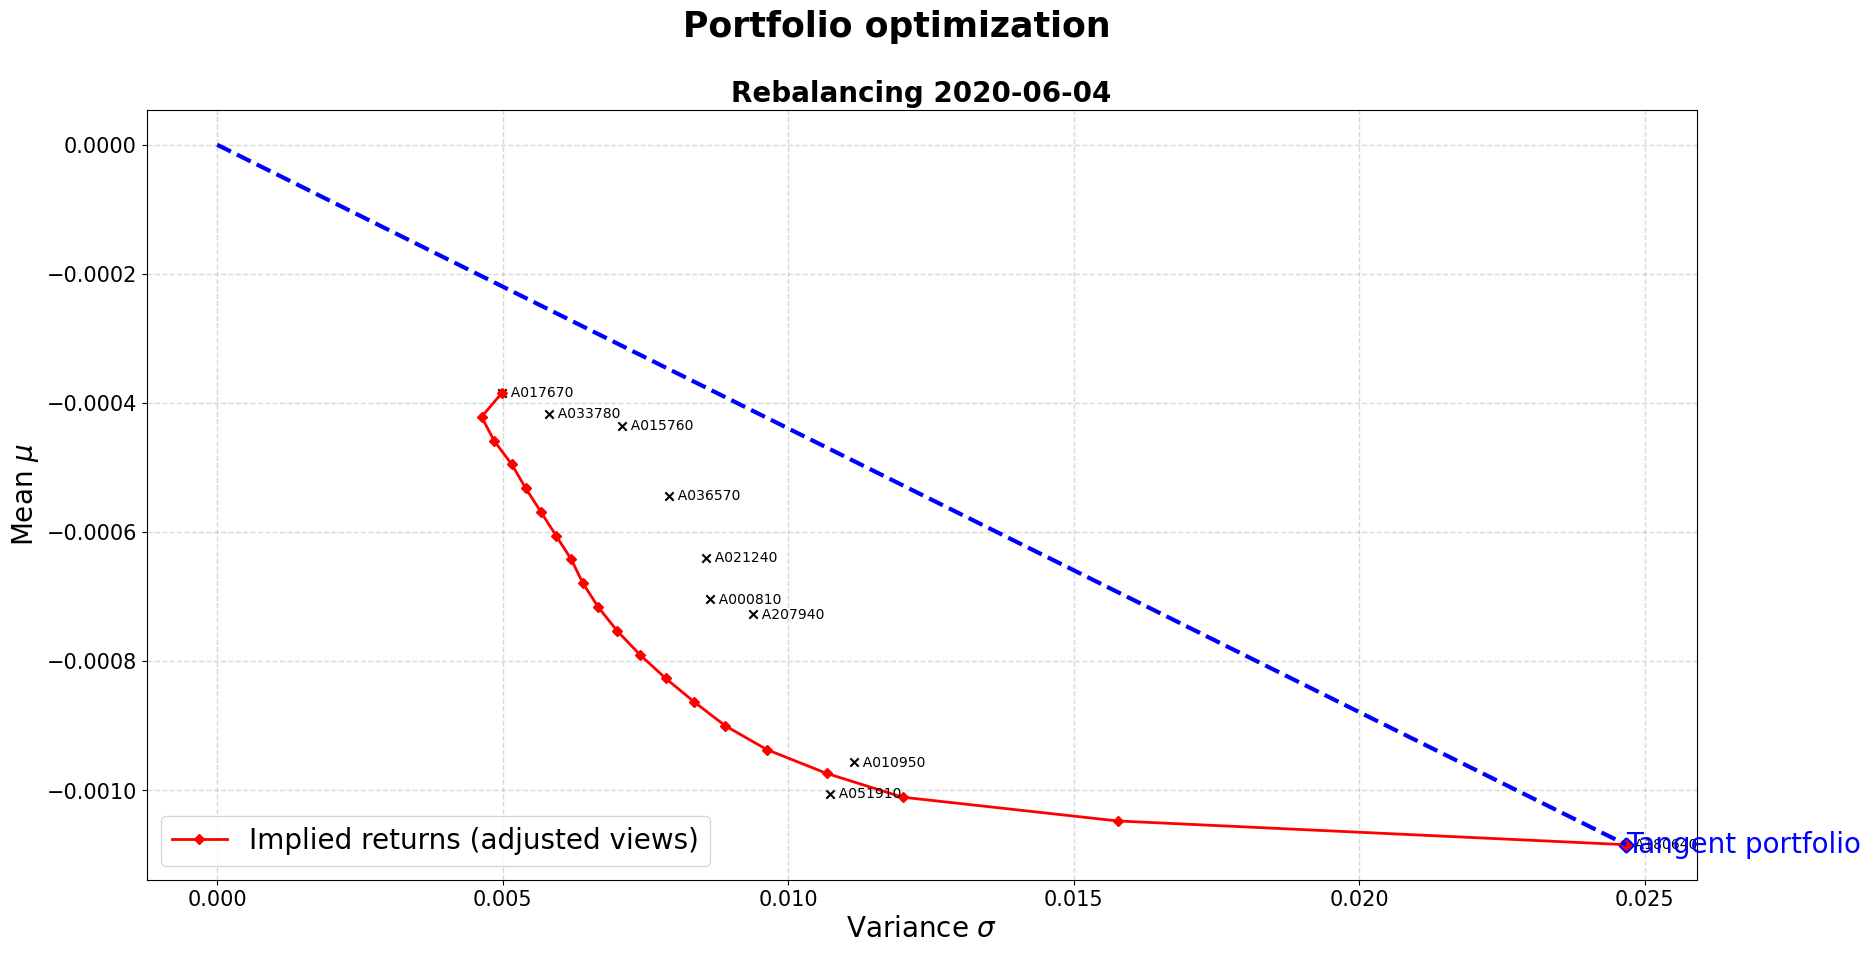

100%|██████████| 60/60 [00:02<00:00, 21.23it/s, Epoch=5/5, mse_loss=0.0174] 


18


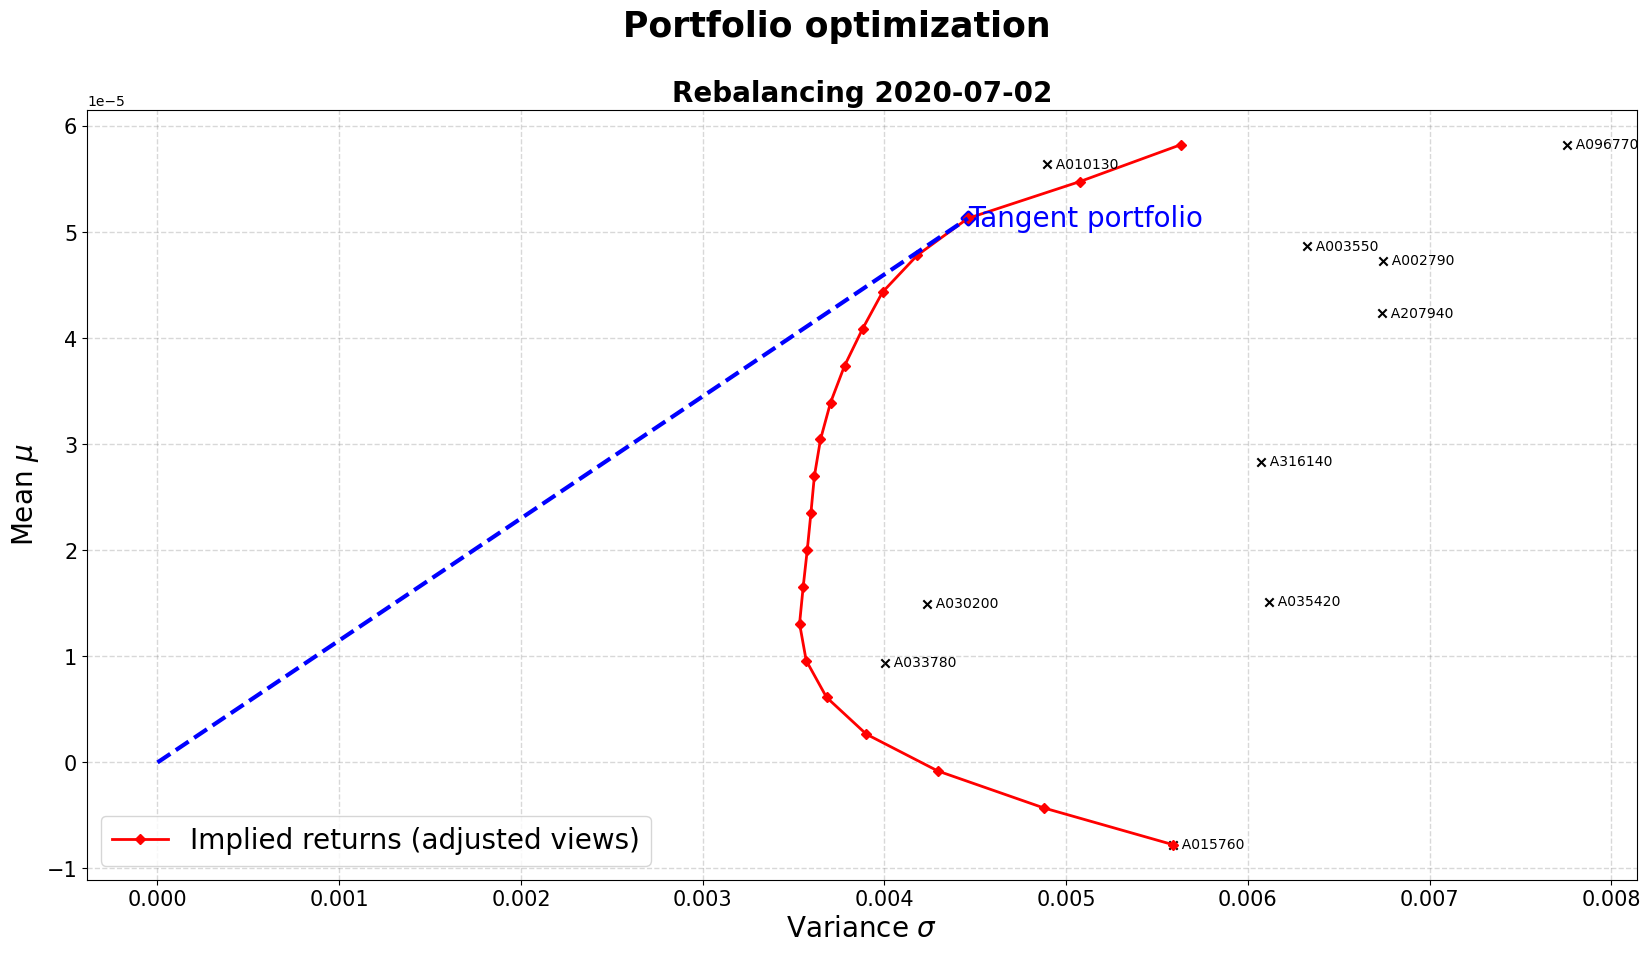

100%|██████████| 60/60 [00:02<00:00, 21.92it/s, Epoch=5/5, mse_loss=0.0183] 


19


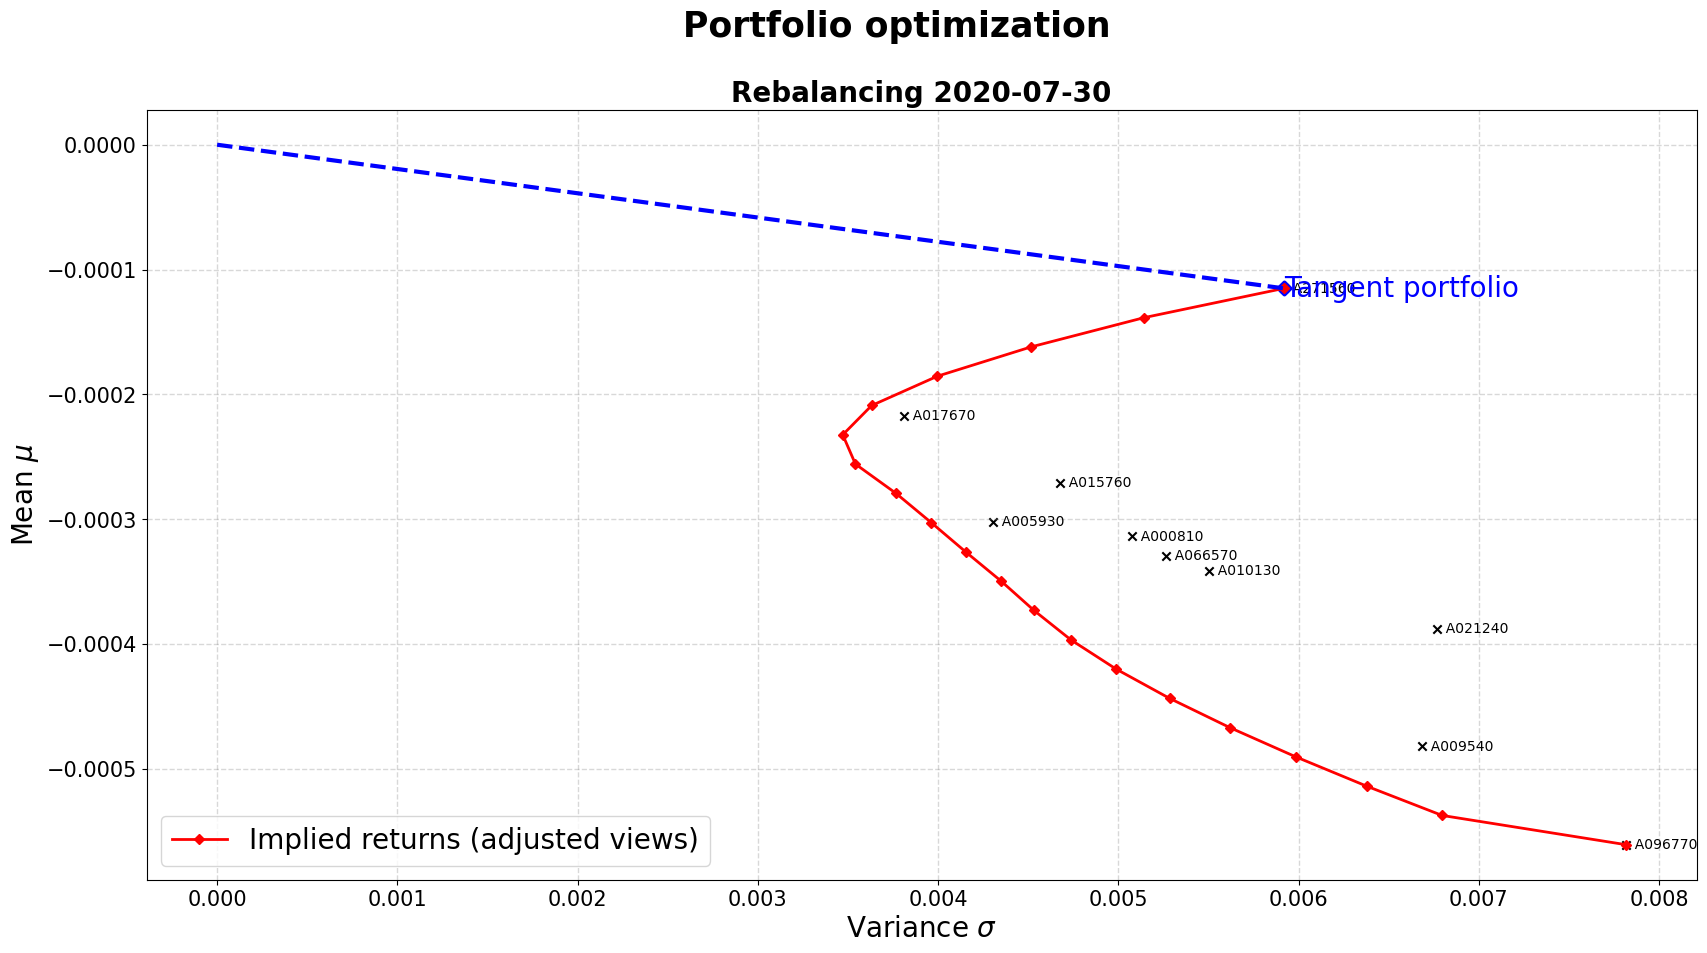

100%|██████████| 60/60 [00:02<00:00, 21.42it/s, Epoch=5/5, mse_loss=0.00713]


20


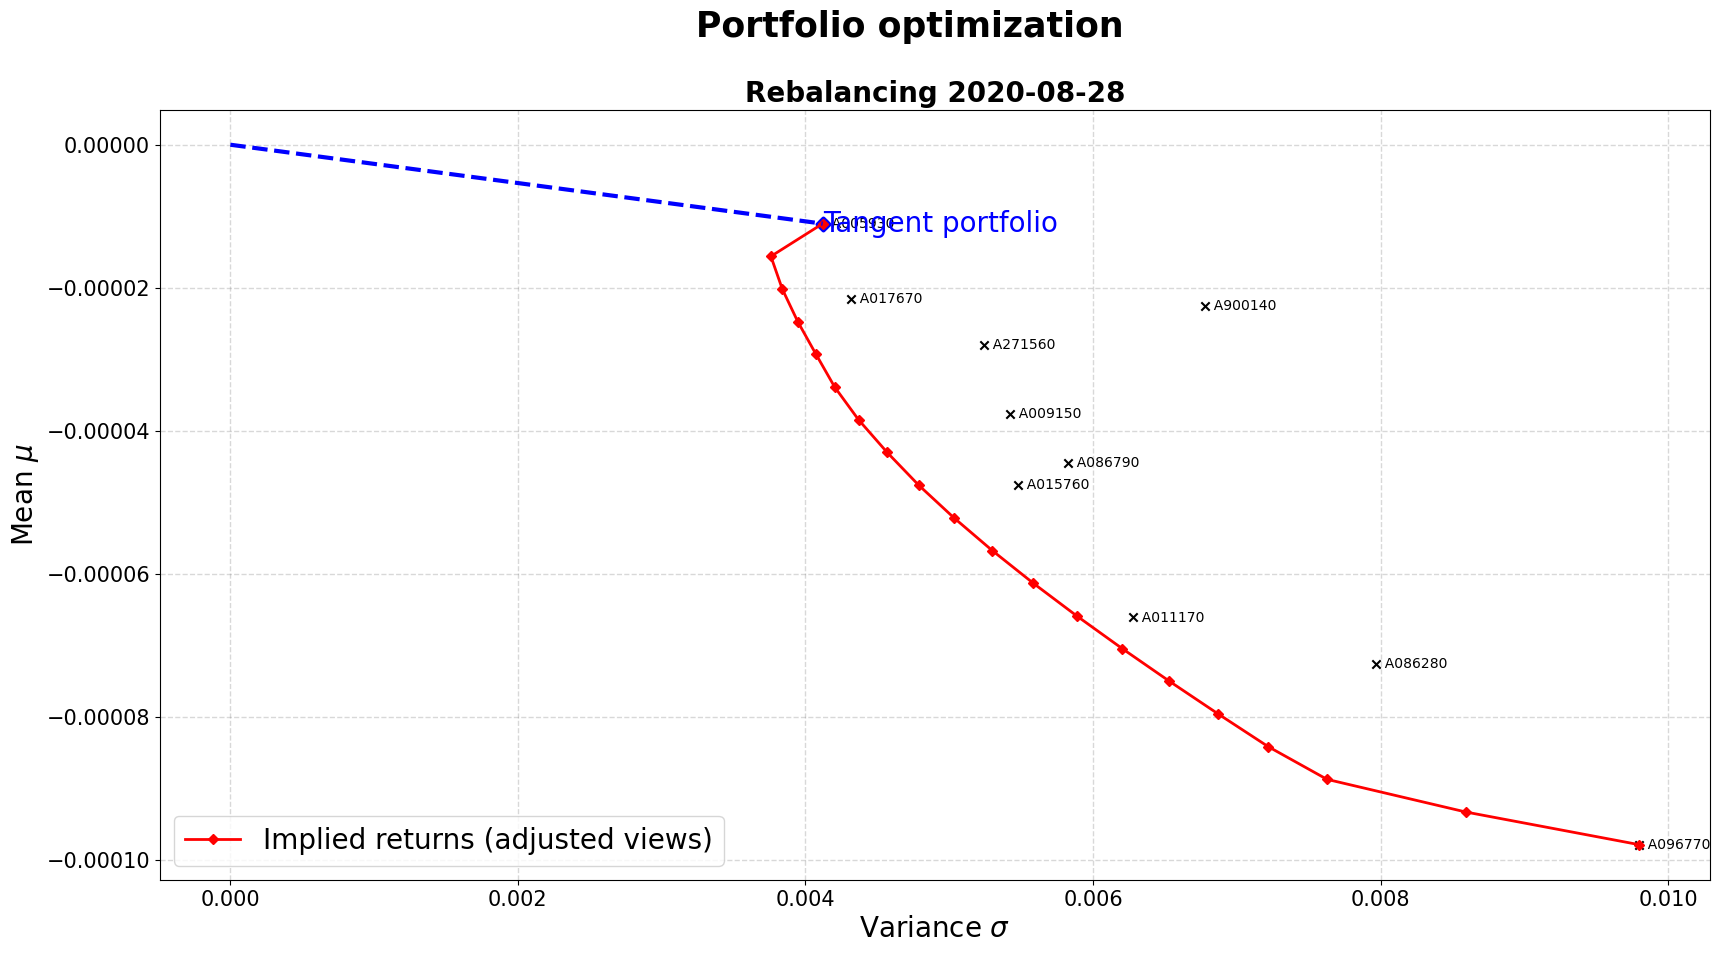

100%|██████████| 60/60 [00:02<00:00, 21.41it/s, Epoch=5/5, mse_loss=0.0106] 


21


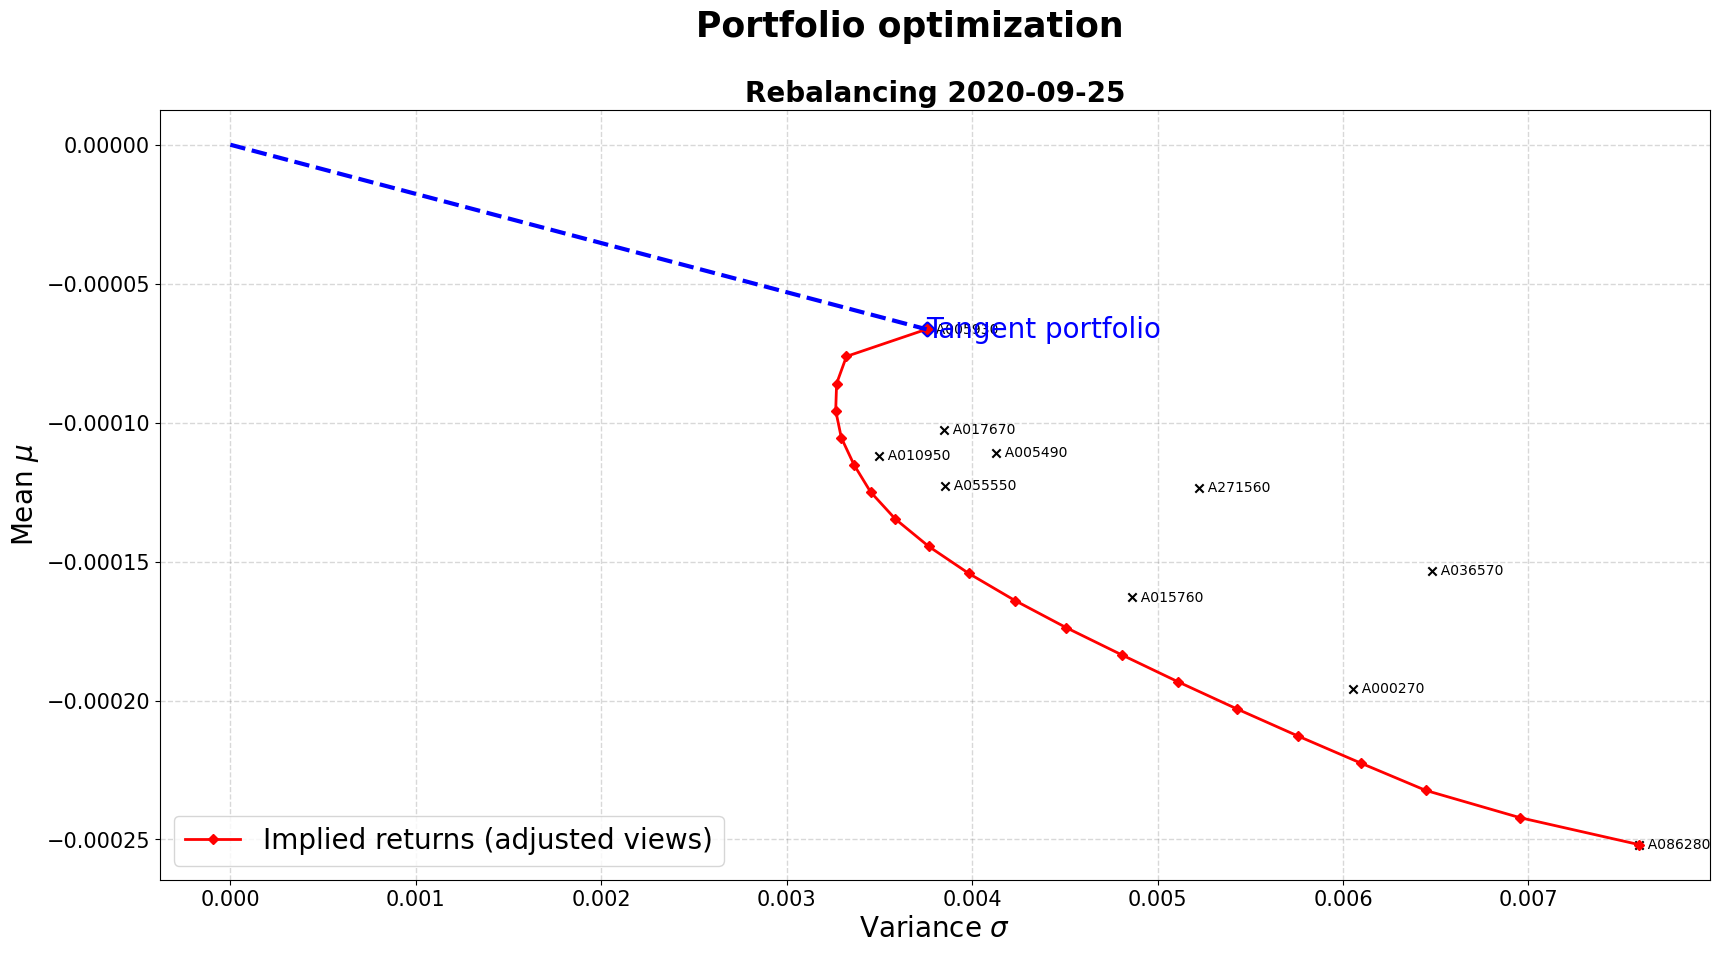

100%|██████████| 60/60 [00:02<00:00, 21.63it/s, Epoch=5/5, mse_loss=0.00436]


22


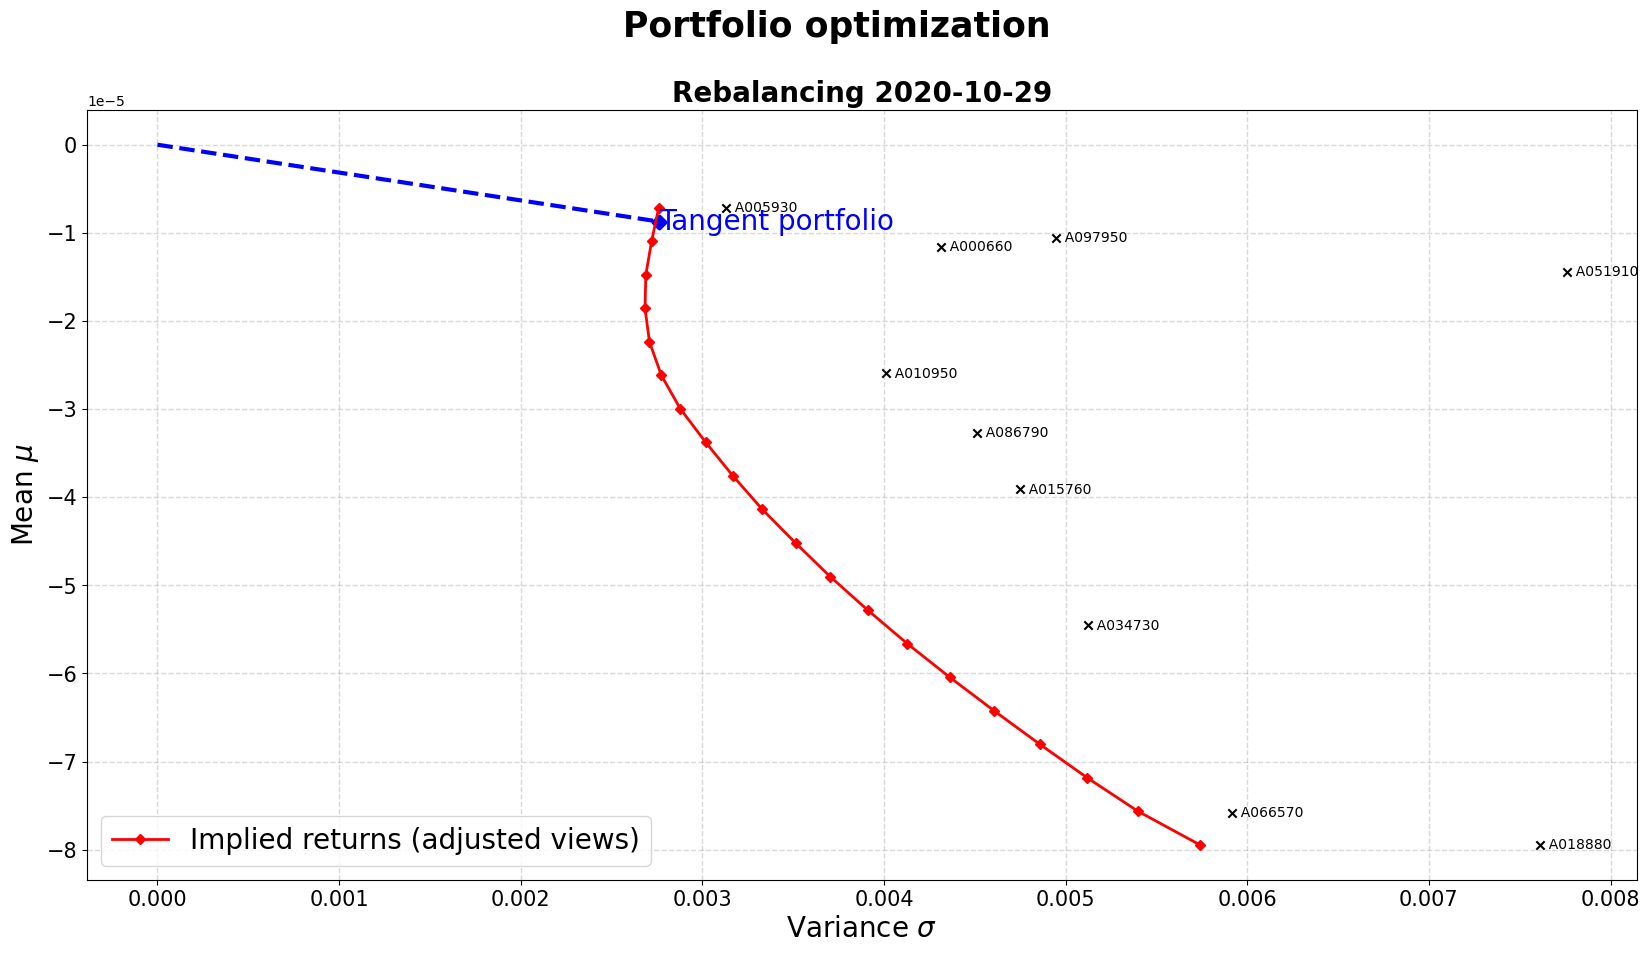

100%|██████████| 60/60 [00:02<00:00, 21.84it/s, Epoch=5/5, mse_loss=0.00366]


23


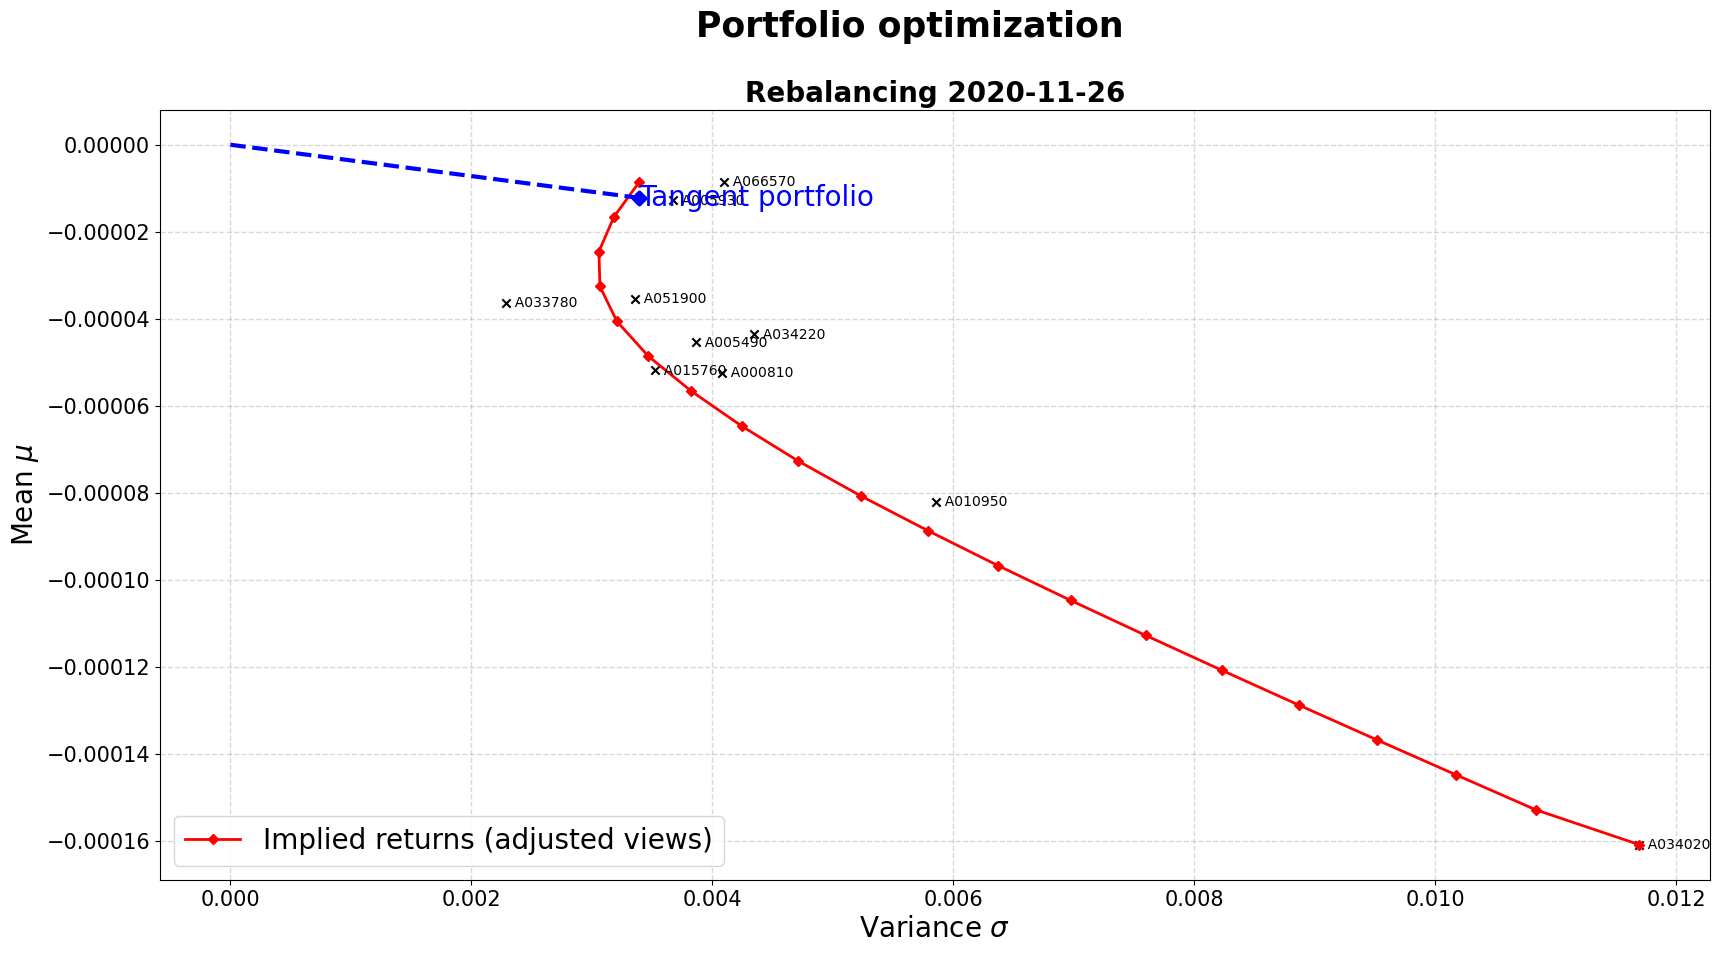

100%|██████████| 60/60 [00:02<00:00, 22.03it/s, Epoch=5/5, mse_loss=0.009]  


24


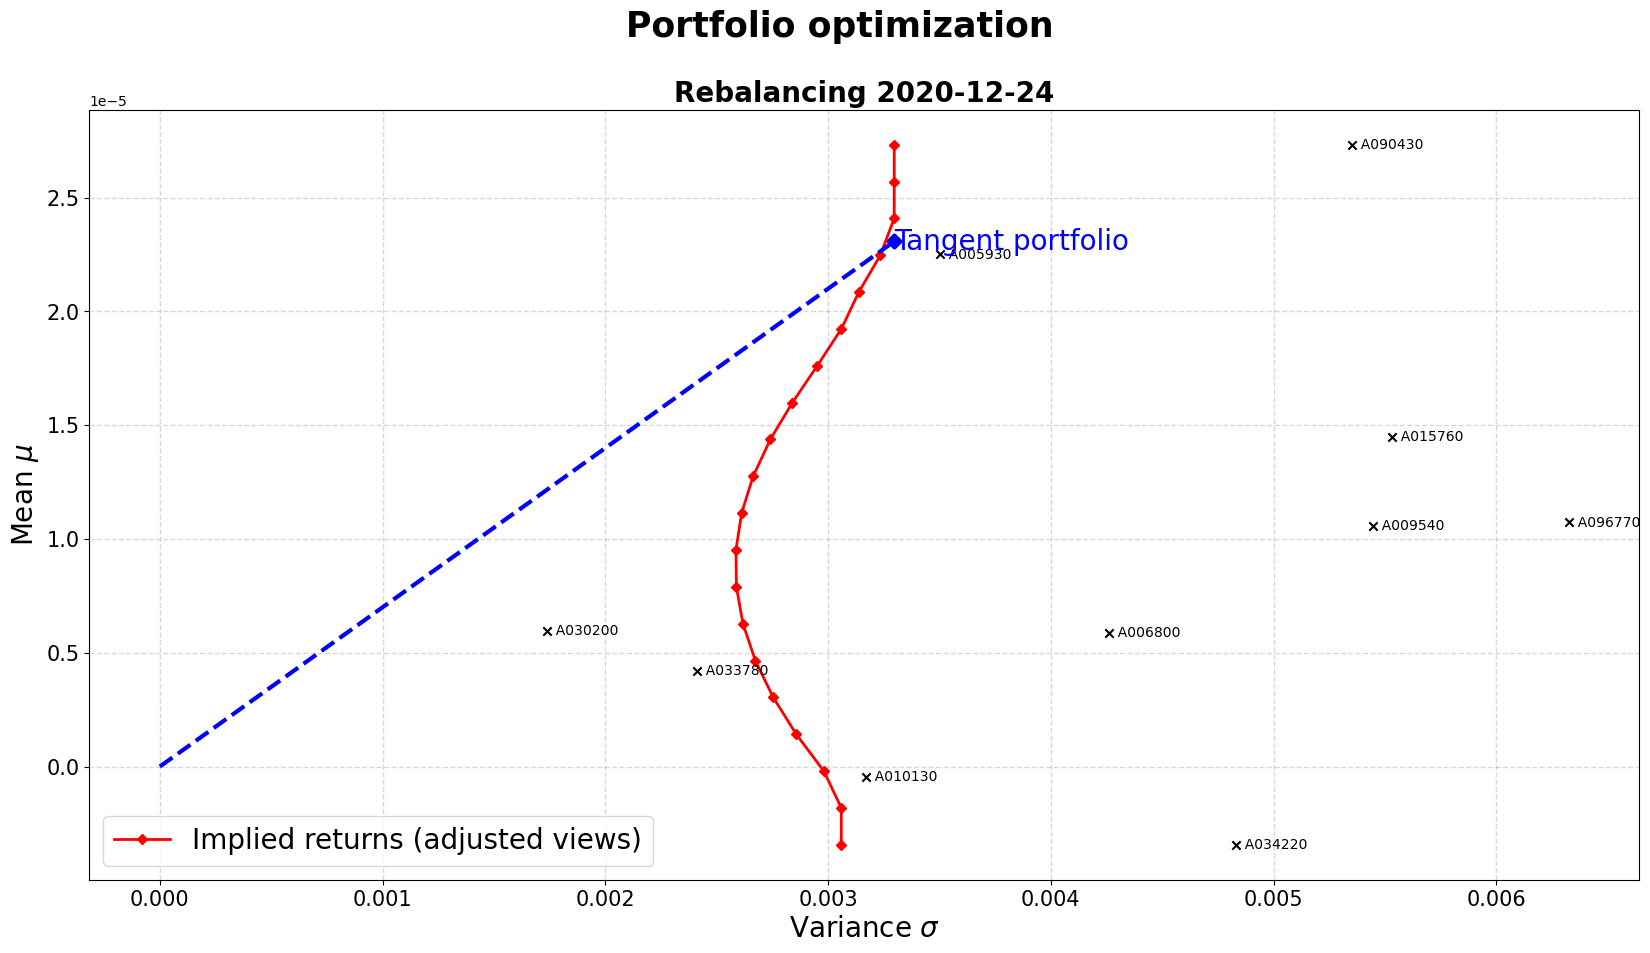

100%|██████████| 60/60 [00:02<00:00, 21.20it/s, Epoch=5/5, mse_loss=0.00674]


25


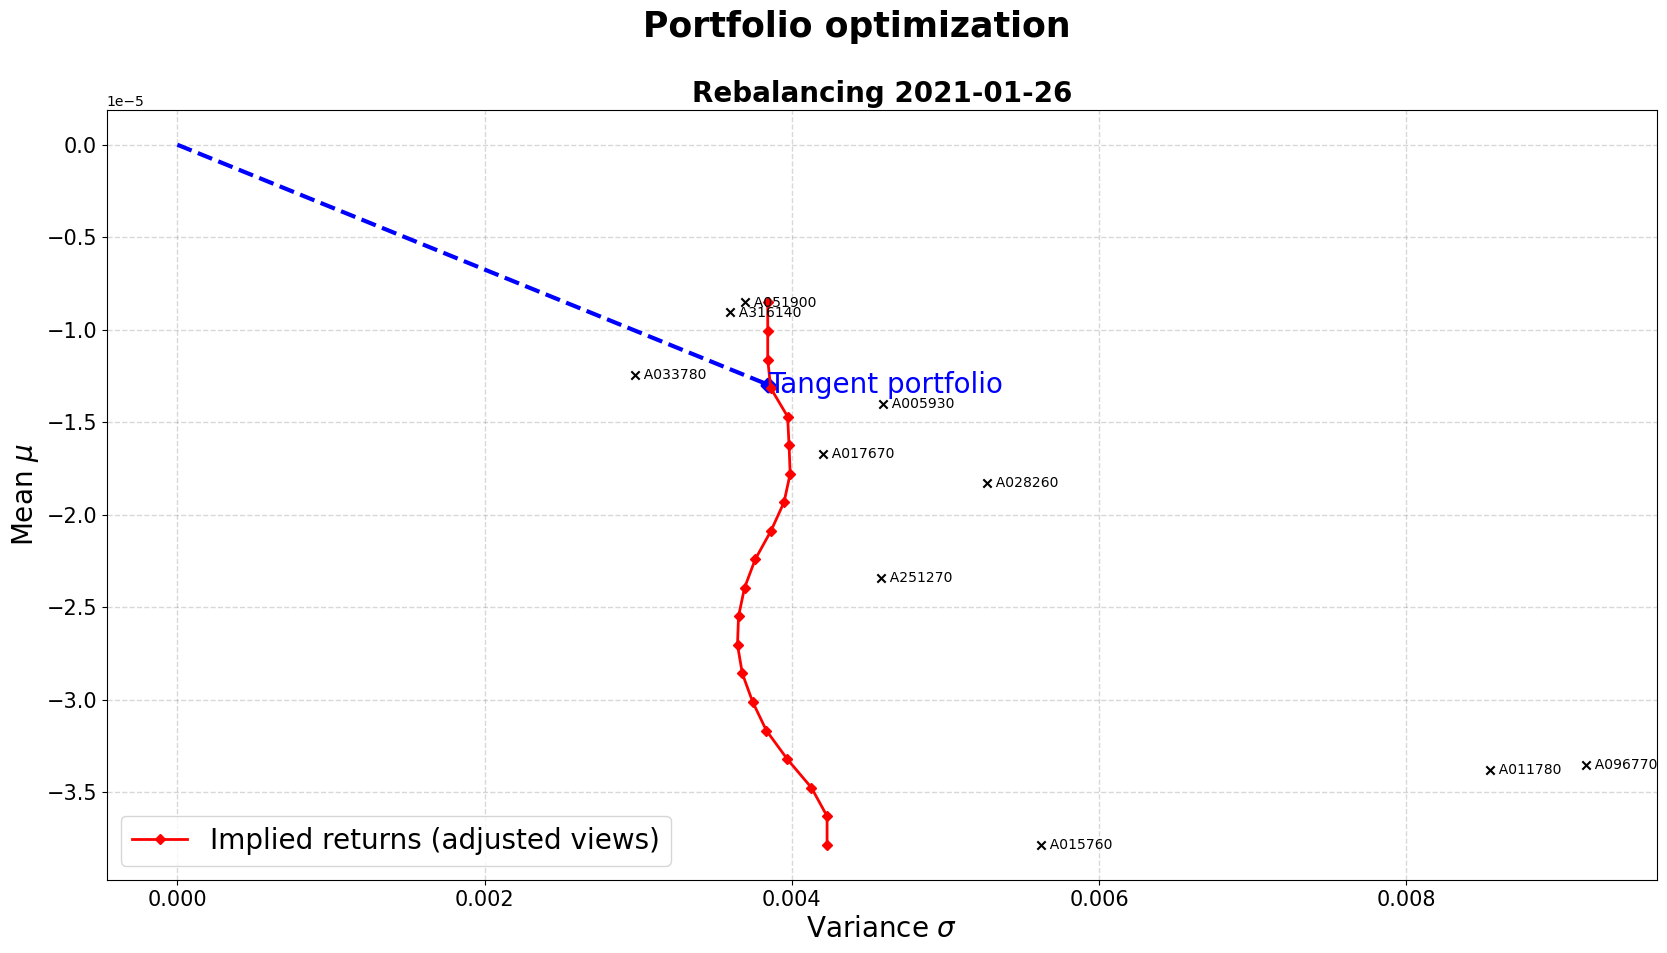

100%|██████████| 60/60 [00:02<00:00, 21.14it/s, Epoch=5/5, mse_loss=0.027]  


26


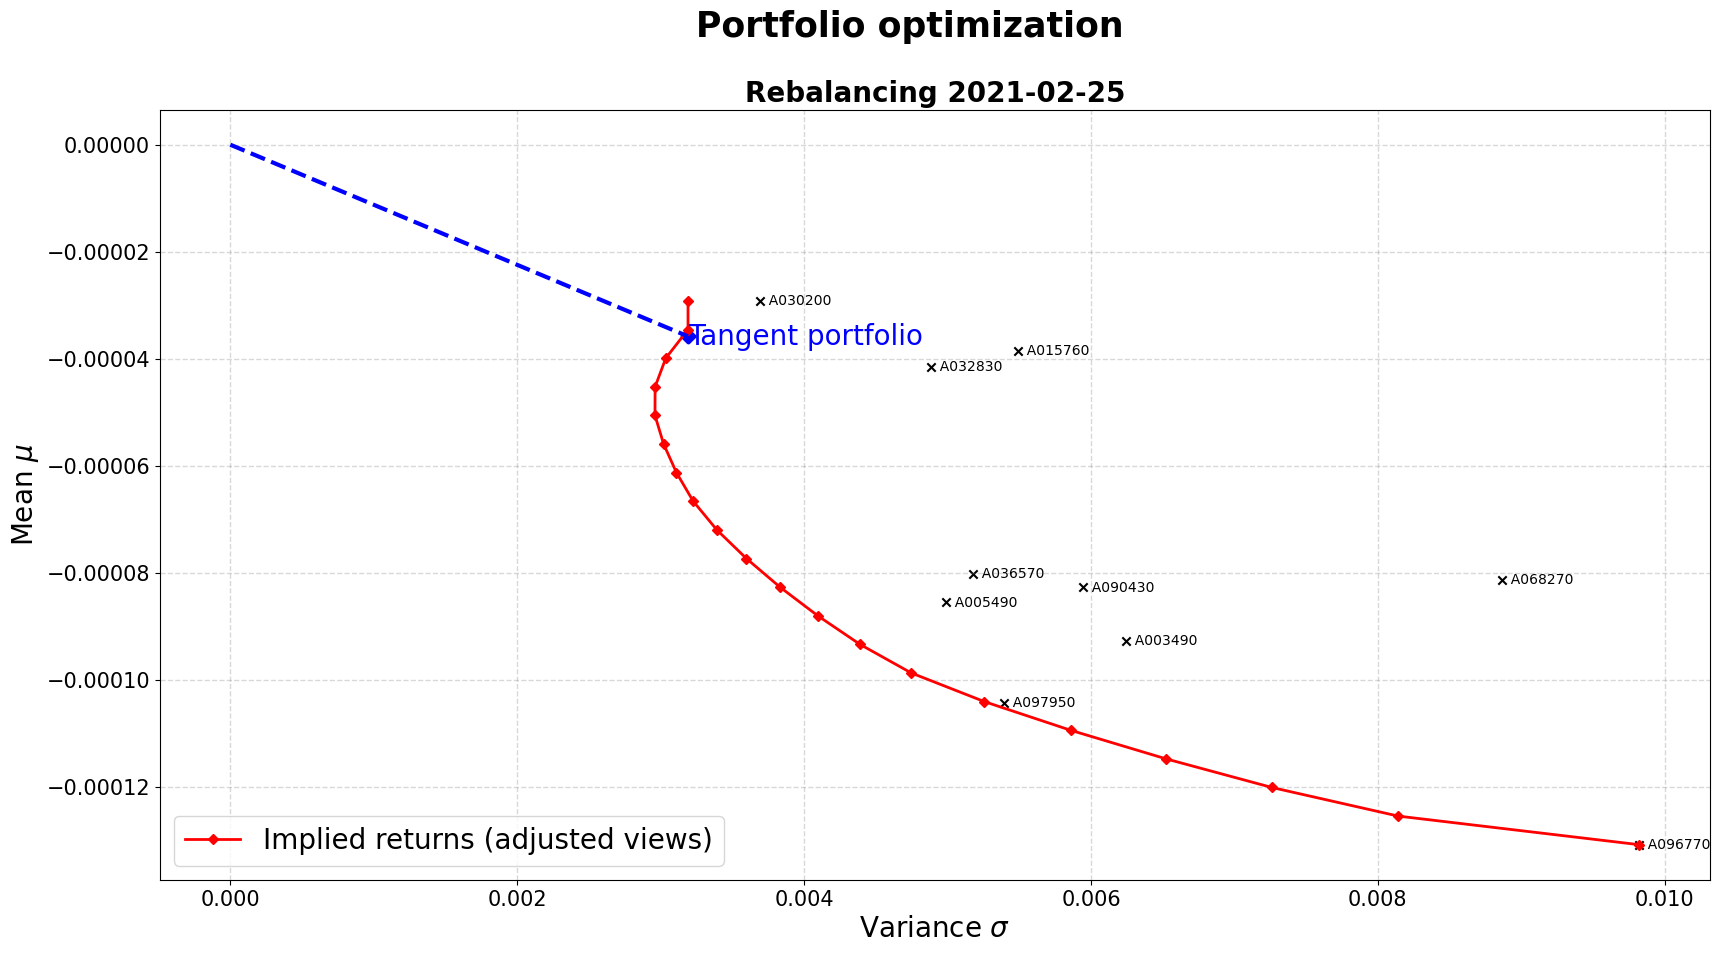

100%|██████████| 60/60 [00:02<00:00, 20.99it/s, Epoch=5/5, mse_loss=0.00487]


27


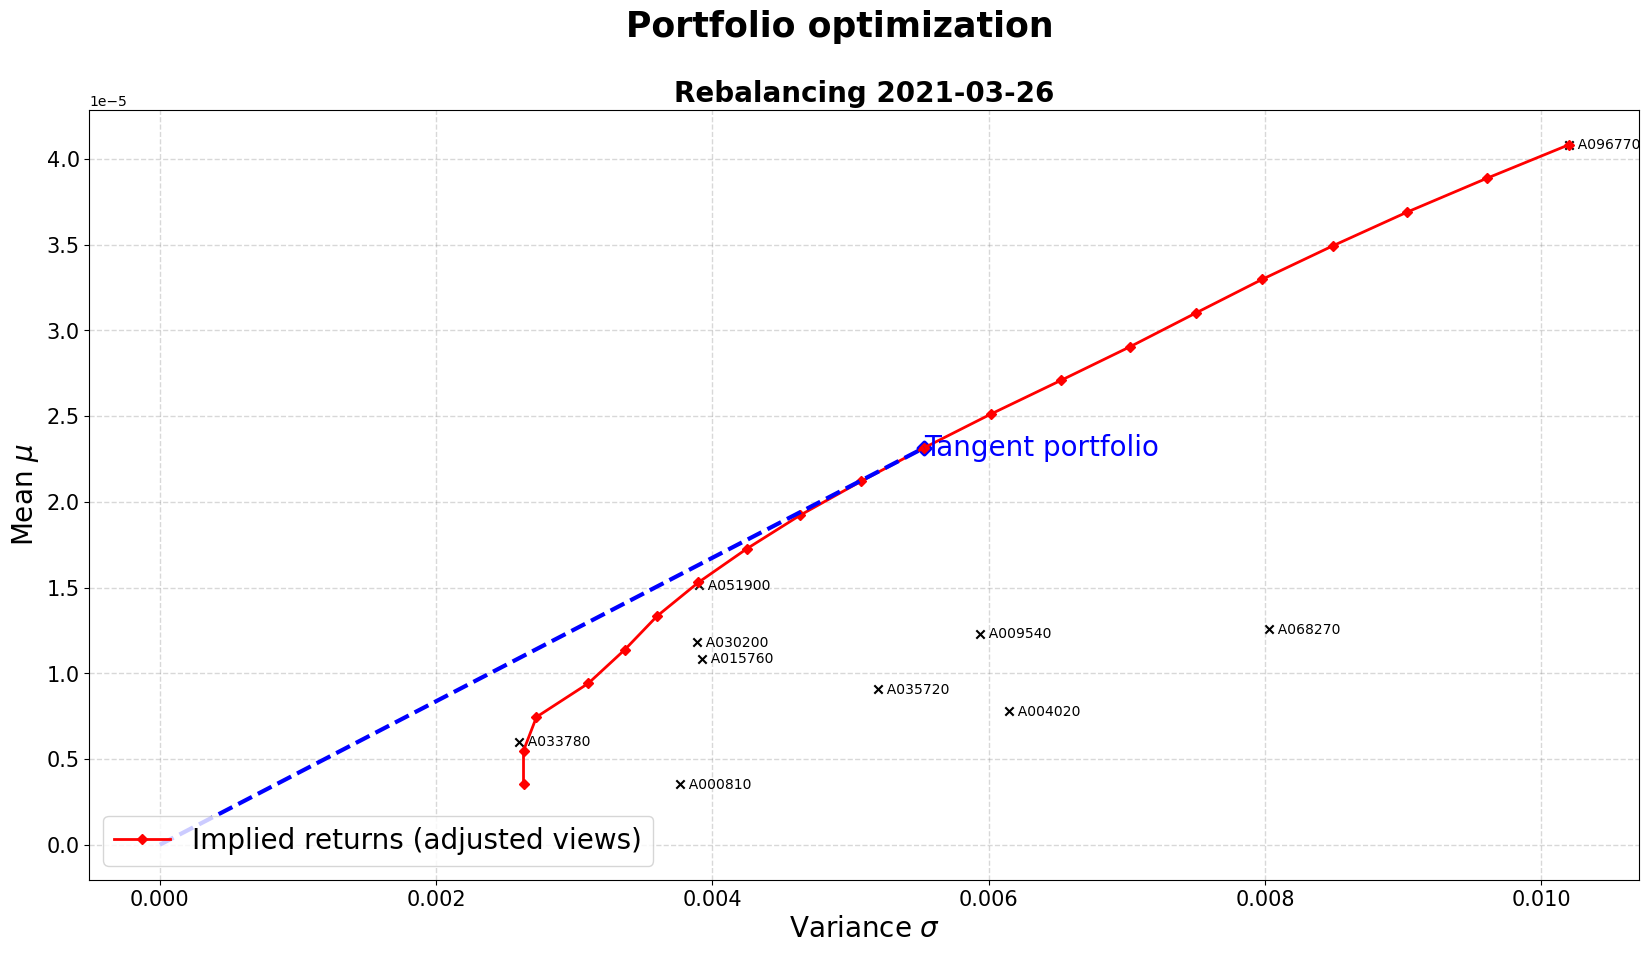

100%|██████████| 60/60 [00:02<00:00, 21.65it/s, Epoch=5/5, mse_loss=0.0107] 


28


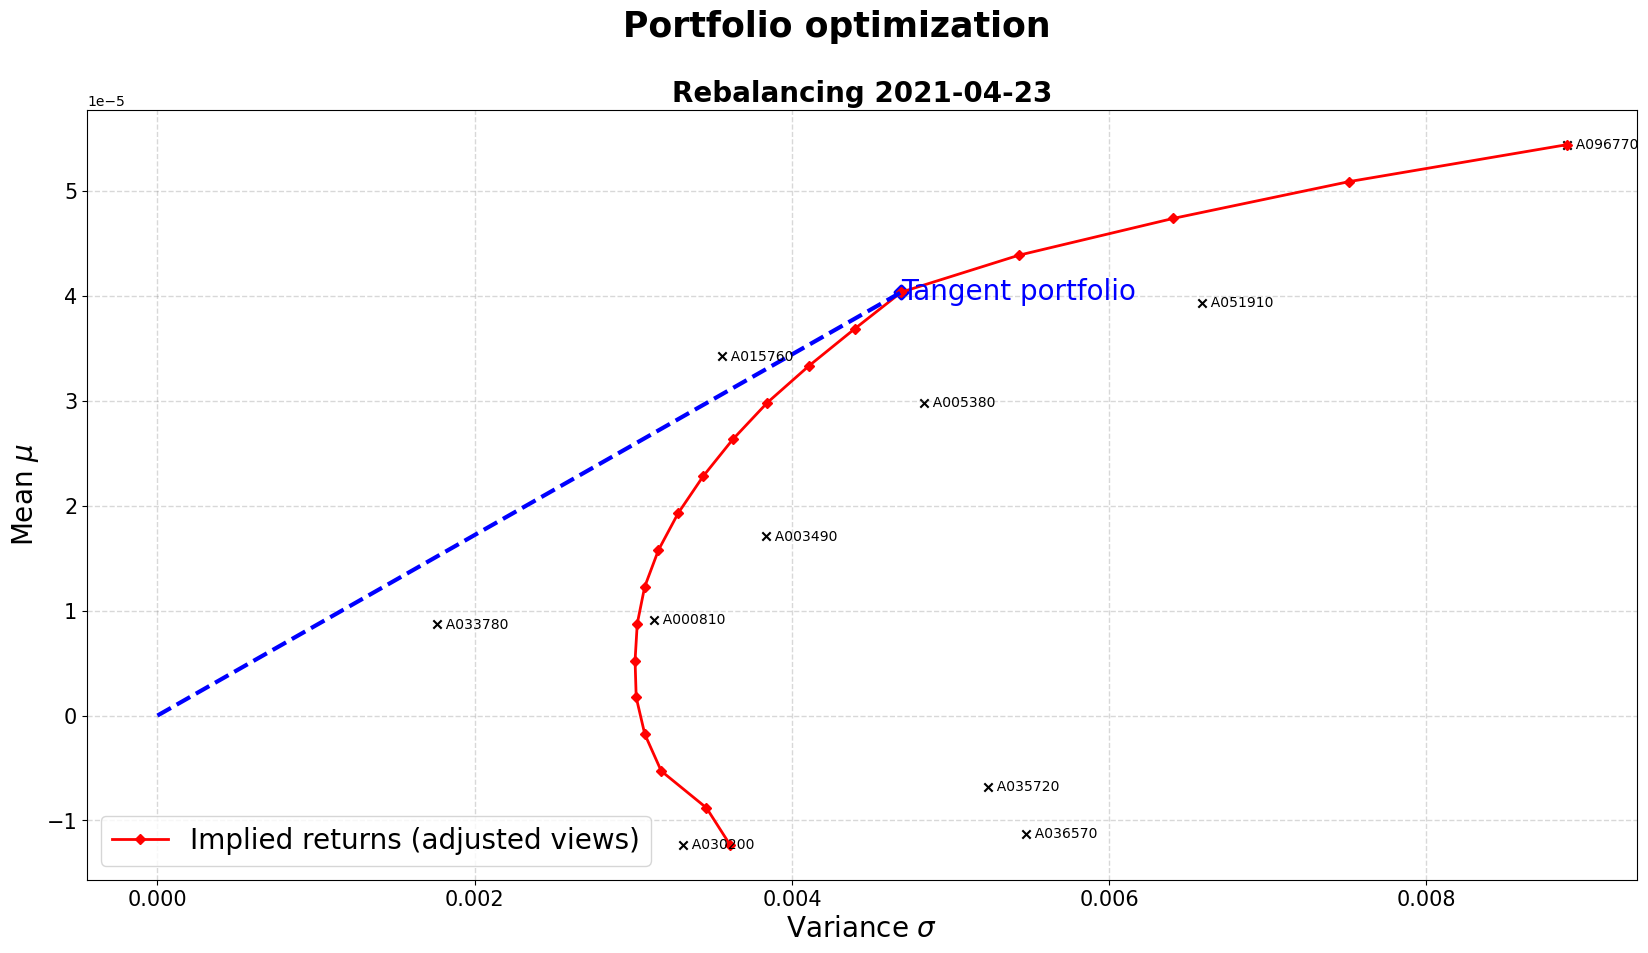

100%|██████████| 60/60 [00:02<00:00, 21.43it/s, Epoch=5/5, mse_loss=0.0119] 


29


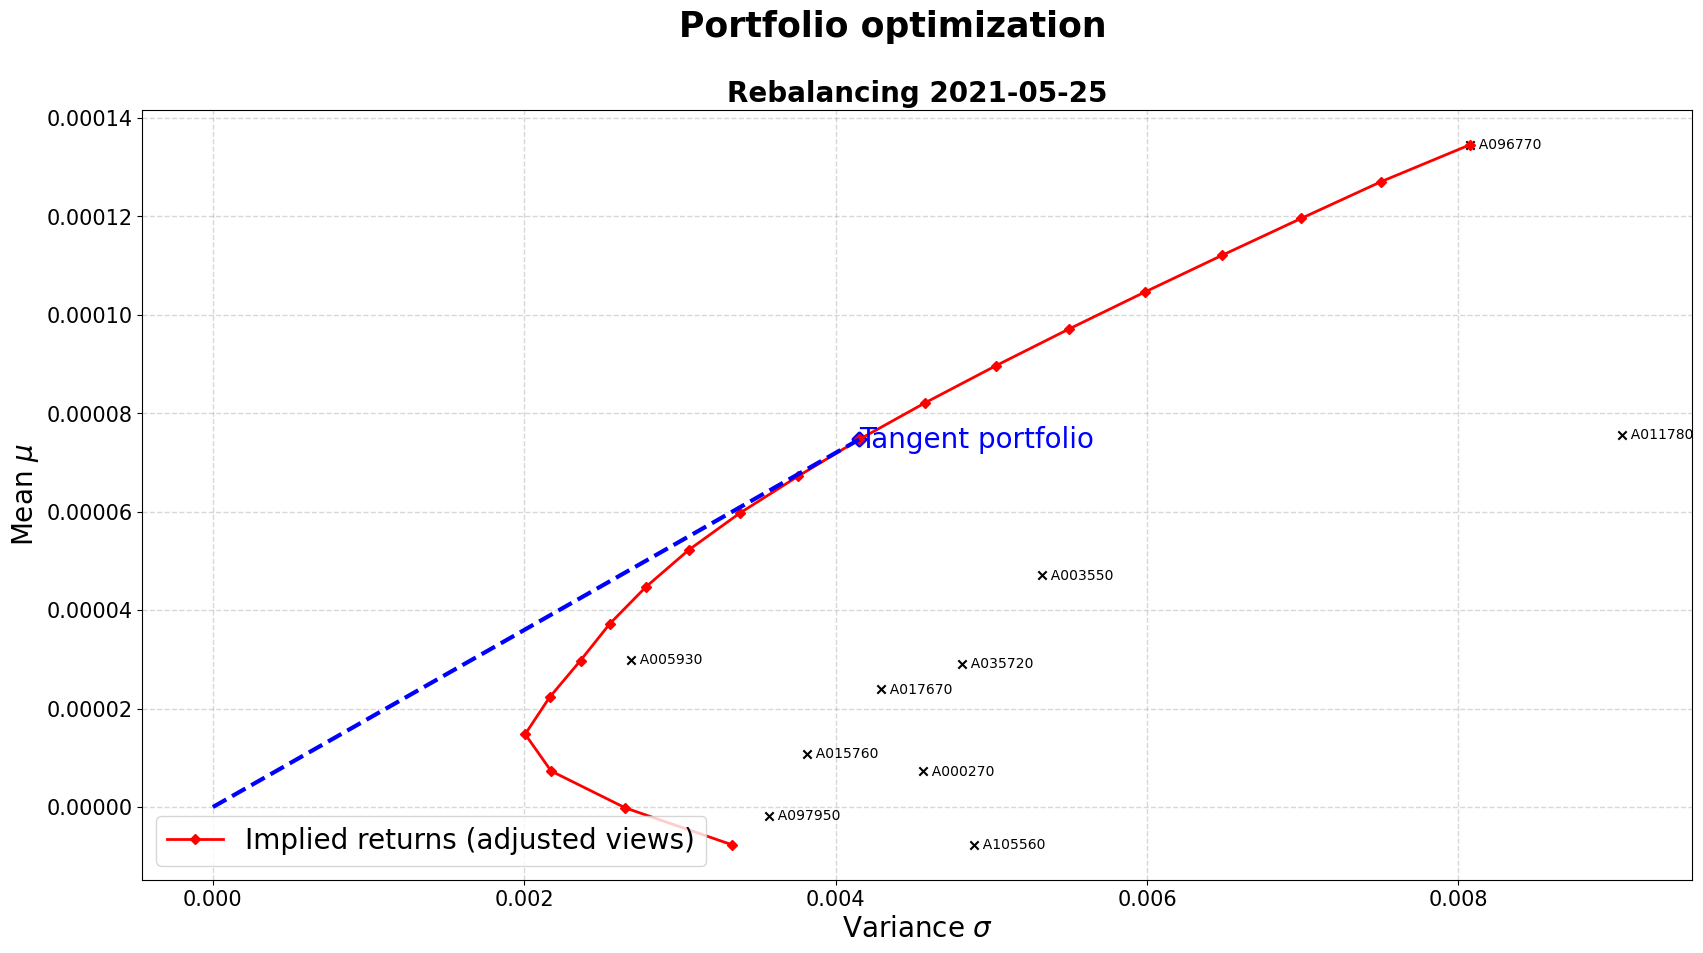

100%|██████████| 60/60 [00:02<00:00, 21.69it/s, Epoch=5/5, mse_loss=0.0117] 


30


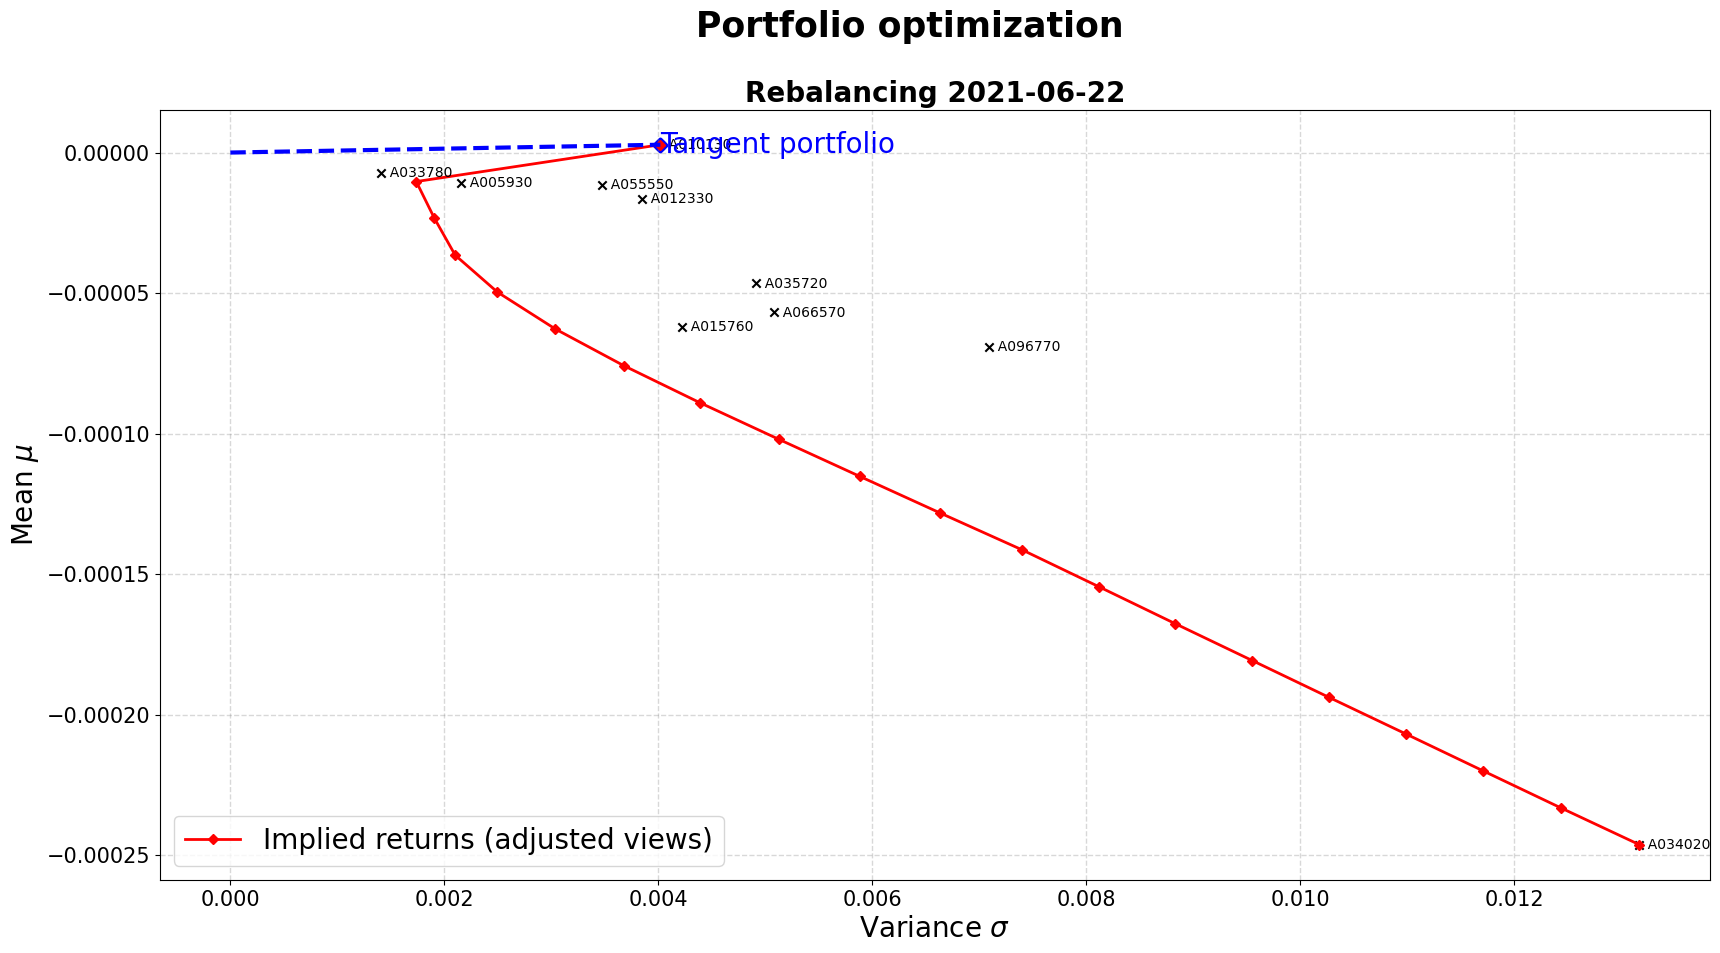

100%|██████████| 60/60 [00:02<00:00, 22.20it/s, Epoch=5/5, mse_loss=0.0275] 


31


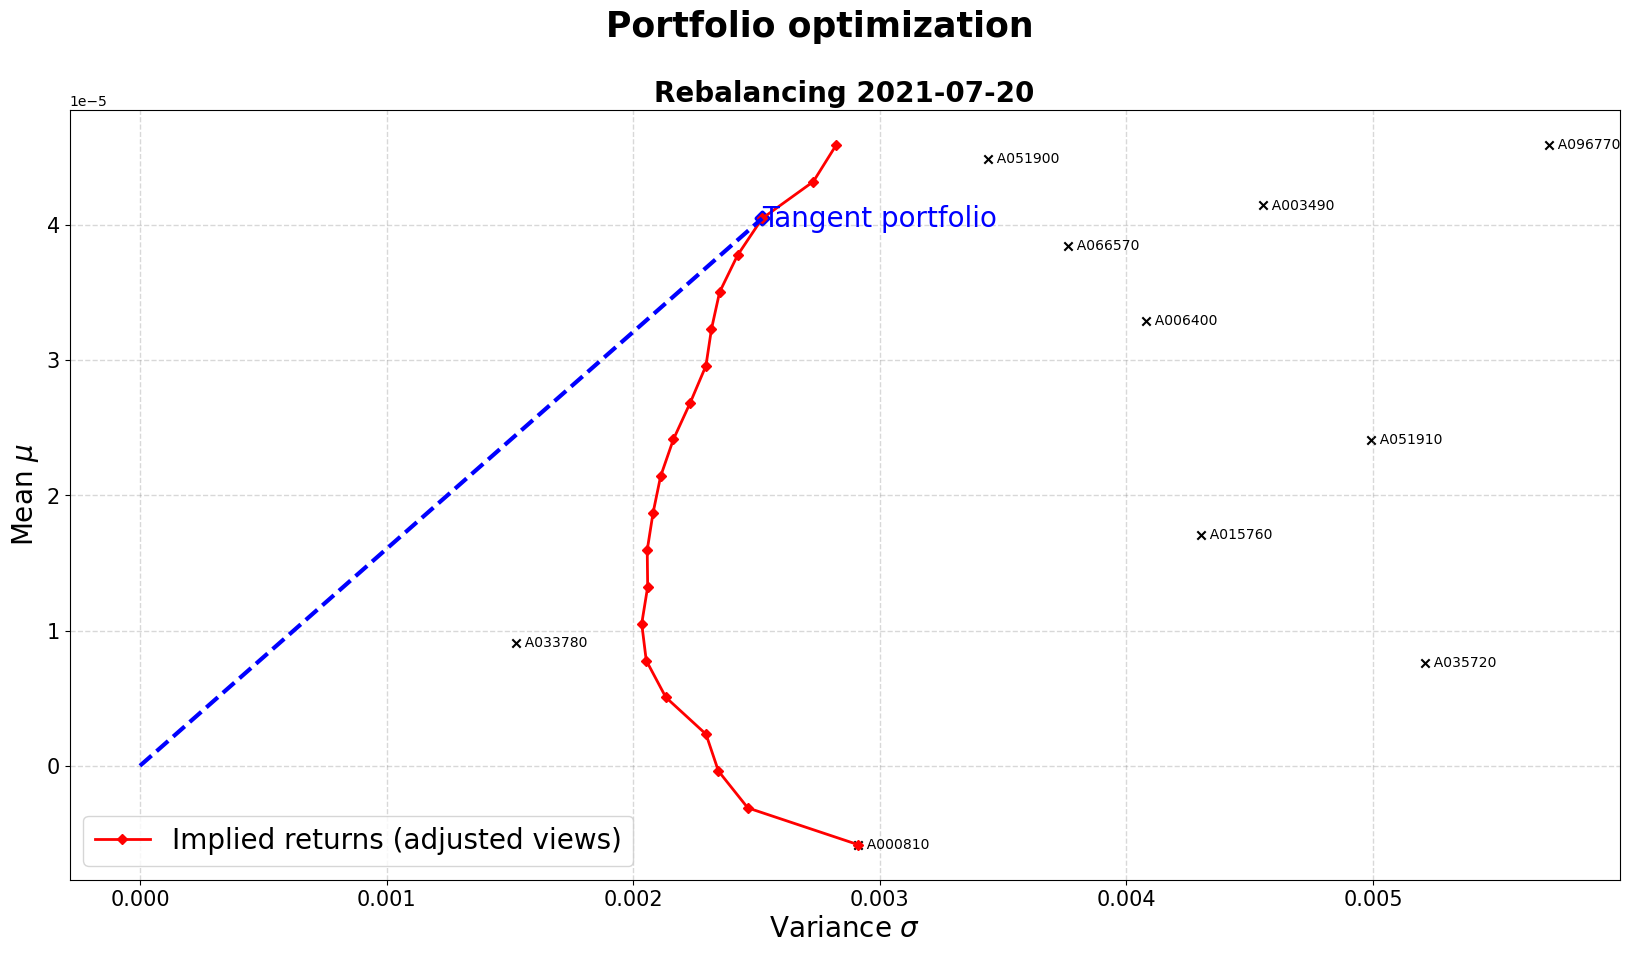

100%|██████████| 60/60 [00:02<00:00, 21.89it/s, Epoch=5/5, mse_loss=0.00388]


32


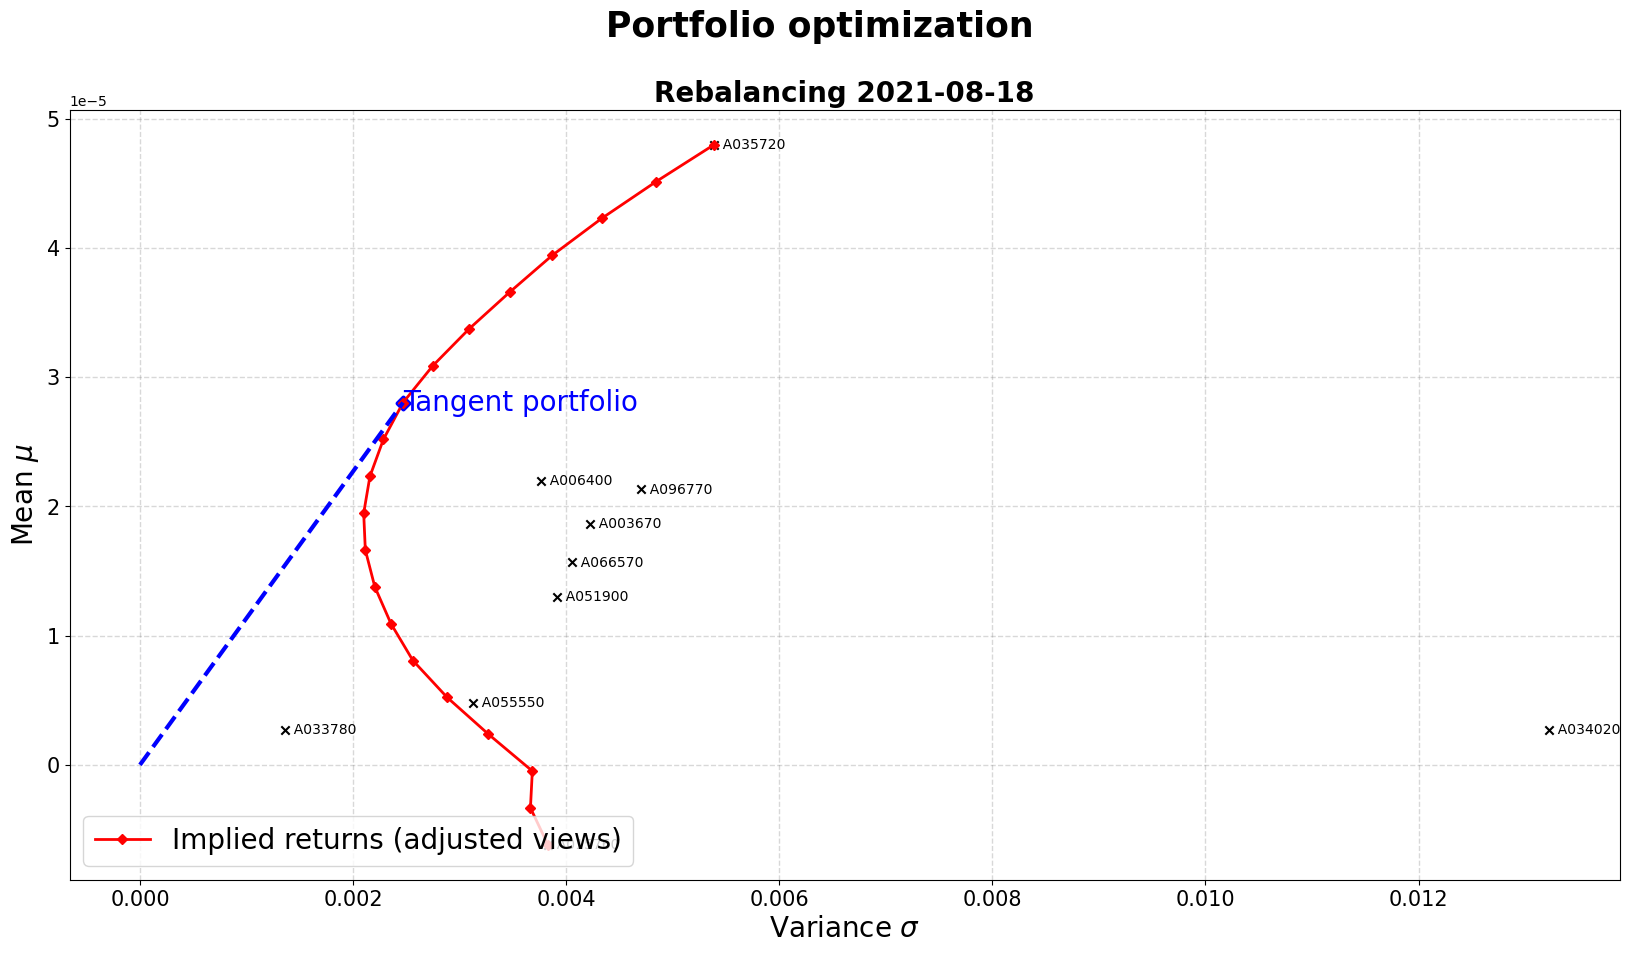

100%|██████████| 60/60 [00:02<00:00, 22.33it/s, Epoch=5/5, mse_loss=0.018]  


33


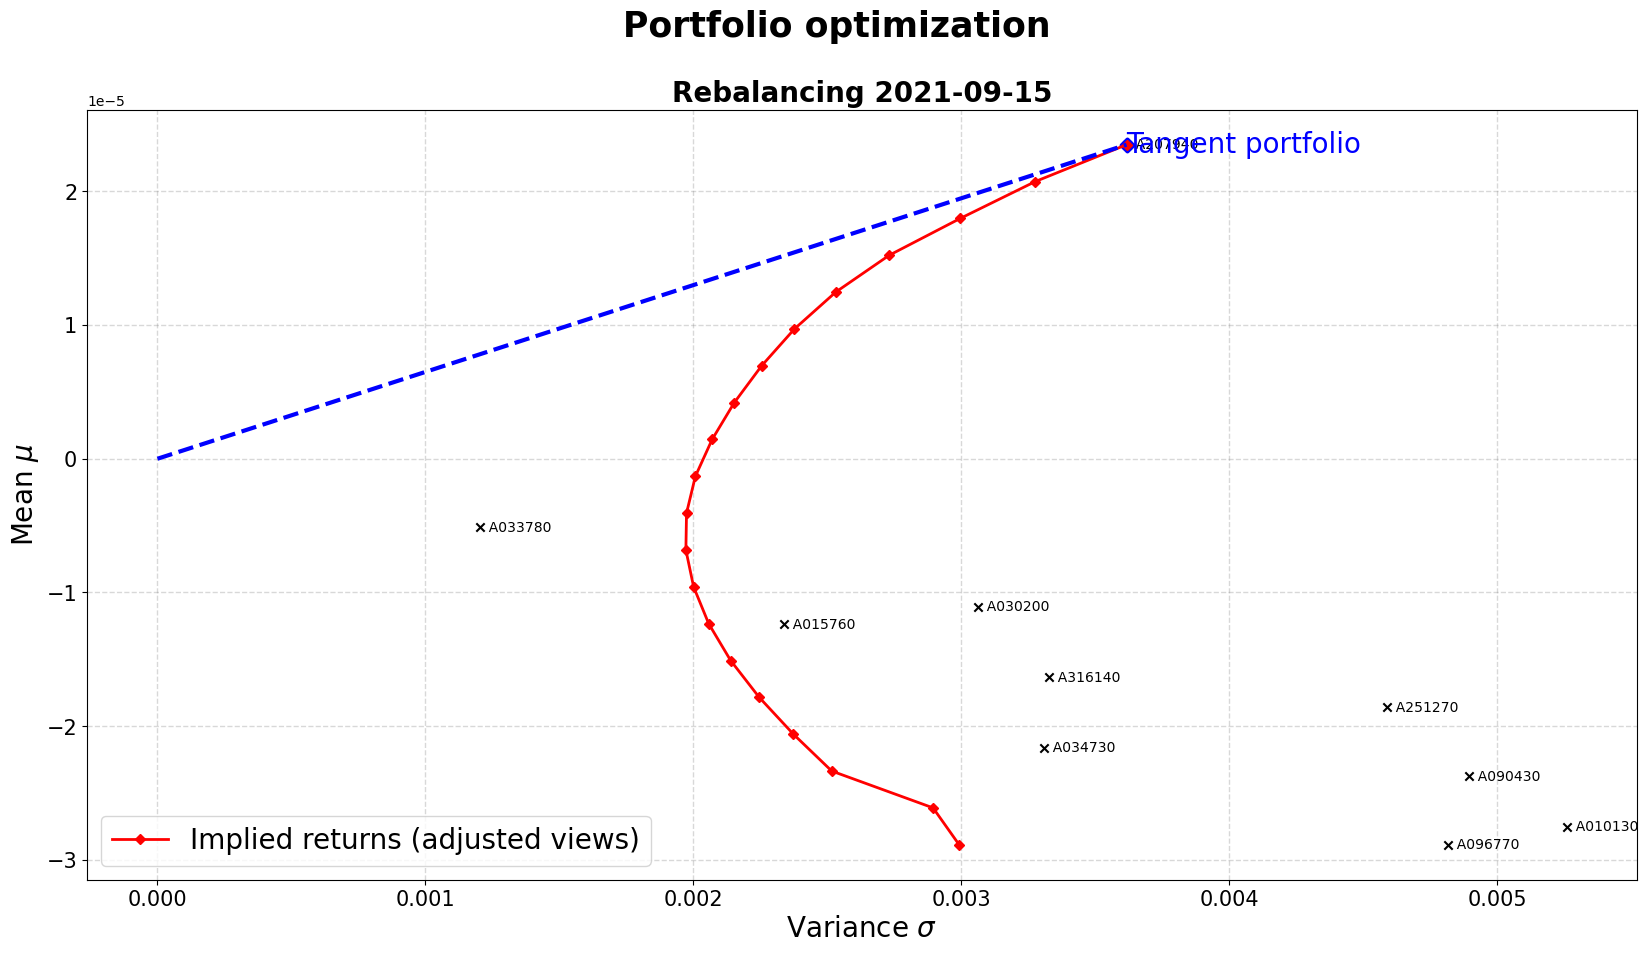

100%|██████████| 60/60 [00:02<00:00, 22.21it/s, Epoch=5/5, mse_loss=0.0017] 


34


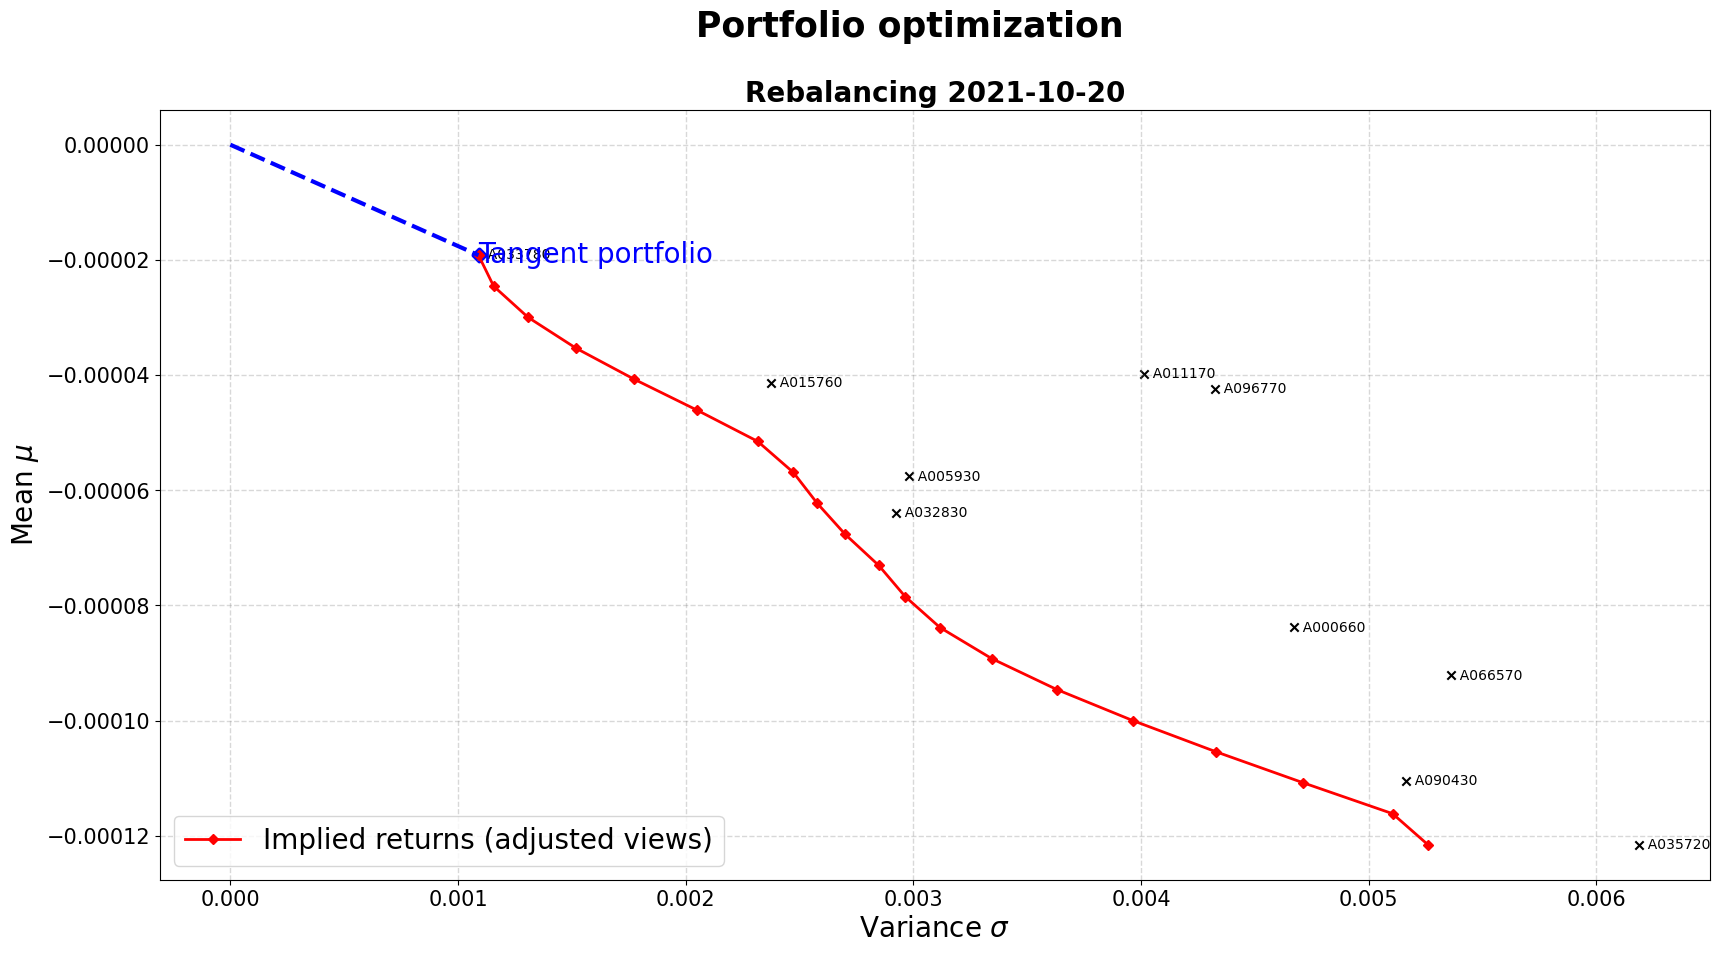

100%|██████████| 60/60 [00:02<00:00, 22.08it/s, Epoch=5/5, mse_loss=0.00582]


35


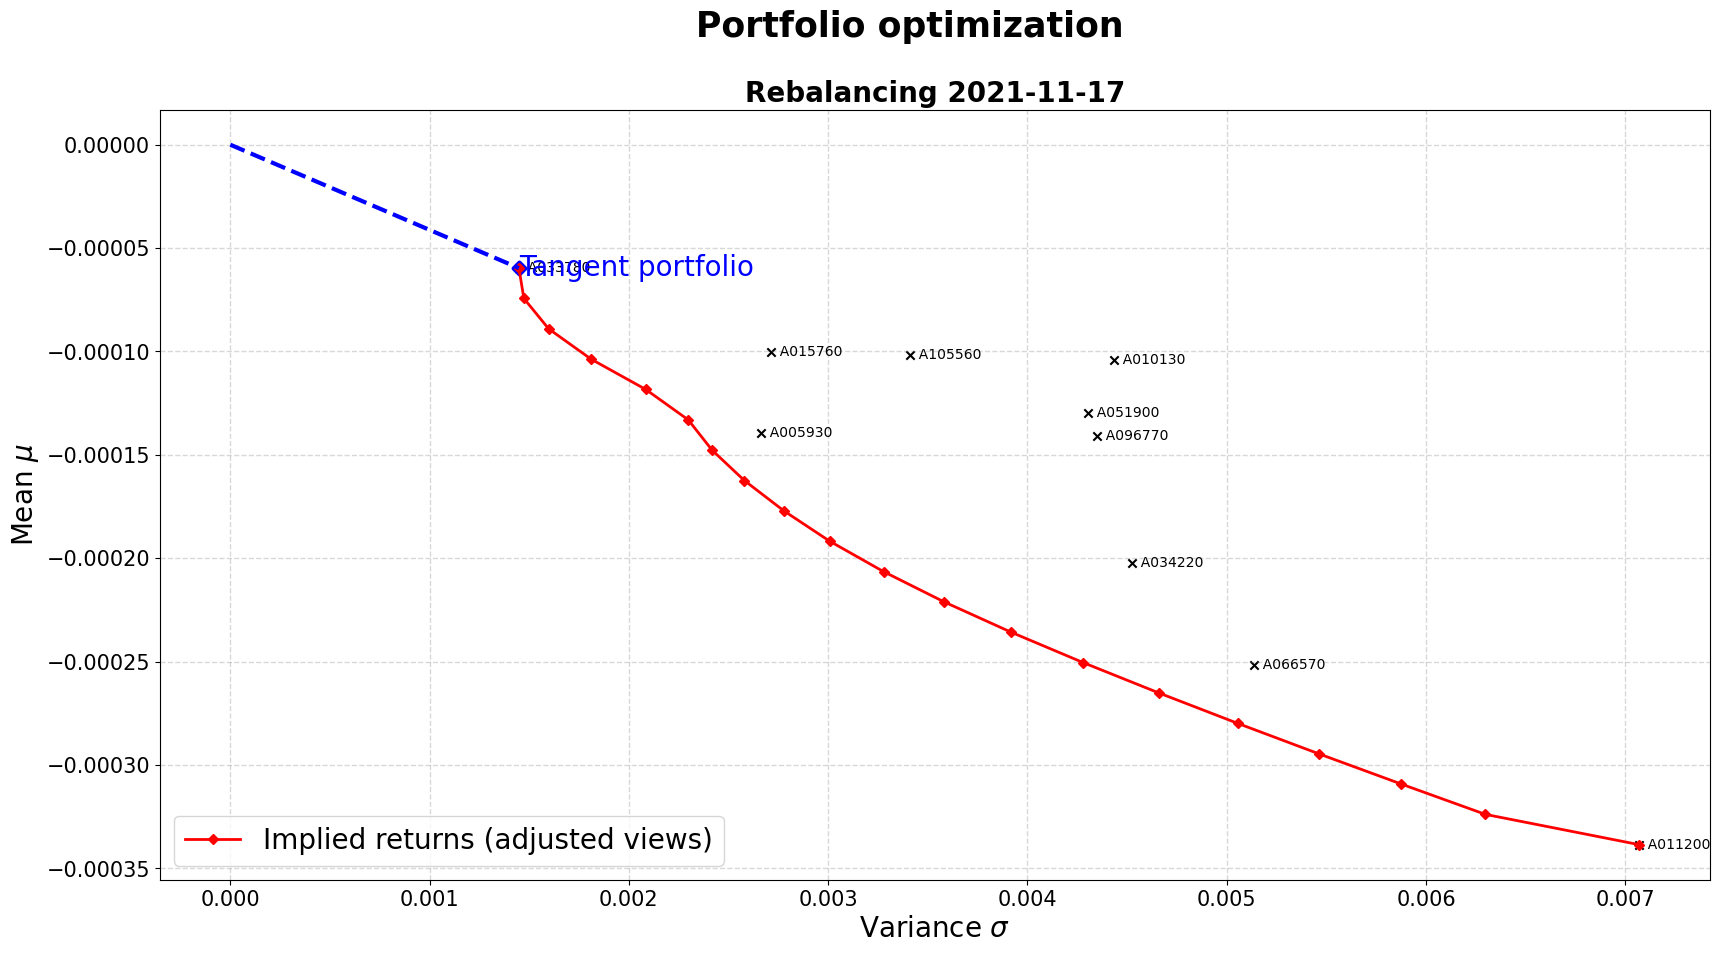

100%|██████████| 60/60 [00:02<00:00, 21.67it/s, Epoch=5/5, mse_loss=0.00855]


36


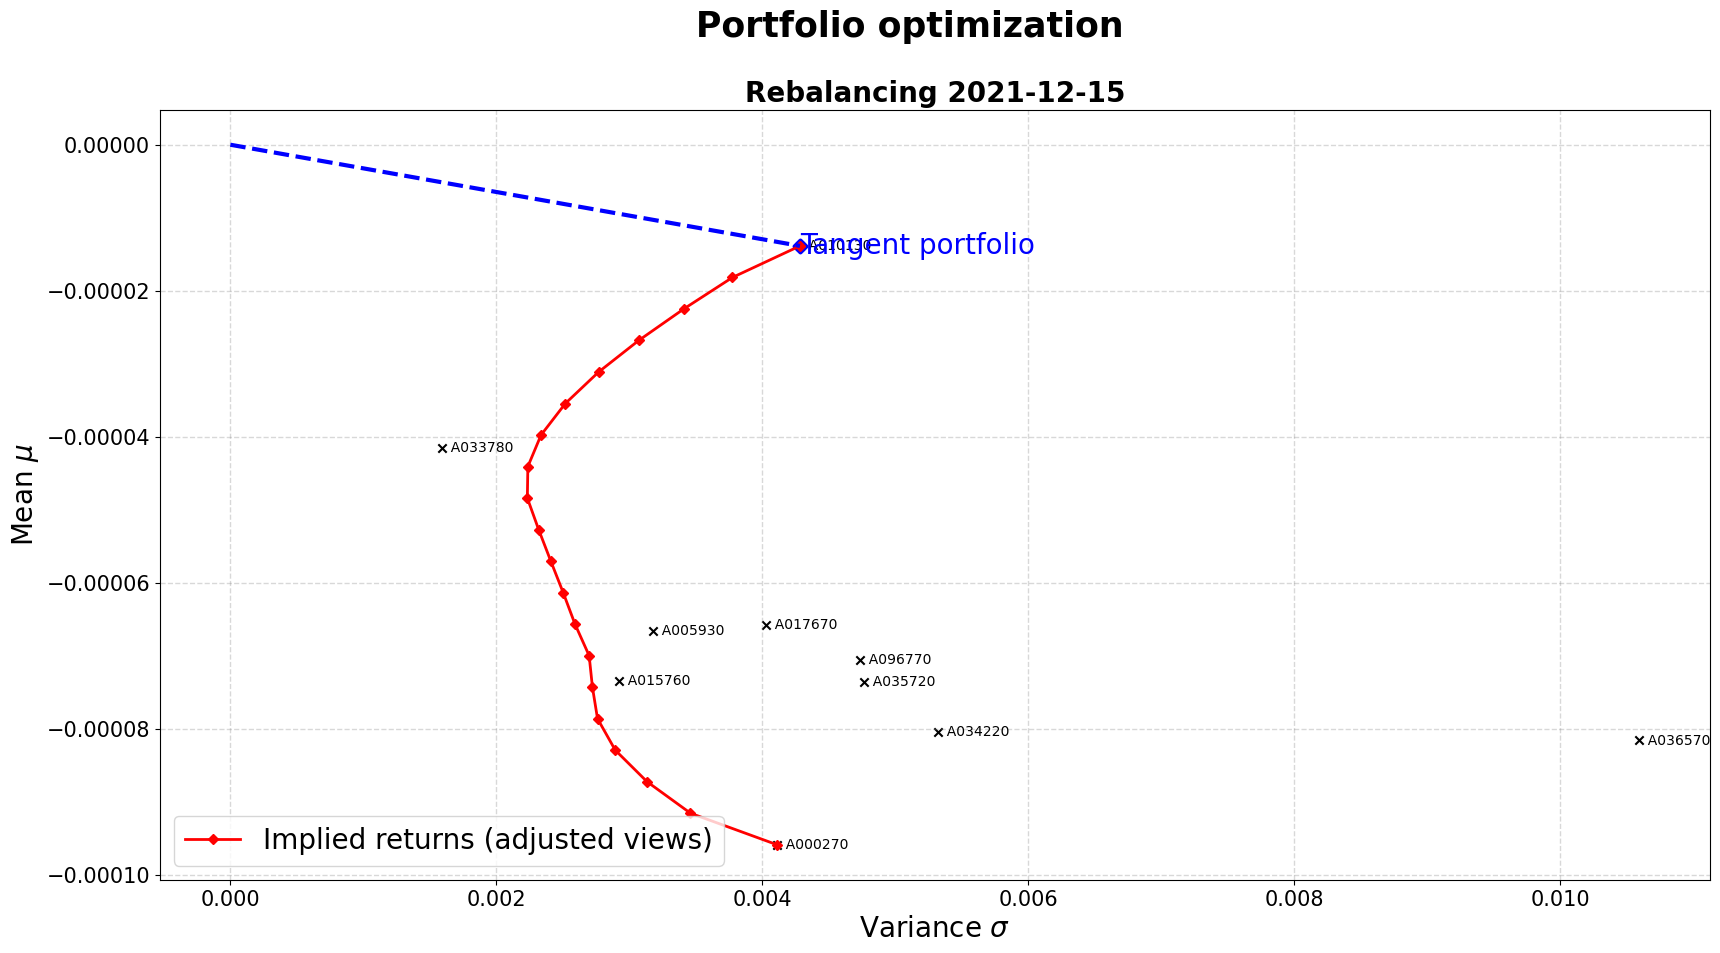

100%|██████████| 60/60 [00:02<00:00, 21.93it/s, Epoch=5/5, mse_loss=0.00519]


37


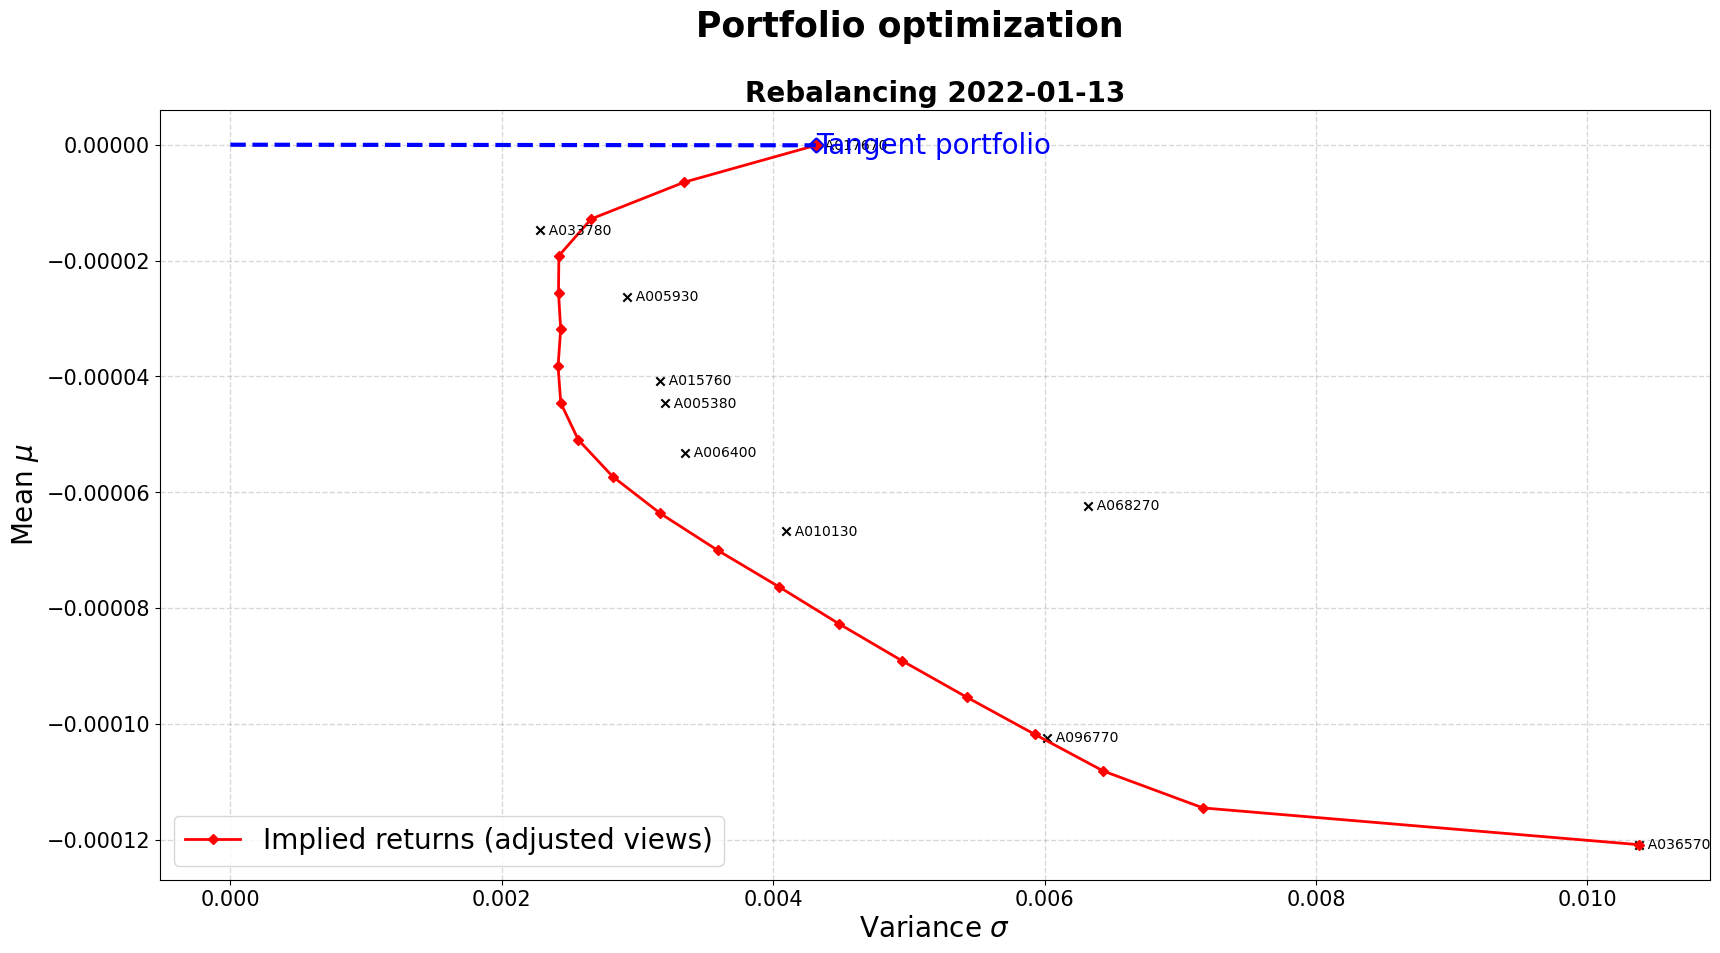

100%|██████████| 60/60 [00:02<00:00, 22.98it/s, Epoch=5/5, mse_loss=0.00603]


38


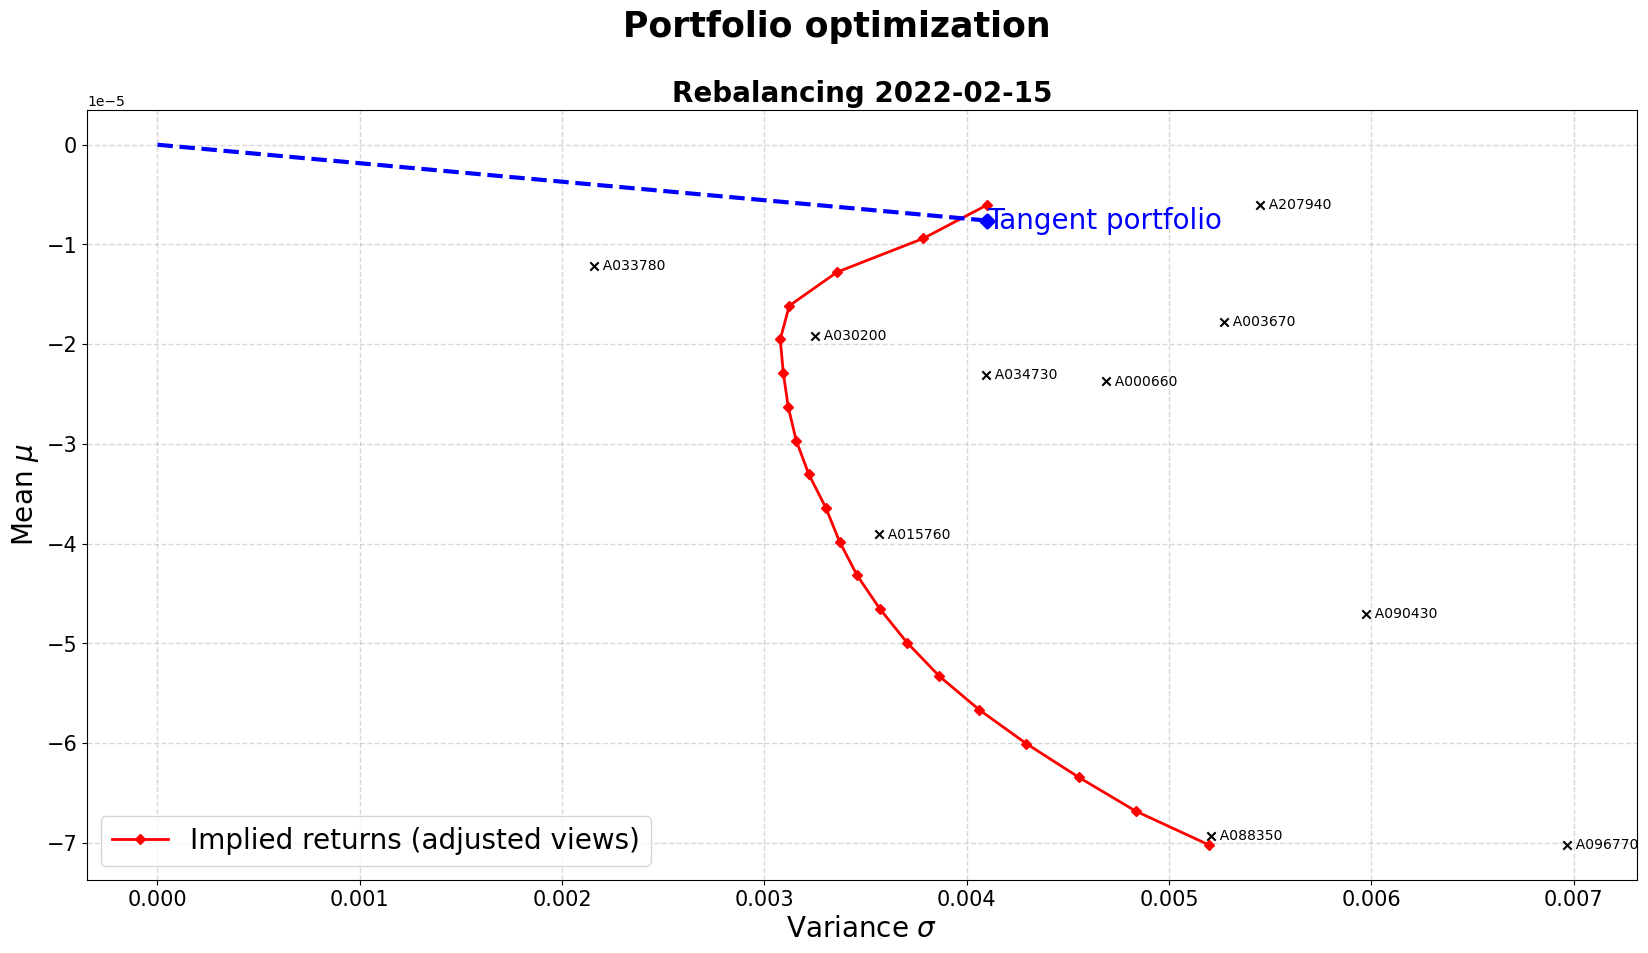

100%|██████████| 60/60 [00:02<00:00, 23.11it/s, Epoch=5/5, mse_loss=0.00629]


39


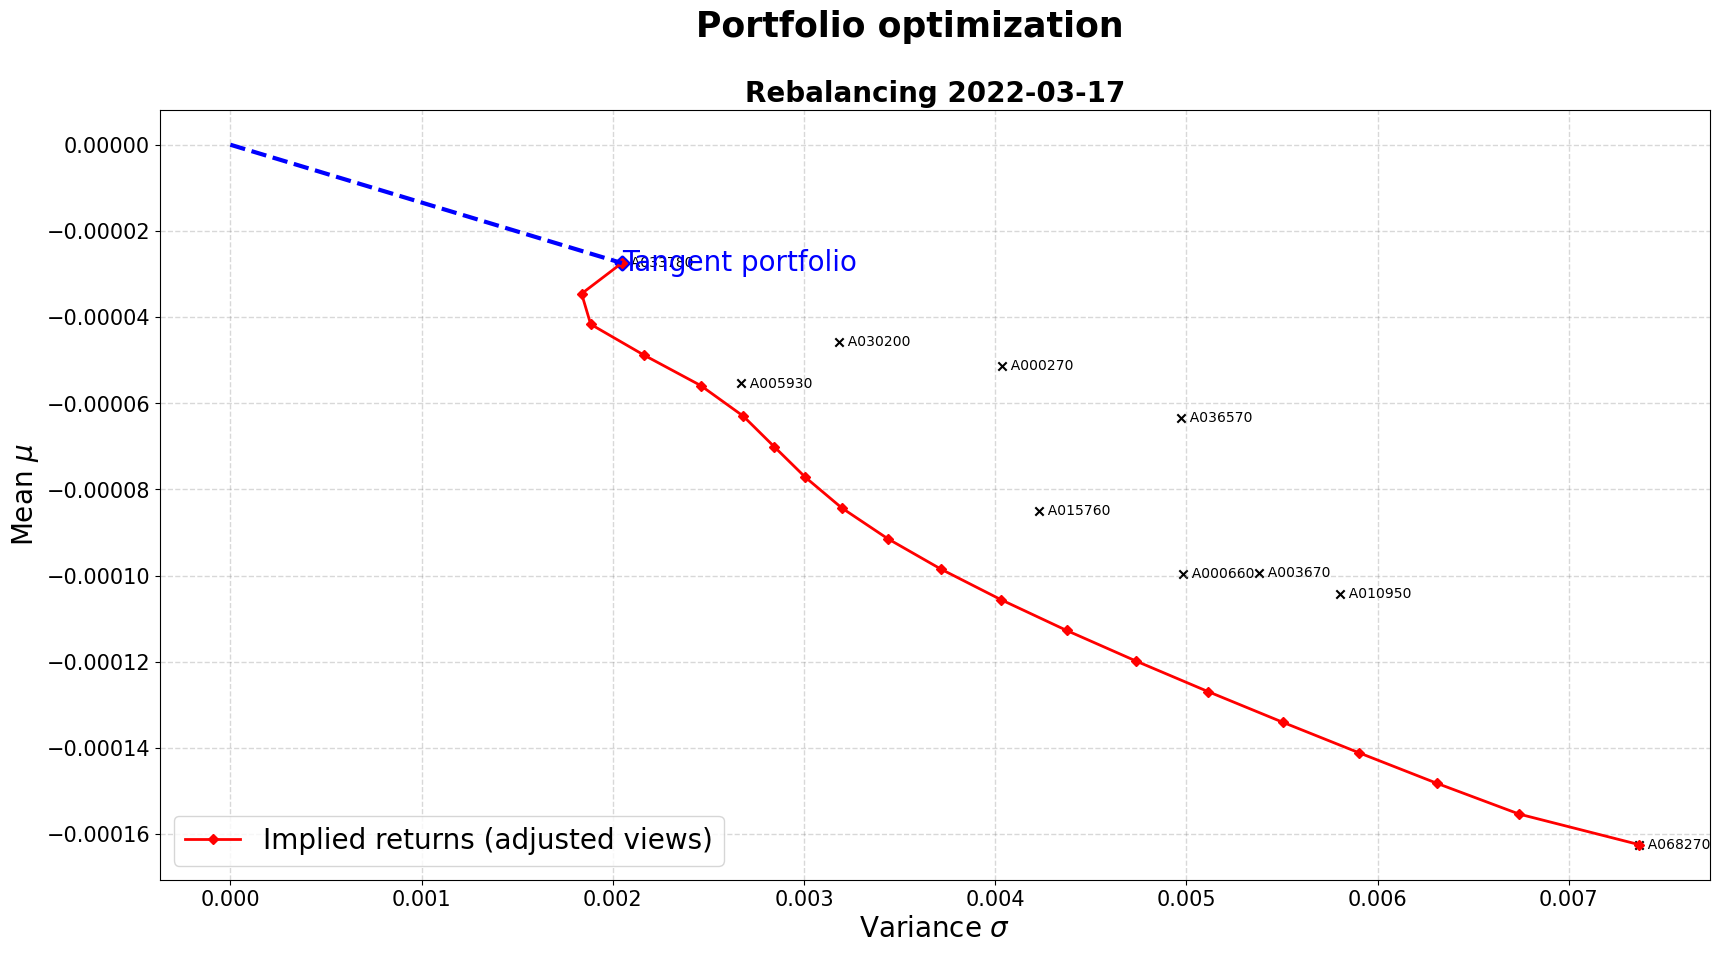

100%|██████████| 60/60 [00:02<00:00, 21.78it/s, Epoch=5/5, mse_loss=0.00693]


40


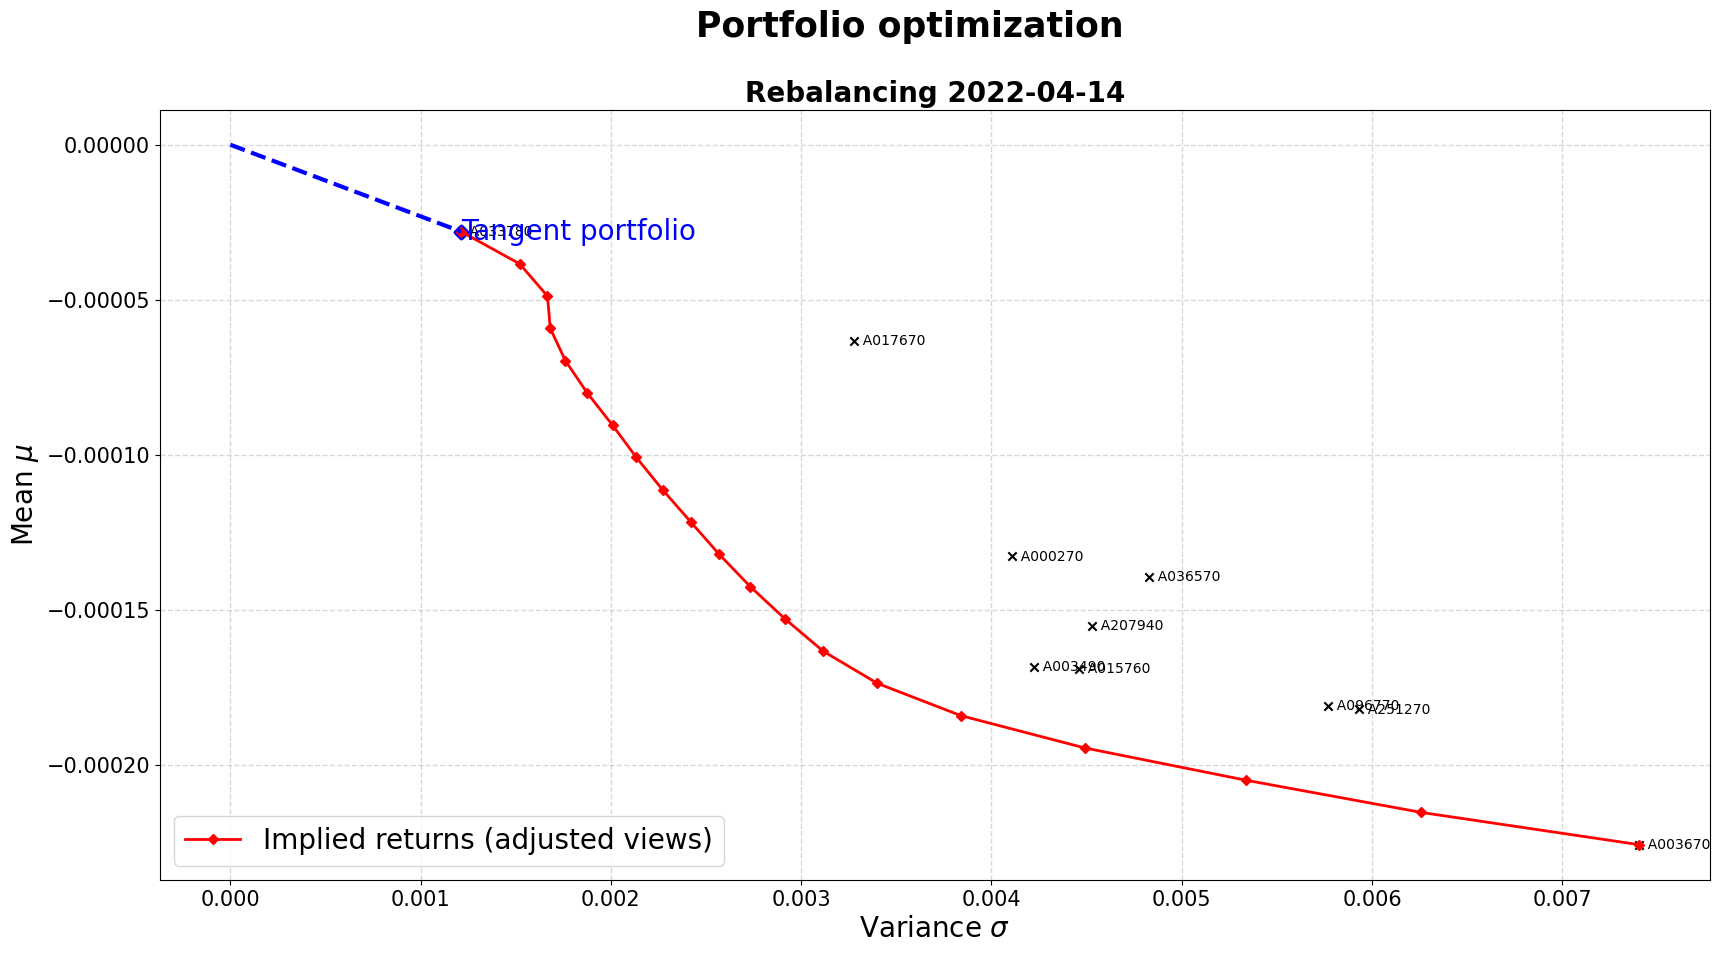

100%|██████████| 60/60 [00:02<00:00, 22.62it/s, Epoch=5/5, mse_loss=0.0081] 


41


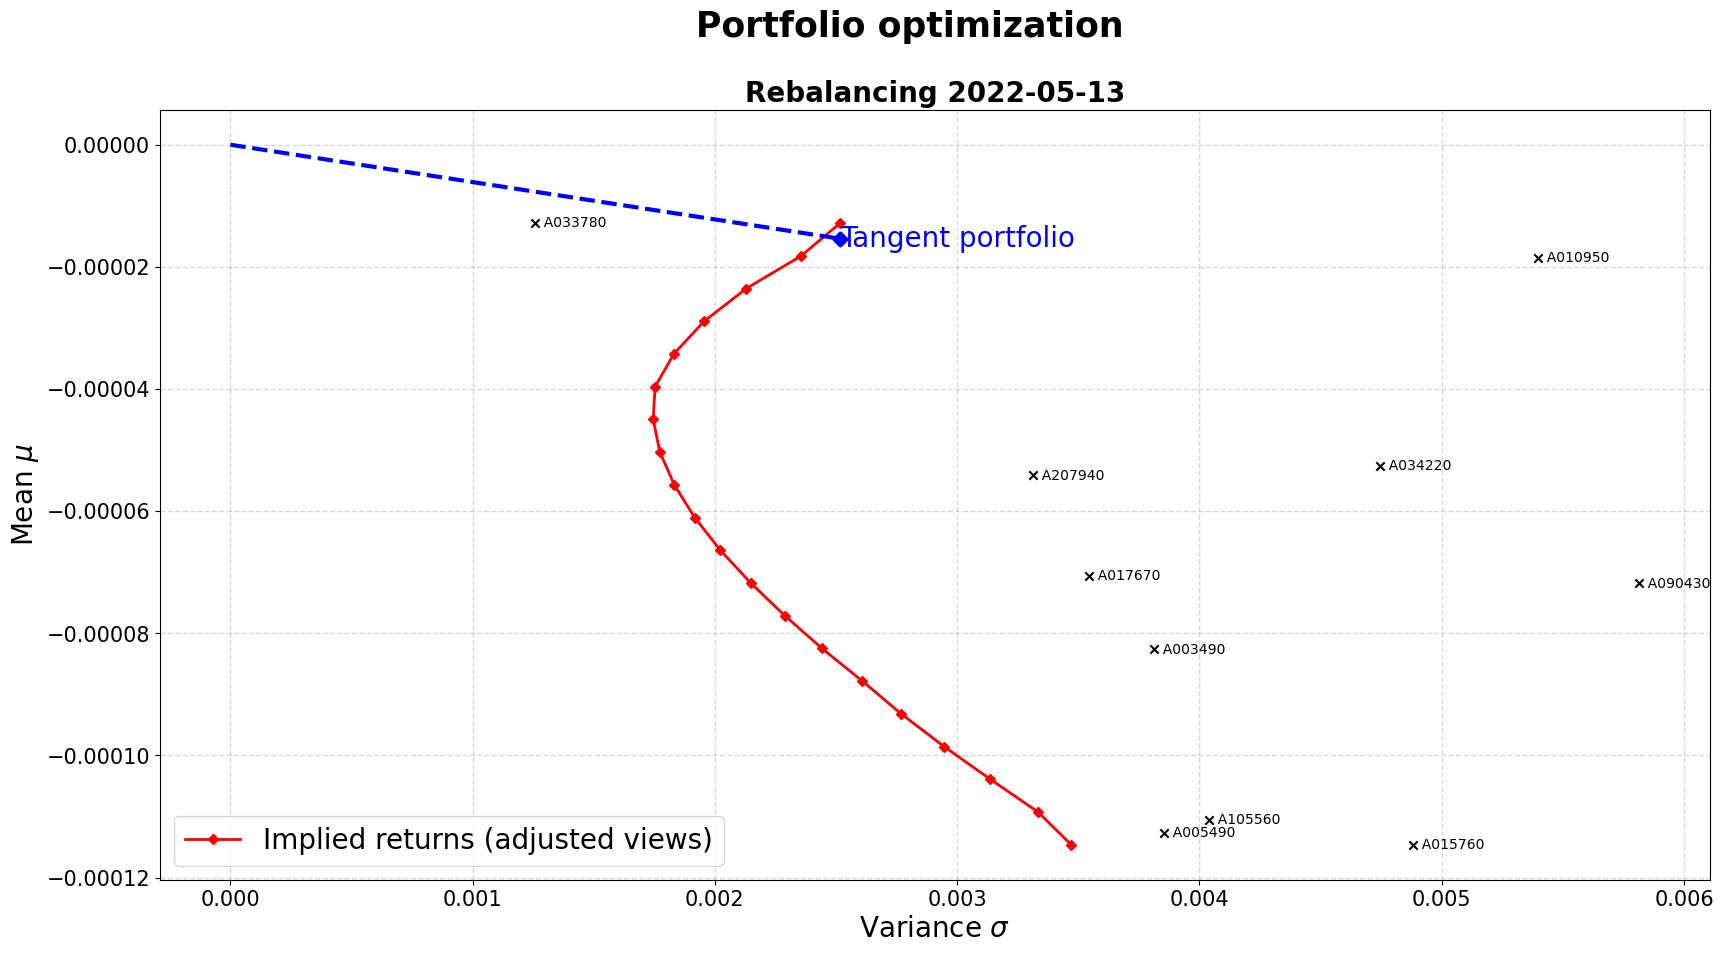

100%|██████████| 60/60 [00:02<00:00, 22.73it/s, Epoch=5/5, mse_loss=0.00401]


42


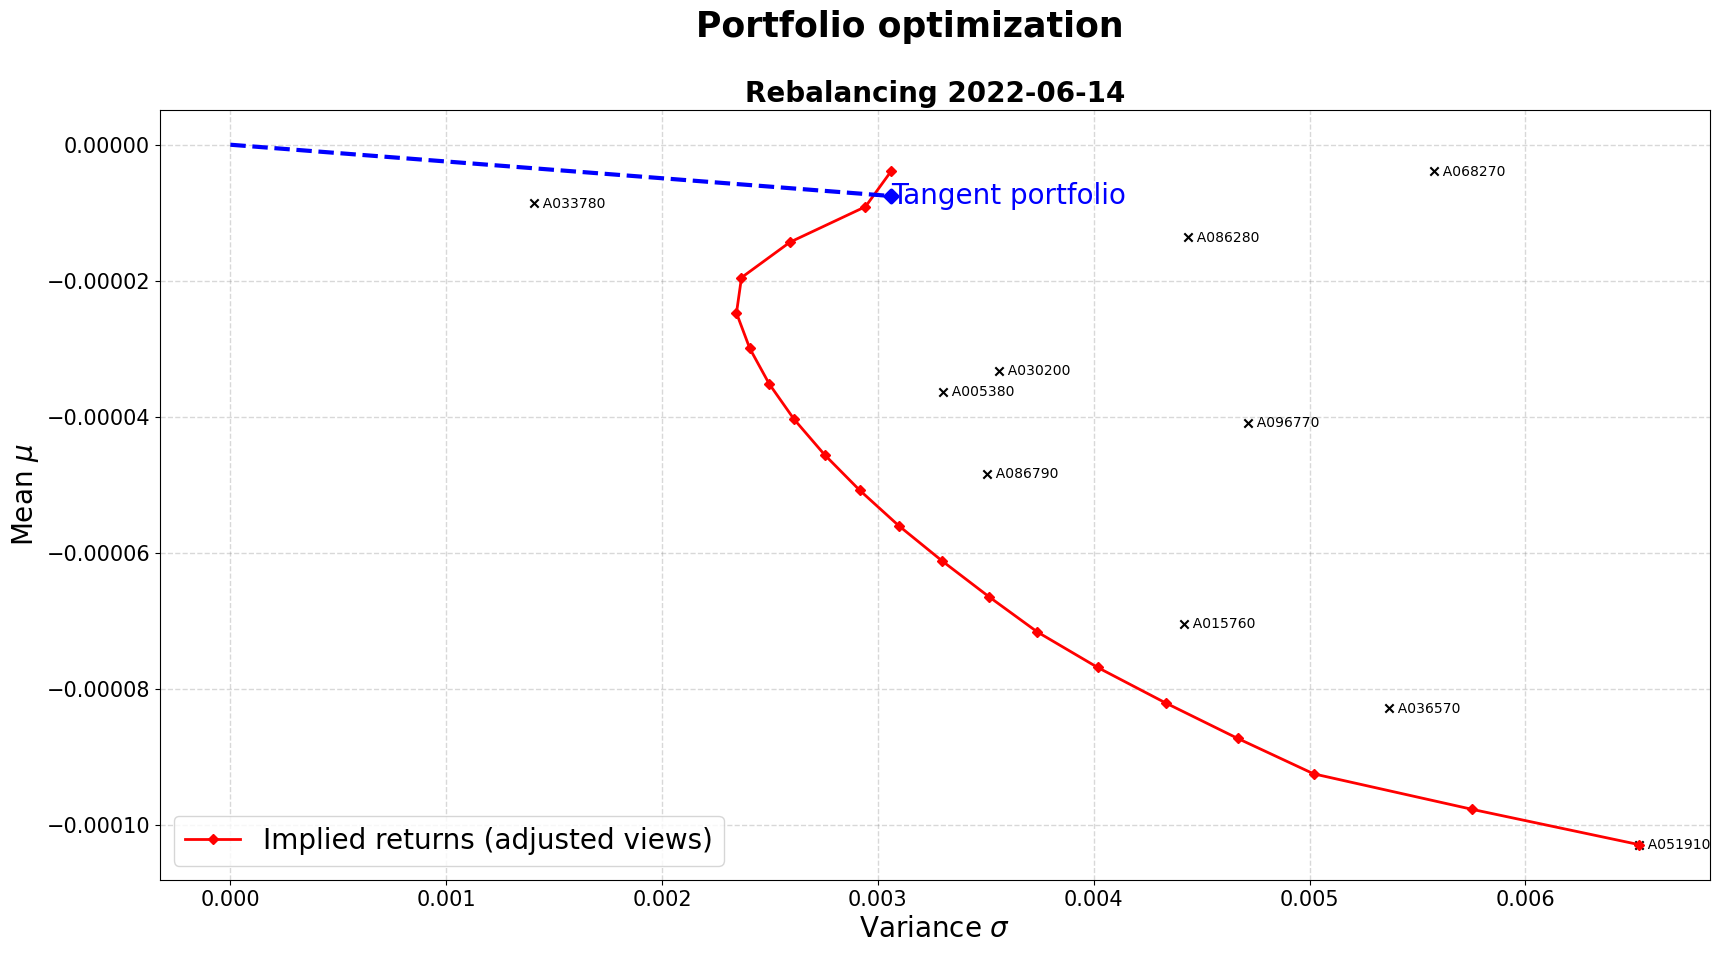

100%|██████████| 60/60 [00:02<00:00, 22.41it/s, Epoch=5/5, mse_loss=0.00567]


43


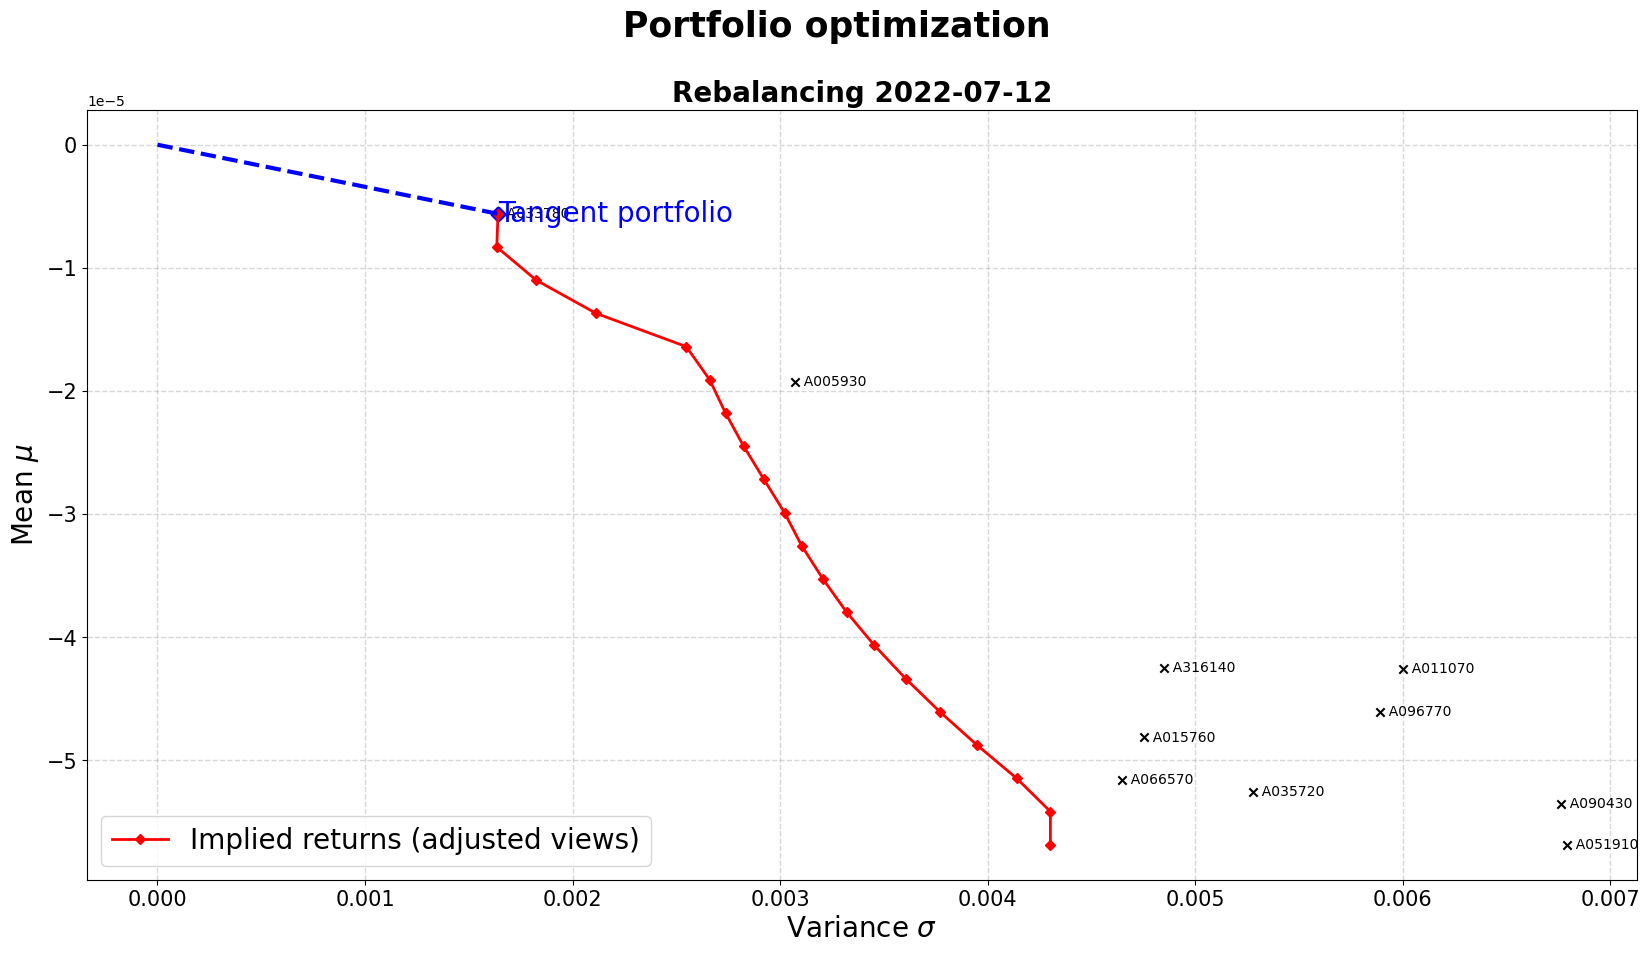

100%|██████████| 60/60 [00:02<00:00, 22.16it/s, Epoch=5/5, mse_loss=0.0117] 


44


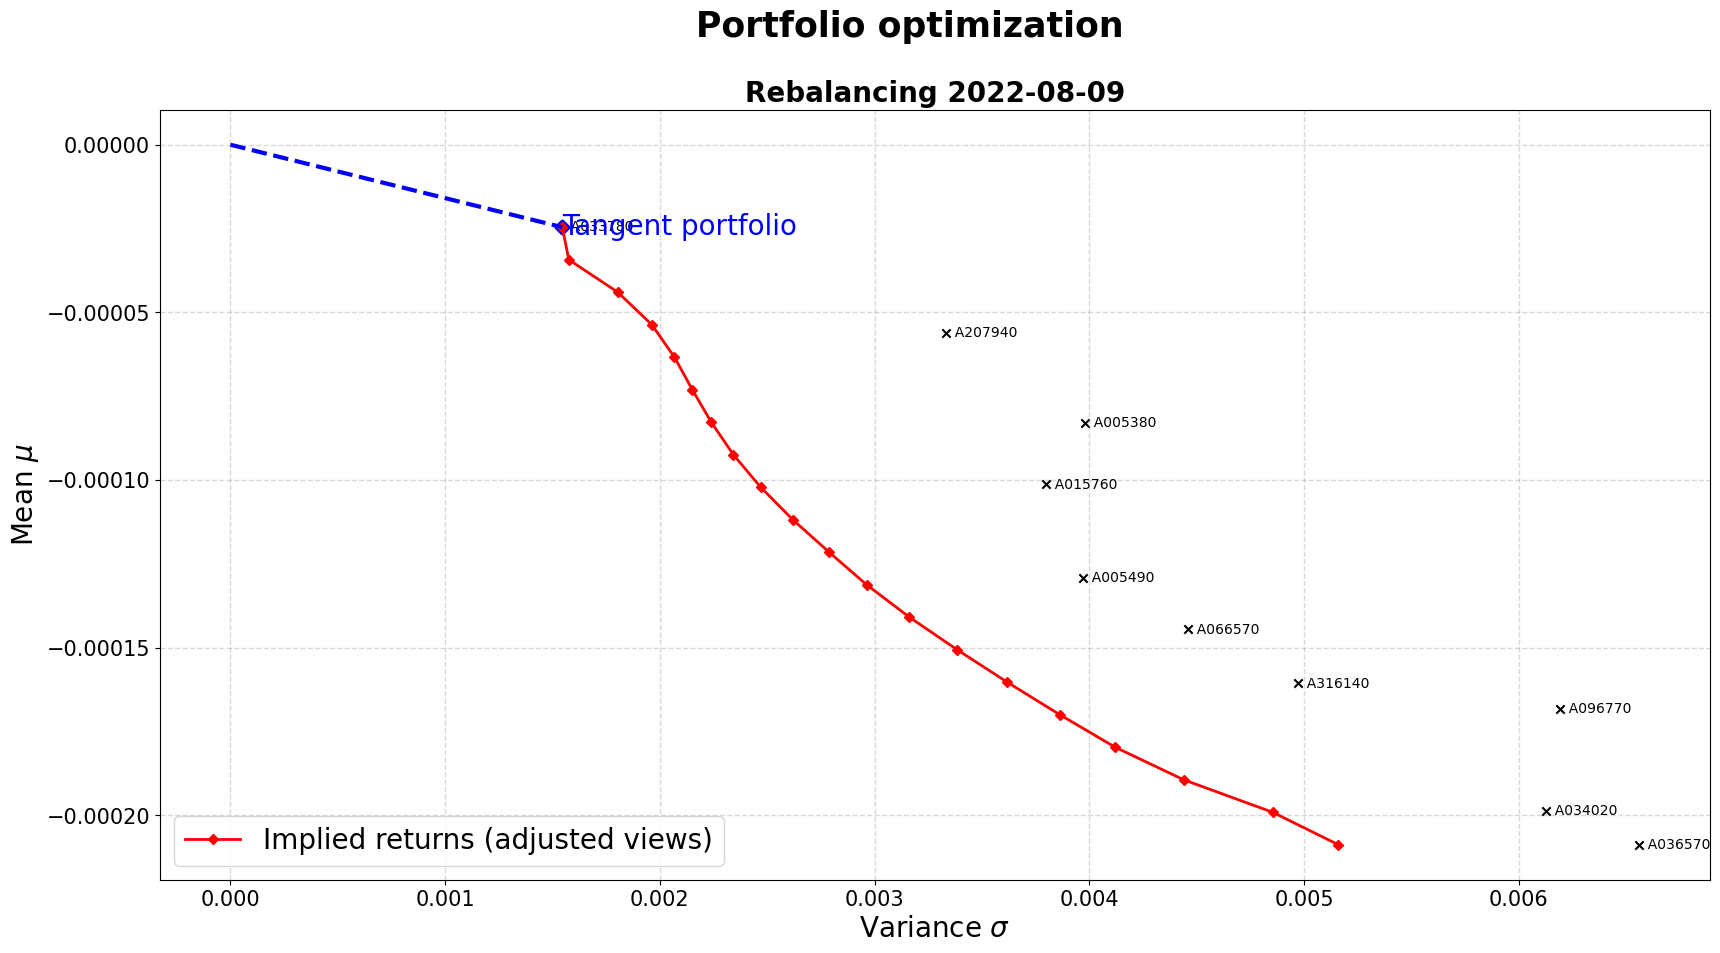

100%|██████████| 60/60 [00:02<00:00, 22.56it/s, Epoch=5/5, mse_loss=0.0059] 


45


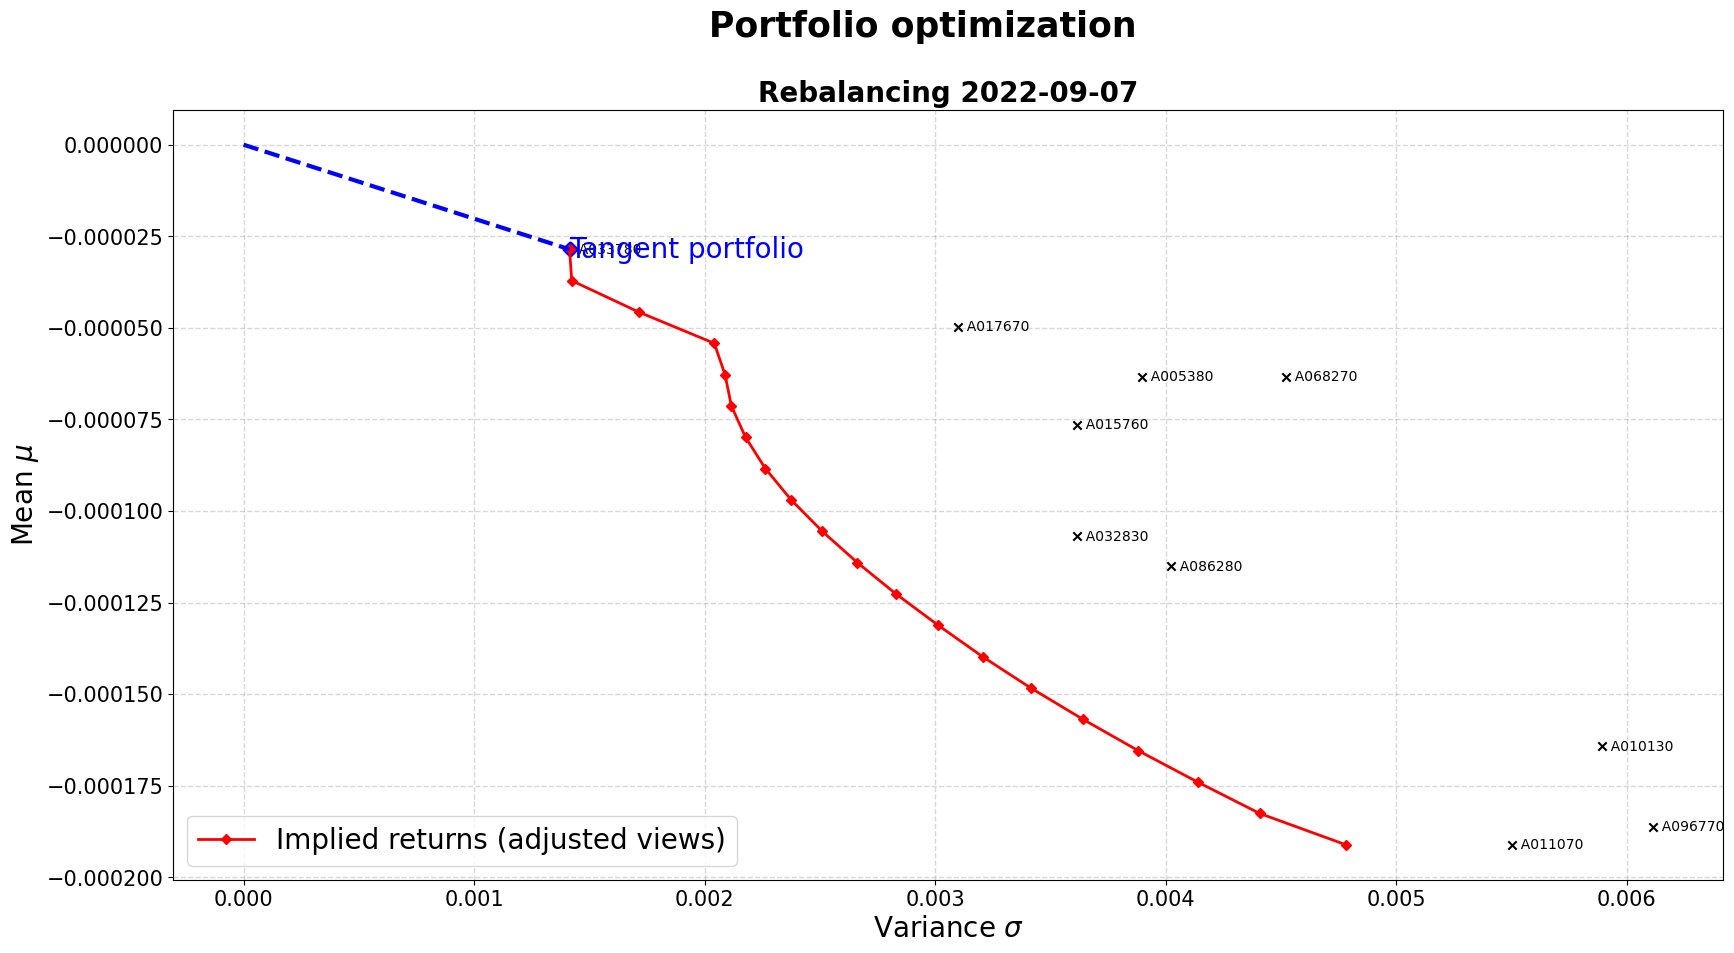

100%|██████████| 60/60 [00:02<00:00, 22.21it/s, Epoch=5/5, mse_loss=0.00265]


46


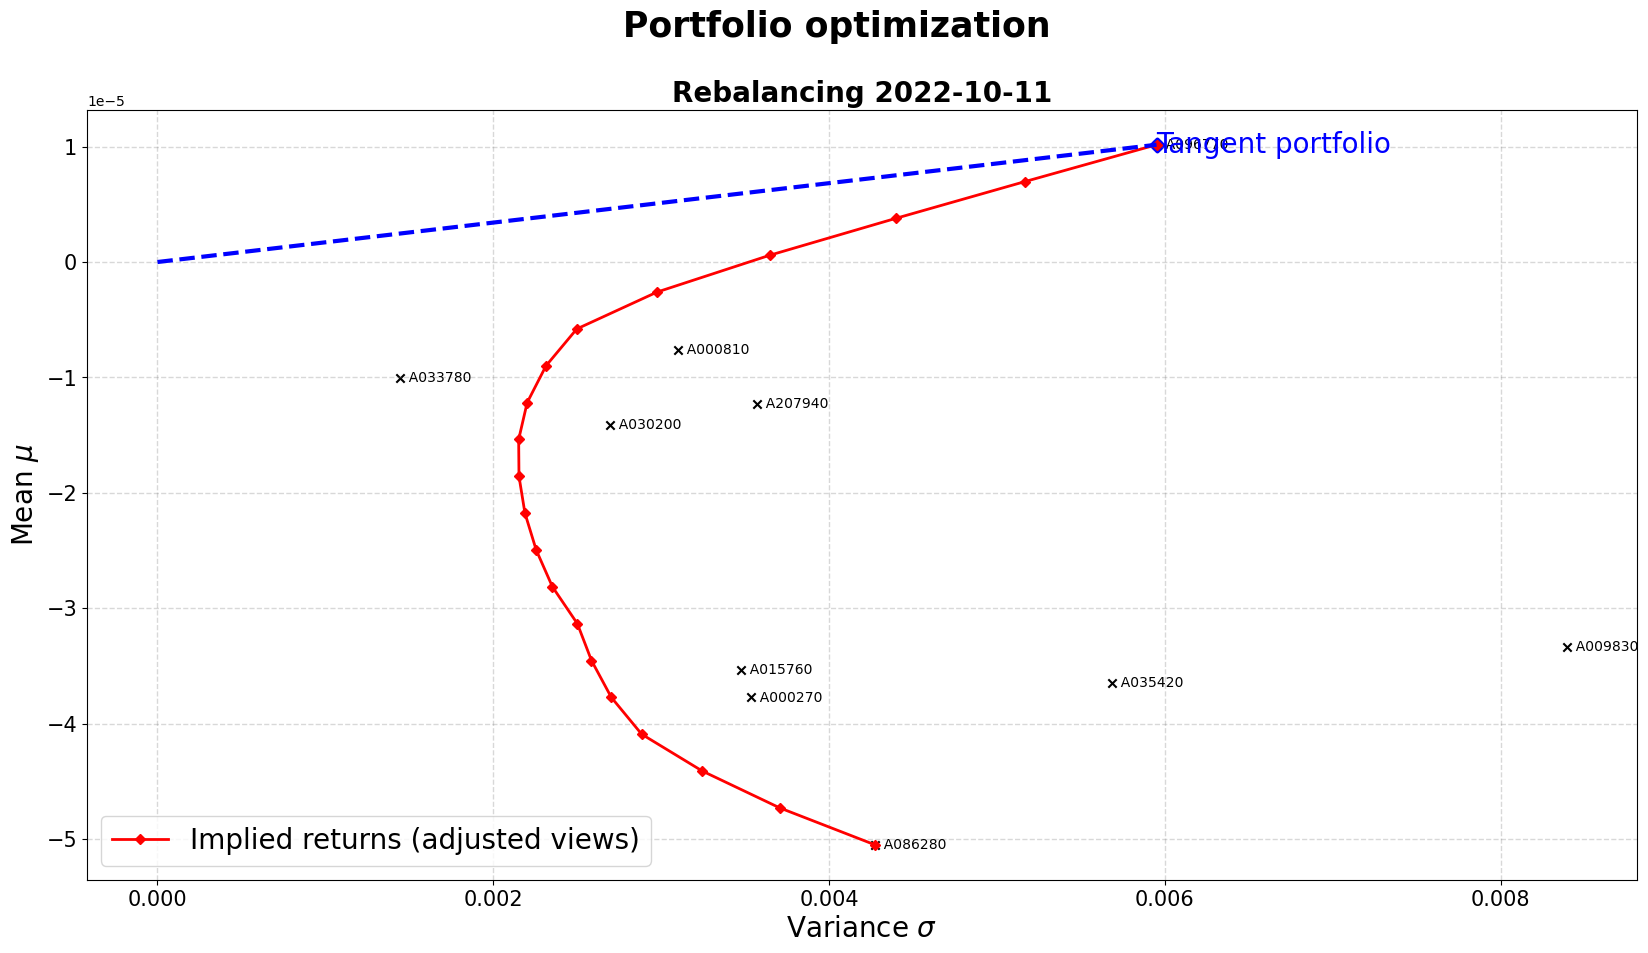

100%|██████████| 60/60 [00:02<00:00, 22.40it/s, Epoch=5/5, mse_loss=0.00755]


In [962]:
import ast
portfolio_start_date = '2019-01-16'
rebalancing_date =  pd.to_datetime(portfolio_start_date)
start_idx = whole_return.index.get_loc(rebalancing_date)

## Black Litterman Parameters
K = 10 # number of assets
N = 10 # number of views(Absolute) -> K,N 모두 변화시킬 수 있음. 기본은 10.
tau = 1/20 #Pi에 대한 불확실한 정도. 1/N 으로 구성

P = np.eye(K)  # P는 항상 10x10 identity matrix
portfolio_data1 = []

lstm_input_length = 120
bl_input_length = 60  # Historic Date Length
prediction_date_length = 20  # 

# i = 20
# for i in range(100):
for i in range(47):
# rebal_day = pd.to_datetime(rebalancing_date)
    print(i)
    rebal_idx = start_idx+i*prediction_date_length
    rebalancing_date = whole_return.index[rebal_idx]
    #rebal_date_list.append(rebalancing_date) 이 부분 필요 없음.
    #for 문을 돌면서, 리밸런싱 데이별로 계속 뽑아낼 것임.

    torch.save(model.state_dict(), f'./model/{str(rebalancing_date)[:10]}.pt')
    # bi_lstm_model.load_state_dict(torch.load( f'./model/BI_LSTM_{str(rebalancing_date)[:10]}.pt'))
    '''
    market equity에 따른 자산 선정 및 투자 비중 구하는 code.
    '''
    # rebalancing 기준으로 활용할 데이터 상에서 일단 상장폐지되지 말아야 함.
    market_equity_temp = whole_market_equity.iloc[rebal_idx-lstm_input_length-prediction_date_length-bl_input_length:rebal_idx].dropna(axis=1)

    # final_selected_10에 만약 A326030와 A352820,A302440가 있다면, A005930,A066570,으로 바꿔주는코드
    final_selected_10 = final_selected_10.replace('A326030','A005930')
    final_selected_10 = final_selected_10.replace('A352820','A066570')
    final_selected_10 = final_selected_10.replace('A302440','A035720')
    final_selected_10 = final_selected_10.replace('A361610','A000660')
    final_selected_10 = final_selected_10.replace('A329180','A005930')
    final_selected_10 = final_selected_10.replace('A259960','A034220')
    final_selected_10 = final_selected_10.replace('A377300','A036570')
    final_selected_10 = final_selected_10.replace('A402340','A006400')
    final_selected_10 = final_selected_10.replace('A323410','A088350')
    
    # 하필 상장일에 데이터 없는 친구가 선택됨...
    #Bayesian 기반의 리밸런싱 시점 별 선정된 자산 df는 final_selected_10
    stocks_df = final_selected_10
    
    
    stocks_df.index = pd.to_datetime(stocks_df.index)
    stocks_list = list(stocks_df.loc[rebalancing_date,:])

    #추가로 넣고 싶은 자산이 있으면, 아래의 코드를 통해 추가할 것.
    #stocks_list.append('A005930') 등으로.
    

    # 초기 weight를 시가총액 기준으로 구성.
    mk_weights = pd.DataFrame(whole_market_equity[stocks_list].iloc[rebal_idx].values/whole_market_equity[stocks_list].iloc[rebal_idx].sum(), columns=['Weight'], index=stocks_list)

    '''
    Historical Return에 따르는 정보 구하는 code.
    '''
    hist_end = rebal_idx
    hist_start = hist_end - bl_input_length
    #리밸런싱 당일은 historic한 정보 안담도록 구성
    excess_returns = whole_return.iloc[hist_start:hist_end][stocks_list]

    Sigma = excess_returns.cov()
        
    '''
    이부분 확인 필요. excess_returns를 그냥 mean 값을 취하는지, 1년으로 바꾸는지, 아니면 예측하고자하는 날짜에 대해서 나타내는지.-> 곱하는 것이 옳음.
    '''

    expected_portfolio_returns = (np.array(excess_returns.mean()).reshape(-1,1) * np.array(mk_weights)).sum()*prediction_date_length
    
    #mk_weights
    portfolio_variance = np.array(mk_weights).T.dot(np.array(Sigma)).dot(np.array(mk_weights))

    lamdb = 0.1  # 사용자 지정값 사용 가능. 2.15- 2.65. 2.15 / 2.40 / 2.65 중 하나가 들어감. ############# 바꿔서 돌리기!

    Pi = lamdb * np.array(Sigma).dot(np.array(mk_weights))  

    '''
    Black Litterman에 들어가는 Matrix 구하는 code.
    '''    
    mape_actual_20days = pd.DataFrame(index = whole_close.index[rebal_idx-bl_input_length:rebal_idx], columns = stocks_list)
    mape_actual_rebals = pd.DataFrame(index = whole_close.index[rebal_idx-bl_input_length-prediction_date_length:rebal_idx-prediction_date_length], columns = stocks_list)

    for bl in range(bl_input_length):
    # MAPE의 y_t-60 ~ y_t-1 까지의 real return을 구하는 code
    # Update the DataFrame with the sum of returns from 40 days ago to bl_input_length days ago
        mape_actual_20days.loc[whole_close.index[rebal_idx-bl_input_length+bl]] = whole_close[stocks_list].iloc[rebal_idx-bl_input_length+bl]
        mape_actual_rebals.loc[whole_close.index[rebal_idx-bl_input_length-prediction_date_length+bl]] = whole_close[stocks_list].iloc[rebal_idx-bl_input_length-prediction_date_length+bl]
    

    '''
    rebalancing 시점 이전, t-20~ t-1에서의 Prediction의 불확실성(MAPE)에 대한 정보를 구하는 code.
    

    lstm_input_length = 120
    bl_input_length = 60  # Historic Date Length
    prediction_date_length = 20  # 

    '''

    MAPE_predictions = []            
    for input_length in range(bl_input_length):
        MAPE_open = whole_open[stocks_list].iloc[rebal_idx-lstm_input_length-prediction_date_length-bl_input_length+input_length : rebal_idx-prediction_date_length-bl_input_length+input_length]
        MAPE_high = whole_high[stocks_list].iloc[rebal_idx-lstm_input_length-prediction_date_length-bl_input_length+input_length : rebal_idx-prediction_date_length-bl_input_length+input_length]
        MAPE_low = whole_low[stocks_list].iloc[rebal_idx-lstm_input_length-prediction_date_length-bl_input_length+input_length : rebal_idx-prediction_date_length-bl_input_length+input_length]
        MAPE_close = whole_close[stocks_list].iloc[rebal_idx-lstm_input_length-prediction_date_length-bl_input_length+input_length : rebal_idx-prediction_date_length-bl_input_length+input_length]
        MAPE_volume = whole_volume[stocks_list].iloc[rebal_idx-lstm_input_length-prediction_date_length-bl_input_length+input_length : rebal_idx-prediction_date_length-bl_input_length+input_length]
        MAPE_mask = whole_close[stocks_list].iloc[rebal_idx-lstm_input_length-prediction_date_length-bl_input_length+input_length-1 : rebal_idx-prediction_date_length-bl_input_length+input_length].diff(1).dropna()
        #current_price  = list(whole_close[stocks_list].iloc[rebal_idx-bl_input_length-prediction_date_length+i].values) ## MAPE를 역산하기 위한 close price를 구함-> 아래서 구해짐

        MAPE_whole_data = {}
        for stock in range(len(stocks_list)):
            MAPE_whole_data[stocks_list[stock]] = pd.concat([MAPE_open.iloc[:,stock], MAPE_high.iloc[:,stock], MAPE_low.iloc[:,stock], MAPE_close.iloc[:,stock], MAPE_volume.iloc[:,stock],MAPE_mask.iloc[:,stock]],axis=1)
            MAPE_whole_data[stocks_list[stock]].columns = ['open','high','low','close','volume','dummy']
        for stock in range(len(stocks_list)):
            scaler_x = StandardScaler()
            scaler_x.fit(MAPE_whole_data[stocks_list[stock]])
            MAPE_whole_data[stocks_list[stock]] = scaler_x.transform(MAPE_whole_data[stocks_list[stock]])

        
        #PD to torch
        test_list = []
        for item in MAPE_whole_data:
            test_list.append(MAPE_whole_data[item])
        
        test_torch = torch.FloatTensor(test_list)
        test_torch = test_torch.to(device)
        model.eval()
        
        with torch.no_grad():
            MAPE_outputs = model(test_torch).squeeze()

        MAPE_predictions.append(MAPE_outputs)
    
    

    #MAPE prediction은 현재는 로그 리턴임.
    MAPE_tensor = torch.stack(MAPE_predictions)
    

    mape_vector = []  # MAPE 결과를 저장할 리스트
    eta_vector = []
    fg_vector = []


    # Iterate over each stock -> 최종적으로 eta term을 몇으로서 반영할지를 구함
    for stock in range(MAPE_tensor.shape[1]):
        # Get the actual values for this stock over the 20-day period
        current_price = mape_actual_rebals[stocks_list].iloc[:, stock].values 
        target_price = mape_actual_20days[stocks_list].iloc[:, stock].values

        # Get the predicted values for this stock over the 20-day period
        MAPE_preds = MAPE_tensor[:, stock].numpy() #이건 해당 주식의 로그 리턴

        predicted_close = current_price * np.exp(MAPE_preds)

        # Calculate MAPE for this stock
        mape = calculate_mape(target_price, predicted_close)

        # 해당 주식의 섹터가 bull인지 bear인지에 대한 정보를 가져옴. # i는 몇번째 리밸런싱이냐임
        eta = int(sector_bull_bear.iloc[i,0][final_sector_stock_mapped.T.iloc[stock,i]])
        
        #예측한 FG Indicator을 가져와서 mape를 추가로 보정.

        mape_vector.append(mape)
        eta_vector.append(eta)
    # Convert the list to a numpy array for easier manipulation
    mape_vector = np.array(mape_vector)*0.01 # MAPE를 소수점단위로 바꿔줌
    eta_vector = np.array(eta_vector)
    
    #mape_vector = mape_vector.reshape(-1,1)
    eta_vector = eta_vector.reshape(-1,1)
    Omega = np.diag(mape_vector)

    
    #fg_indicator_df = pd.read_csv('fg_indicator.csv')
    #fg_indicator_df.index = pd.to_datetime(fg_indicator_df.index)
    
    added_term = np.sqrt(np.dot(np.dot(P, abs(Sigma)), P.T))
    #added_term = added_term*(1+abs(50-fg_indicator_df.iloc[rebal_idx,1]))#이건 칼럼 뭐로 주느냐에 따라 다름.. 로직은 neutral일 경우에는 추가적인 불안정성을 더해주지 않는 경우
    
    '''
    rebalancing 시점 20일 이후 Prediction return에 대한 정보를 구하는 code.
    '''
    ############
    # Data Preparation 
    PRED_open = whole_open[stocks_list].iloc[rebal_idx-lstm_input_length:rebal_idx]
    PRED_high = whole_high[stocks_list].iloc[rebal_idx-lstm_input_length:rebal_idx]
    PRED_low = whole_low[stocks_list].iloc[rebal_idx-lstm_input_length:rebal_idx]
    PRED_close = whole_close[stocks_list].iloc[rebal_idx-lstm_input_length:rebal_idx]
    PRED_volume = whole_volume[stocks_list].iloc[rebal_idx-lstm_input_length:rebal_idx]
    PRED_dummy = whole_close[stocks_list].iloc[rebal_idx-lstm_input_length-1:rebal_idx].diff(1).dropna() # 이거 후에 정해짐
    
    PRED_data = {}
    for stock in range(len(stocks_list)):
        PRED_data[stocks_list[stock]] = pd.concat([PRED_open.iloc[:,stock], PRED_high.iloc[:,stock], PRED_low.iloc[:,stock], PRED_close.iloc[:,stock], PRED_volume.iloc[:,stock], PRED_dummy.iloc[:,stock]], axis=1)
        PRED_data[stocks_list[stock]].columns = ['open','high','low','close','volume','dummy']
    for stock in range(len(stocks_list)):
        scaler_x = StandardScaler()
        scaler_x.fit(PRED_data[stocks_list[stock]])
        PRED_data[stocks_list[stock]] = scaler_x.transform(PRED_data[stocks_list[stock]])


    #PD to torch
    PRED_list = []
    for item in PRED_data:
        PRED_list.append(PRED_data[item])

    PRED_torch = torch.FloatTensor(PRED_list)
    # Prediction 진행
    model.eval()
    with torch.no_grad():
        prediction = model(PRED_torch).squeeze()

    Q = prediction.numpy().reshape(-1,1)
###################################################################################
    #Q 보정
    Q = Q + np.dot(eta_vector.T, added_term).T
##########################################################################


    #### Input 구성 완료
    # C = tau * Sigma

    # 투자자 전망과 합쳐진 균형초과수익률 계산
    bl1 = inv(np.dot(tau, Sigma))
    bl2 = np.dot(np.dot(np.transpose(P), inv(Omega)), P)
    bl3 = np.dot(inv(np.dot(tau, Sigma)), Pi)
    bl4 = np.dot(np.dot(np.transpose(P), inv(Omega)), Q)
    BL_mean = np.dot(inv(bl1 + bl2), (bl3 + bl4))
    
    BL_sigma = inv(inv(Omega)+ inv(tau*Sigma))
    #####################

    opt3 = optimize_frontier(BL_mean + 0, BL_sigma, 0, np.array(mk_weights).reshape(-1), lamdb)  # 0 = rf

    optimized_W_1, _, _ = opt3['weights_1'], _,_


    '''
    해당 weights는 리밸런싱 사이에서는 그대로 유지되나, return은 그 사이에서 계속 변화함. 유지되는 weights를 반영하여 실제 수익률을 매일 계산하는 코드
    '''

    for day in range(rebal_idx, rebal_idx + prediction_date_length):
     
        #  optimized_W_1는 음수의 경우 하나에 대해서 몰빵하는 경우에 대한 예외처리가 안된 경우, optimized_W_2는 해당 경우 발견 시 이전 weight를 유지하는 것.
               
            
        daily_log1 = np.exp(whole_return[stocks_list].iloc[day].values)  # Get daily returns
        daily_return1 = np.log(np.dot(optimized_W_1, daily_log1))  # Calculate daily portfolio return

        #For Strategy 1
        daily_data1 = {
        'Date': whole_return.index[day], 
        'Portfolio_Return': daily_return1,
        'Selected_Assets': stocks_list,
        'Asset_Weights': optimized_W_1
        }

        portfolio_data1.append(daily_data1)


    # 최적화 결과를 차트로 출력
    plt.figsize=(20, 10)
    plotAssets(stocks_list, BL_mean+0, np.array(BL_sigma), color='black')
    plotFrontier(opt3, label='Implied returns (adjusted views)', color='red')

    #if opt3['tan_mean'] / opt3['tan_var'] < 0:
    #    
    #    tan_mean_2 = np.dot(np.transpose(BL_mean),optimized_W_2)
    #    tan_var_2 = np.dot(np.dot(optimized_W_2, BL_sigma), optimized_W_2)
    #    
    #    ## 두번째 전략
    #    plt.scatter(tan_var_2**.5, tan_mean_2, marker='D', color='green',s = 100, label = 'Initial Weights Portfolio')
    #    plt.text(tan_var_2**.5, tan_mean_2, 'Initial Weights Portfolio', verticalalignment='center', color='green', size = 20)

    #    ## 세번째 전략
    #    tan_mean_3 = np.dot(np.transpose(BL_mean),optimized_W_3)
    #    tan_var_3 = np.dot(np.dot(optimized_W_3, BL_sigma), optimized_W_3)
        
        ## 두번째 전략
    #    plt.scatter(tan_var_3**.5, tan_mean_3, marker='D', color='orange',s = 100, label = 'Minimum Variance Portfolio')
    #    plt.text(tan_var_3**.5, tan_mean_3, 'Minimum Variance Portfolio', verticalalignment='center', color='orange', size = 20)

    
    # 차트에 공통된 속성을 지정한다(차트크기, 제목, 범례, 축이름 등)
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.grid(alpha=0.3, color='gray', linestyle='--', linewidth=1)
    #plt.legend(['Historical returns(blue)','Implied returns with adjusted views(red)'], loc = 'upper left', fontsize=12)
    plt.xlabel('Variance $\sigma$', fontsize=20)
    plt.ylabel('Mean $\mu$', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='lower left', fontsize=20)
    plt.suptitle(f'Portfolio optimization', fontsize=25, fontweight='bold')
    plt.title(f'Rebalancing {str(rebalancing_date)[:10]}', fontsize = 20, fontweight='bold')
    plt.show()


    '''
    다시 MAPE에서 사용했던 데이터를 그대로 활용해 최근의 경향성을 학습하기 위해 fine-tuning을 진행하는 코드
    '''
    #  Fine-tuning을 위한 데이터 구성
    num_epochs = 5
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    lstm_input_length = 120
    bl_input_length = 60  # Historic Date Length
    prediction_date_length = 20  # 

    for epoch in range(num_epochs):
         with tqdm(range(bl_input_length)) as pbar:
              for i in range(bl_input_length):
                 train_open = whole_open[stocks_list].iloc[rebal_idx-lstm_input_length-bl_input_length-prediction_date_length+i : rebal_idx-bl_input_length-prediction_date_length+i]  # -120-60-20 ~ -60-20
                 train_high = whole_high[stocks_list].iloc[rebal_idx-lstm_input_length-bl_input_length-prediction_date_length+i : rebal_idx-bl_input_length-prediction_date_length+i]
                 train_low = whole_low[stocks_list].iloc[rebal_idx-lstm_input_length-bl_input_length-prediction_date_length+i : rebal_idx-bl_input_length-prediction_date_length+i]
                 train_close = whole_close[stocks_list].iloc[rebal_idx-lstm_input_length-bl_input_length-prediction_date_length+i : rebal_idx-bl_input_length-prediction_date_length+i]
                 train_volume = whole_volume[stocks_list].iloc[rebal_idx-lstm_input_length-bl_input_length-prediction_date_length+i : rebal_idx-bl_input_length-prediction_date_length+i]

                 train_dummy = whole_close[stocks_list].iloc[rebal_idx-lstm_input_length-bl_input_length-prediction_date_length+i-1 : rebal_idx-bl_input_length-prediction_date_length+i].diff(1).dropna()
                 train_stock_target_return = whole_return[stocks_list].iloc[rebal_idx-bl_input_length-prediction_date_length+i : rebal_idx-bl_input_length+i]
            
                 train_data = {}
                 train_data_scaled = {}
                 for stock in range(len(stocks_list)):
                     train_data[stocks_list[stock]] = pd.concat([train_open.iloc[:,stock], train_high.iloc[:,stock], train_low.iloc[:,stock], train_close.iloc[:,stock], train_volume.iloc[:,stock], train_dummy.iloc[:,stock]], axis=1)
                     train_data[stocks_list[stock]].columns = ['open','high','low','close','volume','dummy']

                 for stock in range(len(stocks_list)):
                     scaler_x = StandardScaler()
                     scaler_x.fit(train_data[stocks_list[stock]])
                     train_data_scaled[stocks_list[stock]] = scaler_x.transform(train_data[stocks_list[stock]])

                 # PD to torch
                 train_list = []
                 for item in train_data:
                     train_list.append(train_data_scaled[item])
            
                 # Convert the data to PyTorch tensors
                 train_data_torch = torch.FloatTensor(train_list)
                 train_stock_target_return_torch = torch.FloatTensor(train_stock_target_return.cumsum().iloc[-1].values).view(-1)

                 # training mode
                 model.train()

                 outputs = model(train_data_torch).squeeze()
                 optimizer.zero_grad()                
                 loss = criterion(outputs, train_stock_target_return_torch)

                 loss.backward()
                 optimizer.step()

                 pbar.set_postfix(
                     Epoch = f'{epoch+1}/{num_epochs}',
                     mse_loss = np.round(loss.cpu().detach().numpy().item(), 5),
                 )
                 pbar.update(1)
    



In [963]:
mape_vector

array([0.09284999, 0.04803616, 0.14638999, 0.06663976, 0.04469225,
       0.06236531, 0.09262739, 0.04562556, 0.04273344, 0.03365908])

In [964]:
#데이터프레임으로 변환
portfolio_df1 = pd.DataFrame(portfolio_data1)  # , index = portfolio_data1['Date']).drop('Date', axis=1)
portfolio_df1.index = portfolio_df1['Date'].values
portfolio_df1.drop('Date', axis=1, inplace=True)
#데이터프레임의 축을 날짜로 저장


In [965]:
#rename each df's 'Portfolio_Return' column as 'Portfolio_Return1' and 'Portfolio_Return2'
portfolio_df1.rename(columns = {'Portfolio_Return':'Portfolio_Return1'}, inplace = True)

In [966]:
portfolio_df1

Portfolio_Return1  \
2019-01-16          -0.016468   
2019-01-17          -0.010056   
2019-01-18           0.008052   
2019-01-21          -0.021928   
2019-01-22           0.007835   
...                       ...   
2022-11-01           0.053455   
2022-11-02           0.005465   
2022-11-03           0.032176   
2022-11-04          -0.065422   
2022-11-07           0.022286   

                                              Selected_Assets  \
2019-01-16  [A036570, A021240, A068270, A005490, A015760, ...   
2019-01-17  [A036570, A021240, A068270, A005490, A015760, ...   
2019-01-18  [A036570, A021240, A068270, A005490, A015760, ...   
2019-01-21  [A036570, A021240, A068270, A005490, A015760, ...   
2019-01-22  [A036570, A021240, A068270, A005490, A015760, ...   
...                                                       ...   
2022-11-01  [A035420, A207940, A009830, A000270, A086280, ...   
2022-11-02  [A035420, A207940, A009830, A000270, A086280, ...   
2022-11-03  [A035420, A207940, A009830, A000270, A086280, ...   
2022-11-04  [A035420, A207940, A009830, A000270, A086280, ...   
2022-11-07  [A035420, A207940, A009830, A000270, A086280, ...   

                                                Asset_Weights  
2019-01-16  [0.025927122611828685, 0.0, 0.4410810287500396...  
2019-01-17  [0.025927122611828685, 0.0, 0.4410810287500396...  
2019-01-18  [0.025927122611828685, 0.0, 0.4410810287500396...  
2019-01-21  [0.025927122611828685, 0.0, 0.4410810287500396...  
2019-01-22  [0.025927122611828685, 0.0, 0.4410810287500396...  
...                                                       ...  
2022-11-01  [0.0, 0.0, 3.2330778290541384e-17, 0.0, 3.5107...  
2022-11-02  [0.0, 0.0, 3.2330778290541384e-17, 0.0, 3.5107...  
2022-11-03  [0.0, 0.0, 3.2330778290541384e-17, 0.0, 3.5107...  
2022-11-04  [0.0, 0.0, 3.2330778290541384e-17, 0.0, 3.5107...  
2022-11-07  [0.0, 0.0, 3.2330778290541384e-17, 0.0, 3.5107...  

[940 rows x 3 columns]

In [967]:
#concat two portfolio_df1 and portfolio_df2, but drop the same named columns
#portfolio_df = pd.concat([portfolio_df1['Portfolio_Return1'], portfolio_df2['Portfolio_Return2'],portfolio_df3], axis=1)

# KOSPI와 비교 도식화 

In [968]:
kospi = pd.read_csv('index.csv',index_col=0, thousands=',')
kospi = kospi[['KOSPI']]
kospi.index = pd.to_datetime(kospi.index)

In [969]:
for day in kospi.index:
    day_idx = kospi.index.get_loc(day)
    # get the log return
    if day_idx == 0:
        kospi.loc[day,'log_return'] = 0
    else:
        kospi.loc[day,'log_return'] = np.log(float(kospi.iloc[day_idx,0])/float(kospi.iloc[day_idx-1,0]))


In [970]:
kospi_start_idx = kospi.index.get_loc('2019-01-16')

In [971]:
kospi_plot_df = kospi.iloc[kospi_start_idx:]

In [972]:
def mdd(series):
    series = series.values
    cumseries = np.cumsum(series)
    mdd = 0
    for i, s in enumerate(cumseries):
        mdd_s = s - np.min(cumseries[i:])
        if mdd_s > mdd:
            mdd = mdd_s

    return mdd


def annual_yield_indicator(yield_):
    print('Annualized return : ', np.round(np.mean(yield_)*252, 2))
    print('Annualized std : ', np.round(np.std(yield_)*(252**0.5),2))
    print('Sharpe ratio : ', np.round(np.mean(yield_)*252
                                    /(np.std(yield_)*(252**0.5)),2))
    print('Downside deviation : ', np.round(np.std(yield_[yield_<0])*(252**0.5),2))
    print('Sortino ratio : ', np.round(np.mean(yield_)*252
                                    /(np.std(yield_[yield_<0])*(252**0.5)),2))
    print('Maximum drawdown(MDD) : ', np.round(mdd(yield_),2))
    print('Calmar ratio : ', np.round(np.mean(yield_)*252/mdd(yield_),2))



In [973]:
daily_return_st1 = portfolio_df1[portfolio_df1.columns[0]]
# daily_return_5.iloc[0] = profits.iloc[0]

annual_yield_indicator(daily_return_st1)
# annual_yield_indicator(log_kospi)

Annualized return :  0.34
Annualized std :  0.27
Sharpe ratio :  1.27
Downside deviation :  0.19
Sortino ratio :  1.76
Maximum drawdown(MDD) :  0.33
Calmar ratio :  1.05


In [974]:
daily_return_st1.index

DatetimeIndex(['2019-01-16', '2019-01-17', '2019-01-18', '2019-01-21',
               '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25',
               '2019-01-28', '2019-01-29',
               ...
               '2022-10-25', '2022-10-26', '2022-10-27', '2022-10-28',
               '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03',
               '2022-11-04', '2022-11-07'],
              dtype='datetime64[ns]', length=940, freq=None)

In [975]:
st1_2019 = daily_return_st1[daily_return_st1.index.year == 2019]
st1_2020 = daily_return_st1[daily_return_st1.index.year == 2020]
st1_rest = daily_return_st1[(daily_return_st1.index>'2021-01-01')&(daily_return_st1.index<'2022-06-30')]


print(annual_yield_indicator(st1_2019))
print(annual_yield_indicator(st1_2020))
print(annual_yield_indicator(st1_rest))





Annualized return :  0.16
Annualized std :  0.21
Sharpe ratio :  0.75
Downside deviation :  0.14
Sortino ratio :  1.09
Maximum drawdown(MDD) :  0.17
Calmar ratio :  0.94
None
Annualized return :  0.51
Annualized std :  0.35
Sharpe ratio :  1.45
Downside deviation :  0.26
Sortino ratio :  1.96
Maximum drawdown(MDD) :  0.33
Calmar ratio :  1.54
None
Annualized return :  0.29
Annualized std :  0.24
Sharpe ratio :  1.2
Downside deviation :  0.16
Sortino ratio :  1.84
Maximum drawdown(MDD) :  0.3
Calmar ratio :  0.97
None


In [976]:
kospi_not_corona = kospi.loc[(kospi.index>'2019-01-01')&(kospi.index<'2019-12-31')].log_return
kospi_corona = kospi.loc[(kospi.index<'2022-12-31')&(kospi.index>'2020-01-01')].log_return

In [977]:
annual_yield_indicator(kospi_not_corona)

Annualized return :  0.08
Annualized std :  0.13
Sharpe ratio :  0.6
Downside deviation :  0.1
Sortino ratio :  0.79
Maximum drawdown(MDD) :  0.16
Calmar ratio :  0.46


In [978]:
annual_yield_indicator(kospi_corona)

Annualized return :  0.02
Annualized std :  0.22
Sharpe ratio :  0.11
Downside deviation :  0.16
Sortino ratio :  0.15
Maximum drawdown(MDD) :  0.44
Calmar ratio :  0.06


In [979]:
kospi_2019 = kospi.loc[(kospi.index>'2019-01-01')&(kospi.index<'2020-01-01')].log_return
kospi_2020 = kospi.loc[(kospi.index>'2020-01-01')&(kospi.index<'2021-01-01')].log_return
kospi_rest = kospi.loc[(kospi.index>'2021-01-01')&(kospi.index<'2022-07-01')].log_return

In [980]:
kospi_total = kospi.loc[(kospi.index>'2019-01-01')&(kospi.index<'2022-07-01')].log_return
annual_yield_indicator(kospi_total)

Annualized return :  0.04
Annualized std :  0.2
Sharpe ratio :  0.19
Downside deviation :  0.15
Sortino ratio :  0.25
Maximum drawdown(MDD) :  0.44
Calmar ratio :  0.09


In [981]:
st1_total = portfolio_df1[(portfolio_df1.index>'2019-01-01')&(portfolio_df1.index<'2022-12-31')].Portfolio_Return1


In [982]:
print(annual_yield_indicator(st1_total))


Annualized return :  0.34
Annualized std :  0.27
Sharpe ratio :  1.27
Downside deviation :  0.19
Sortino ratio :  1.76
Maximum drawdown(MDD) :  0.33
Calmar ratio :  1.05
None


<Axes: >

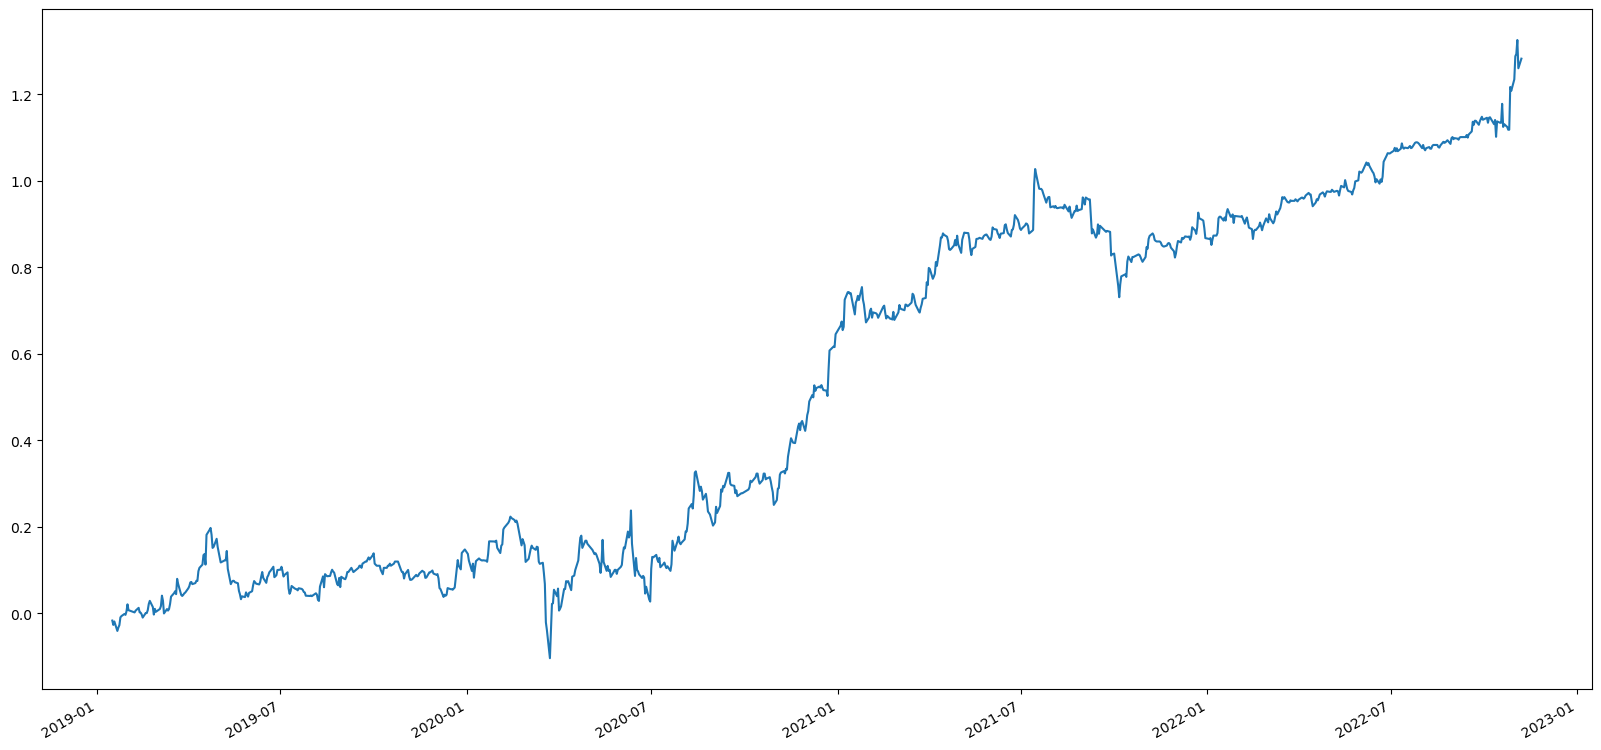

In [983]:
portfolio_df1['Portfolio_Return1'].cumsum().plot()

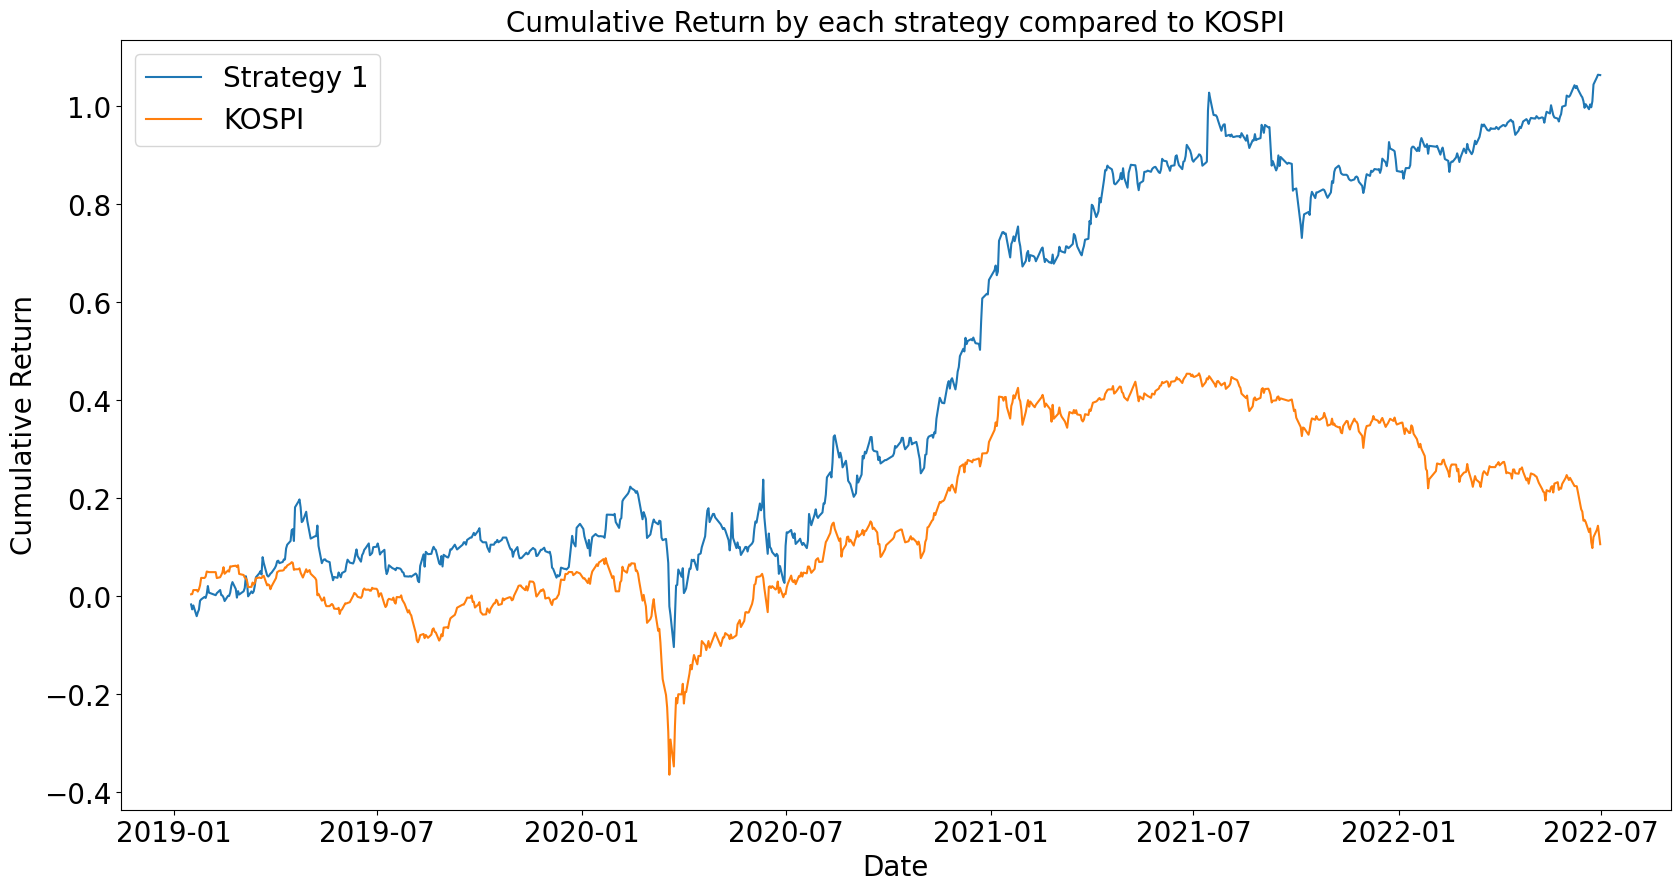

In [984]:
# compare with kospi's log_return and portfolio's log_return by plotting
plt.figure(figsize=(20, 10))
plt.plot(portfolio_df1[portfolio_df1.index<'2022-07-01'].index, portfolio_df1[portfolio_df1.index<'2022-07-01']['Portfolio_Return1'].cumsum(),label = 'Strategy 1')
#plt.plot(portfolio_df2[portfolio_df2.index<'2022-07-01'].index, portfolio_df2[portfolio_df2.index<'2022-07-01']['Portfolio_Return2'].cumsum(),label = 'Strategy 2')
#plt.plot(portfolio_df3[portfolio_df3.index<'2022-07-01'].index, portfolio_df3[portfolio_df3.index<'2022-07-01']['Portfolio_Return3'].cumsum(),label = 'Strategy 3')
#add the title
plt.title('Cumulative Return by each strategy compared to KOSPI', fontsize=20)
plt.plot(kospi_plot_df.loc['2015-01-01':'2022-06-30'].index, kospi_plot_df['log_return'].loc['2015-01-01':'2022-06-30'].cumsum(), label='KOSPI')
plt.legend(fontsize=20, loc = 0)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Cumulative Return', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()



# 추가로 할 것: 비중 조정, 삼성전자 무조건 들고 있겠다~
# 모델 인풋 교정, 다시밀어넣기

In [985]:
#save it as csv
portfolio_df.to_csv('portfolio_df_full_vf.csv')


NameError: name 'portfolio_df' is not defined

In [ ]:
portfolio_df1.to_csv('portfolio_df1_full_vf.csv')
portfolio_df2.to_csv('portfolio_df2_full_vf.csv')
portfolio_df3.to_csv('portfolio_df3_full_vf.csv')
